In [ ]:
!pip install yfinance

# Preliminary analysis

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf

# Define the ticker symbols and date range
tickers = ["AAPL", "JNJ", "WMT"]
start_date = "2010-07-01"
end_date = "2025-02-28"

# Download daily adjusted close prices
data = yf.download(tickers, start=start_date, end=end_date)["Close"]

# Compute daily log returns, dropping the first NaN row
returns = np.log(data).diff().dropna()

# Demean returns using the expanding (historical) mean computed from all previous observations
demeaned_returns = returns.copy()
for ticker in returns.columns:
    # Compute the expanding mean and shift it so that at time t, it uses data from before t.
    expanding_mean = returns[ticker].expanding().mean().shift(1)
    # Subtract the expanding mean from the current return; fill the first value (NaN) with 0.
    demeaned_returns[ticker] = returns[ticker] - expanding_mean.fillna(0)

returns = demeaned_returns.copy()

[*********************100%***********************]  3 of 3 completed


In [ ]:
demeaned_returns.shape

(3648, 3)

summary stats of price series

In [ ]:
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import adfuller

# -------------------------------
# 2. Summary Statistics
# -------------------------------
def compute_summary_stats(series):
    """Compute basic summary statistics for a Pandas Series of returns."""
    stats_dict = {
        "Mean": series.mean(),
        "Std": series.std(),
        "Skew": series.skew(),
        "Kurtosis": series.kurtosis()
    }
    return pd.Series(stats_dict)

# Summary stats for prices
summary_stats_prices = data.apply(compute_summary_stats)
print("Summary Statistics for Prices:")
print(summary_stats_prices)
print(summary_stats_prices.to_latex(float_format="%.4f"))

Summary Statistics for Prices:
Ticker         AAPL         JNJ        WMT
Mean      71.293946  102.548050  31.719111
Std       67.531448   40.189558  17.310923
Skew       0.967437   -0.056048   1.400438
Kurtosis  -0.461438   -1.312151   2.178380
\begin{tabular}{lrrr}
\toprule
Ticker & AAPL & JNJ & WMT \\
\midrule
Mean & 71.2939 & 102.5481 & 31.7191 \\
Std & 67.5314 & 40.1896 & 17.3109 \\
Skew & 0.9674 & -0.0560 & 1.4004 \\
Kurtosis & -0.4614 & -1.3122 & 2.1784 \\
\bottomrule
\end{tabular}



Summary Statistics for Daily Log Returns:
Ticker        AAPL       JNJ        WMT
Mean     -0.000125 -0.000113   0.000029
Std       0.017493  0.010630   0.012226
Skew     -0.244845 -0.270695  -0.227680
Kurtosis  5.569567  9.272979  16.001840
\begin{tabular}{lrrr}
\toprule
Ticker & AAPL & JNJ & WMT \\
\midrule
Mean & -0.0001 & -0.0001 & 0.0000 \\
Std & 0.0175 & 0.0106 & 0.0122 \\
Skew & -0.2448 & -0.2707 & -0.2277 \\
Kurtosis & 5.5696 & 9.2730 & 16.0018 \\
\bottomrule
\end{tabular}

\begin{table}
\caption{ADF Test Results for Raw Prices and Log Returns}
\label{tab:adf_results}
\begin{tabular}{lllll}
\toprule
Ticker & Raw Prices p-value & Raw Prices Result & Log Returns p-value & Log Returns Result \\
\midrule
AAPL & 0.9955 & Non-stationary & 0.0000 & Stationary \\
JNJ & 0.7756 & Non-stationary & 0.0000 & Stationary \\
WMT & 1.0000 & Non-stationary & 0.0000 & Stationary \\
\bottomrule
\end{tabular}
\end{table}



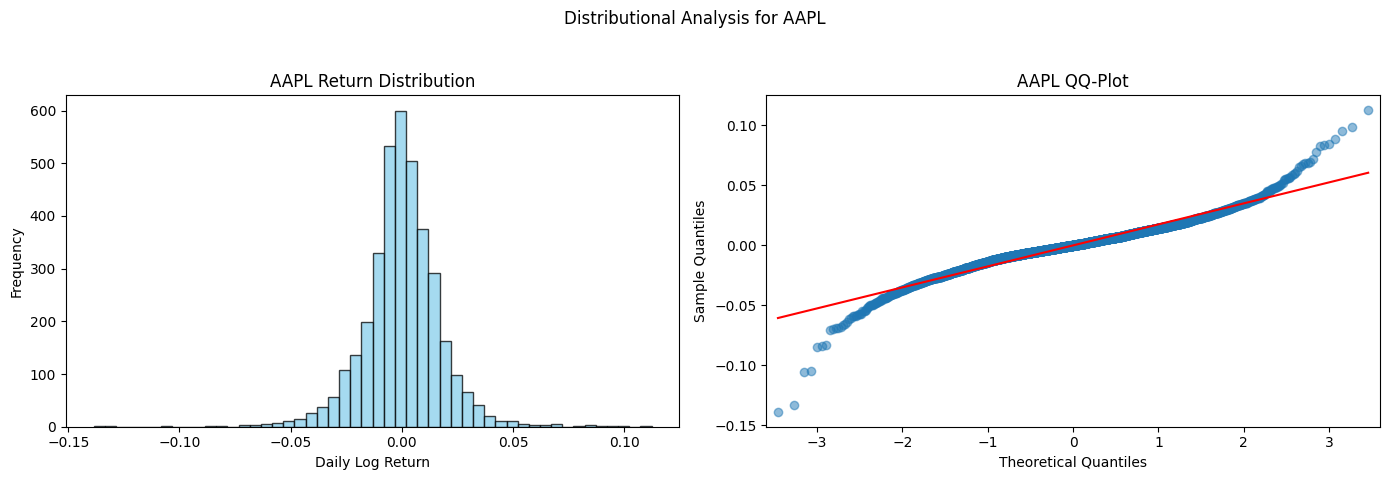

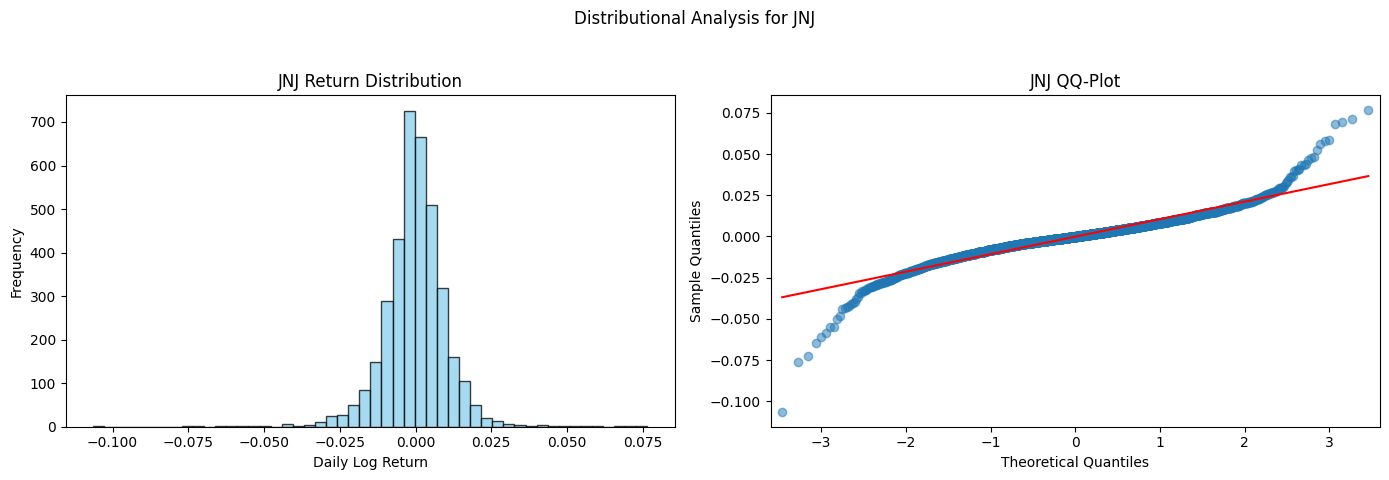

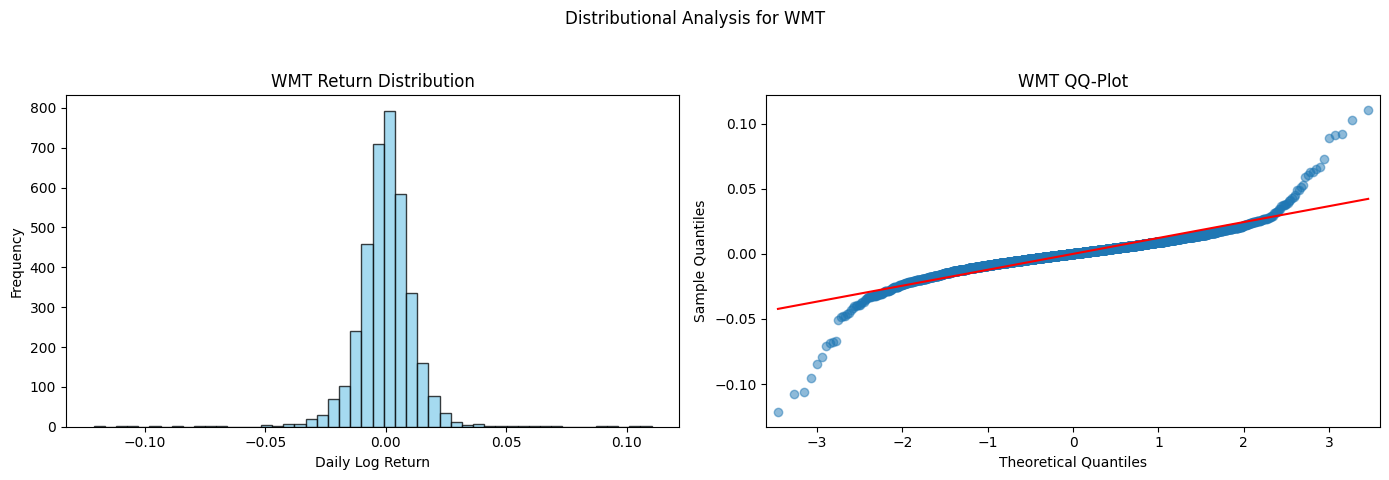

In [ ]:
# Compute summary statistics for each stock for prices
summary_stats = returns.apply(compute_summary_stats)
print("Summary Statistics for Daily Log Returns:")
print(summary_stats)

print(summary_stats.to_latex(float_format="%.4f"))

# (Augmented) Dickey Fuller Tests

from statsmodels.tsa.stattools import adfuller
import pandas as pd

adf_results = []

for ticker in tickers:
    # first test raw data
    series_raw = data[ticker].dropna()
    pval_raw = adfuller(series_raw)[1]
    result_raw = "Stationary" if pval_raw < 0.05 else "Non-stationary"
    # test log returns again
    series_ret = returns[ticker].dropna()
    pval_ret = adfuller(series_ret)[1]
    result_ret = "Stationary" if pval_ret < 0.05 else "Non-stationary"

    adf_results.append({
        "Ticker": ticker,
        "Raw Prices p-value": f"{pval_raw:.4f}",
        "Raw Prices Result": result_raw,
        "Log Returns p-value": f"{pval_ret:.4f}",
        "Log Returns Result": result_ret
    })

adf_df = pd.DataFrame(adf_results)

latex_adf = adf_df.to_latex(index=False, caption="ADF Test Results for Raw Prices and Log Returns", label="tab:adf_results")

print(latex_adf)

# Unit roots taken care of via first differencing in logs (as ususal for return calculations)

# -------------------------------
# 3. Distribution Visualizations: Histograms and QQ-Plots
# -------------------------------
def plot_distribution(stock, data):
    """Plot histogram and QQ-plot for the given stock return series."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram
    axes[0].hist(data, bins=50, alpha=0.75, color='skyblue', edgecolor='black')
    axes[0].set_title(f"{stock} Return Distribution")
    axes[0].set_xlabel("Daily Log Return")
    axes[0].set_ylabel("Frequency")

    # QQ-plot
    sm.qqplot(data, line='s', ax=axes[1], marker='o', alpha=0.5)
    axes[1].set_title(f"{stock} QQ-Plot")

    plt.suptitle(f"Distributional Analysis for {stock}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot distribution for each stock
for stock in tickers:
    plot_distribution(stock, returns[stock])


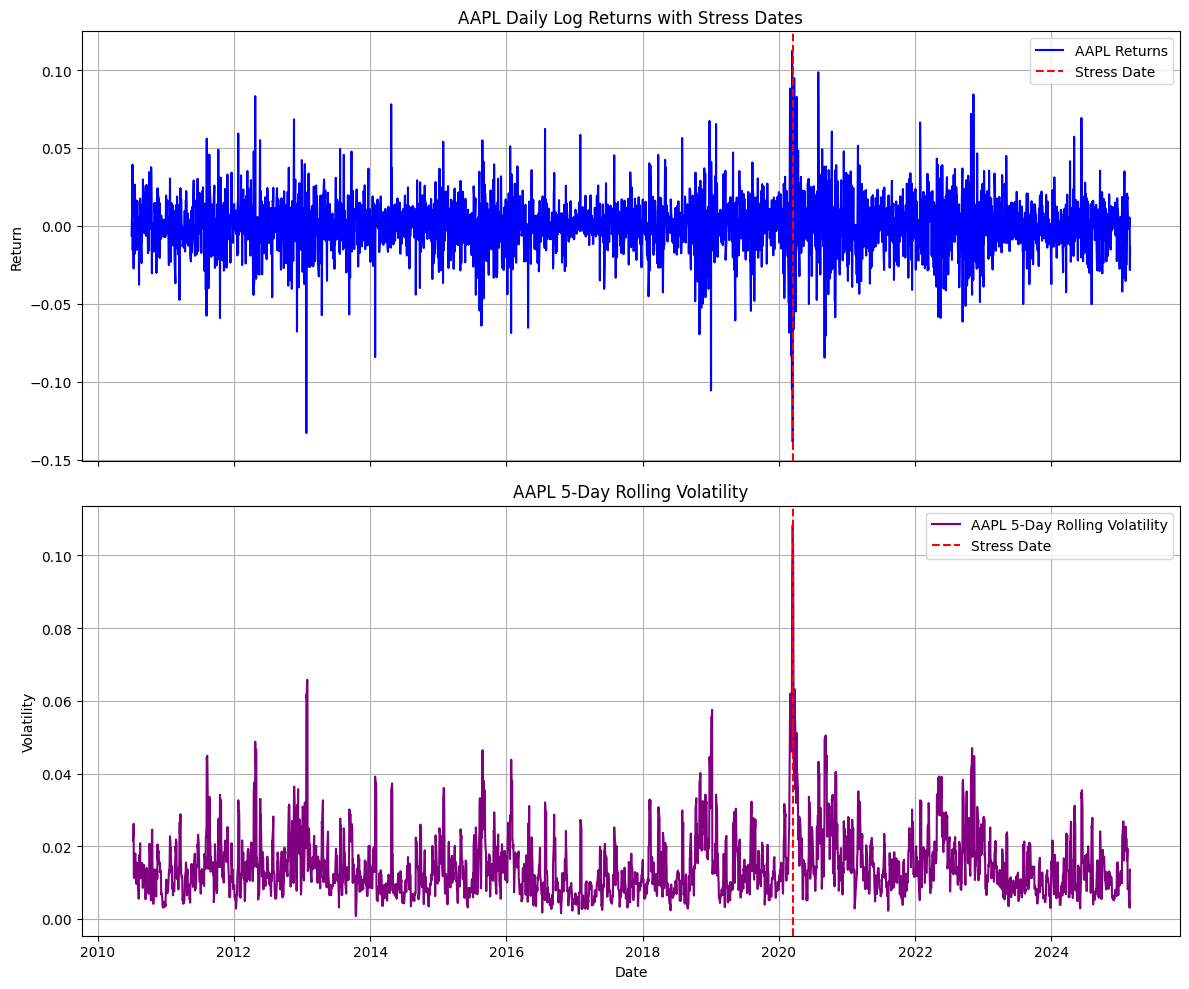

In [ ]:
# -------------------------------
# 4. Time Series of Returns and Rolling Volatility
# -------------------------------
# Define a rolling window (e.g., 22 trading days ~ one month)
window = 5

# Compute rolling volatility (standard deviation) for each stock
rolling_vol = returns.rolling(window=window).std()

# Define some known market stress dates for illustration (adjust as needed)

# start_date = "2010-01-01"
# end_date = "2025-02-28"

stress_dates = pd.to_datetime([
    "2020-03-16",   # COVID-19 market turmoil
])

# Plot time series of returns
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plot returns time series for AAPL (or choose one or overlay multiple)
axes[0].plot(returns.index, returns["AAPL"], label="AAPL Returns", color="blue")
axes[0].set_title("AAPL Daily Log Returns with Stress Dates")
axes[0].set_ylabel("Return")
axes[0].legend()
axes[0].grid(True)

# Highlight stress dates on the returns plot
for date in stress_dates:
    axes[0].axvline(x=date, color="red", linestyle="--", linewidth=1.5, label="Stress Date")
# To avoid duplicate legend entries
handles, labels = axes[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[0].legend(by_label.values(), by_label.keys())

# Plot rolling volatility for AAPL (similar treatment can be done for other stocks)
axes[1].plot(rolling_vol.index, rolling_vol["AAPL"], label=f"AAPL {window}-Day Rolling Volatility", color="purple")
axes[1].set_title(f"AAPL {window}-Day Rolling Volatility")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Volatility")
axes[1].legend()
axes[1].grid(True)

# Highlight stress dates on the volatility plot
for date in stress_dates:
    axes[1].axvline(x=date, color="red", linestyle="--", linewidth=1.5, label="Stress Date")
handles, labels = axes[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[1].legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

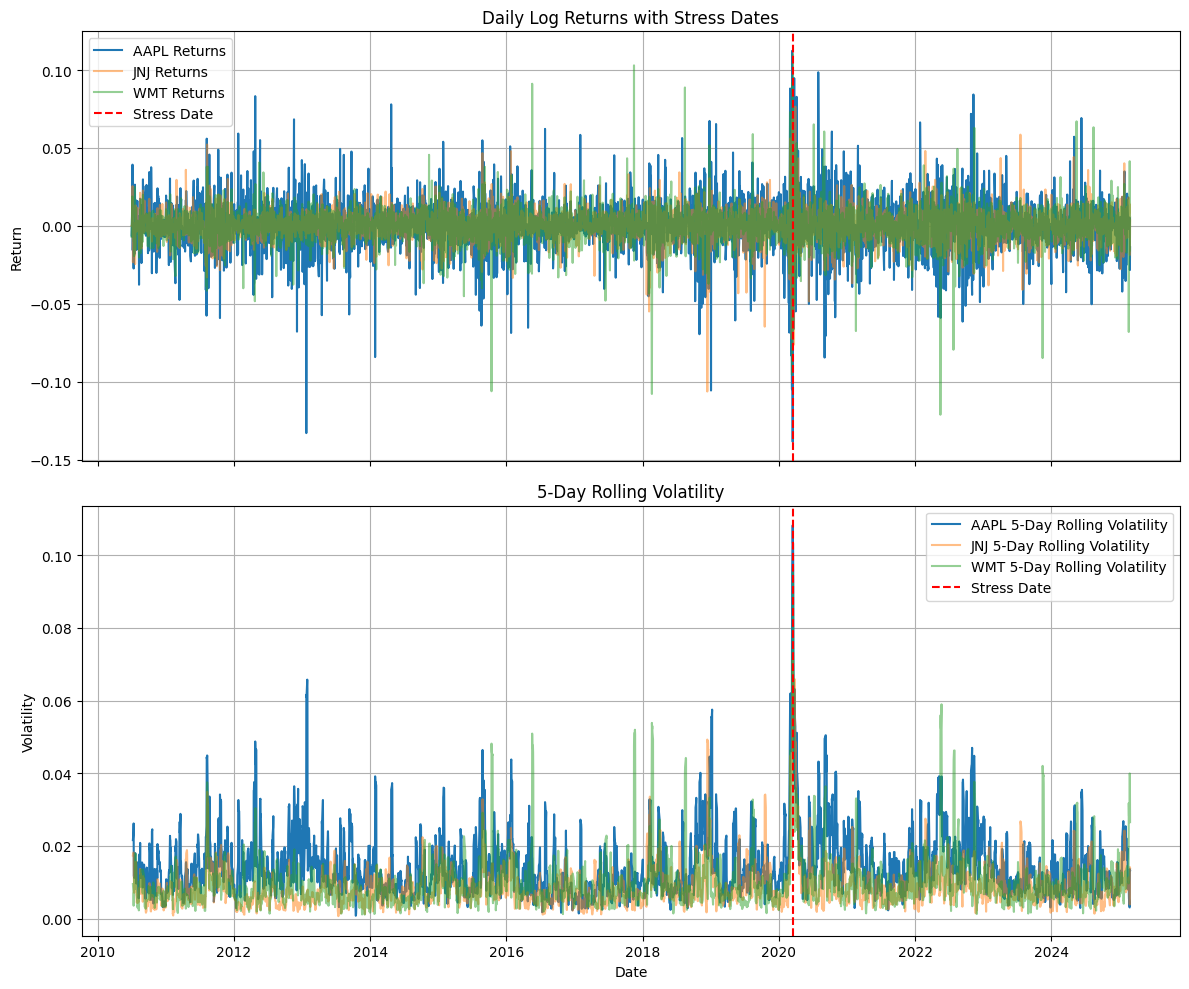

In [ ]:
import matplotlib.pyplot as plt

# Assuming `returns`, `rolling_vol`, `window`, and `stress_dates` are already defined

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# --------------------------
# Plot Time Series of Returns for All Stocks
# --------------------------
for i, ticker in enumerate(returns.columns):
    alpha_value = 1.0 if i == 0 else 0.5
    axes[0].plot(returns.index, returns[ticker], label=f"{ticker} Returns", alpha=alpha_value)

axes[0].set_title("Daily Log Returns with Stress Dates")
axes[0].set_ylabel("Return")
axes[0].grid(True)

# Plot stress dates (add label only once)
for i, date in enumerate(stress_dates):
    if i == 0:
        axes[0].axvline(x=date, color="red", linestyle="--", linewidth=1.5, label="Stress Date")
    else:
        axes[0].axvline(x=date, color="red", linestyle="--", linewidth=1.5)

# Remove duplicate legend entries
handles, labels = axes[0].get_legend_handles_labels()
unique = dict(zip(labels, handles))
axes[0].legend(unique.values(), unique.keys())


# --------------------------
# Plot Rolling Volatility for All Stocks
# --------------------------
for i, ticker in enumerate(returns.columns):
    alpha_value = 1.0 if i == 0 else 0.5
    axes[1].plot(rolling_vol.index, rolling_vol[ticker], label=f"{ticker} {window}-Day Rolling Volatility", alpha=alpha_value)

axes[1].set_title(f"{window}-Day Rolling Volatility")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Volatility")
axes[1].grid(True)

# Plot stress dates on the volatility plot (add label only once)
for i, date in enumerate(stress_dates):
    if i == 0:
        axes[1].axvline(x=date, color="red", linestyle="--", linewidth=1.5, label="Stress Date")
    else:
        axes[1].axvline(x=date, color="red", linestyle="--", linewidth=1.5)

# Remove duplicate legend entries
handles, labels = axes[1].get_legend_handles_labels()
unique = dict(zip(labels, handles))
axes[1].legend(unique.values(), unique.keys())

plt.tight_layout()
plt.show()


# MA and EWMA

Note, in MA window size impacts on how many samples we compute the running mean sovariance, bbut in EWMA - only the initial sample size fore the first set-aside observations.

In [ ]:
# ----------------------------------------------
# Model 1: Moving Average Covariance
# ----------------------------------------------
def moving_average_covariance(returns, window):
    """
    Computes the moving average (MA) covariance matrices for a given rolling window.

    Parameters:
        returns (pd.DataFrame): DataFrame with return series (each column one asset)
        window (int): Number of past days to use in the covariance estimation

    Returns:
        dict: A dictionary with date keys and the corresponding covariance matrix (numpy array)
    """
    ma_covariances = {}
    for t in range(window, len(returns)):
        current_date = returns.index[t]
        # Use the past 'window' days' returns to compute the covariance matrix
        window_returns = returns.iloc[t-window:t]
        cov_matrix = window_returns.cov().values
        ma_covariances[current_date] = cov_matrix
    return ma_covariances

# ----------------------------------------------
# Model 2: Exponentially Weighted Moving Average (EWMA) Covariance
# ----------------------------------------------
def ewma_covariance(returns, lam, window):
    """
    Computes the EWMA covariance matrix recursively.

    Parameters:
        returns (pd.DataFrame): DataFrame with return series (each column one asset)
        lam (float): Decay factor lambda in [0,1] (typical value: 0.94 for daily data)
        window (int): Window length used to initialize the covariance matrix using the sample covariance

    Returns:
        dict: A dictionary with date keys and the corresponding EWMA covariance matrix (numpy array)
    """
    ewma_covariances = {}
    # Initialize using the sample covariance over the first 'window' days
    start_index = window
    initial_cov = returns.iloc[:window].cov().values
    prev_cov = initial_cov.copy()
    # Use the first date after the initialization window for the first EWMA covariance
    ewma_covariances[returns.index[start_index]] = initial_cov

    # Recursive update of the covariance matrix
    for t in range(start_index + 1, len(returns)):
        current_date = returns.index[t]
        # Get the most recent return vector (t-1), reshape it as a column vector
        r = returns.iloc[t-1].values.reshape(-1, 1)
        # Update using EWMA formula:
        # Sigma_t = (1-lambda) * (r r') + lambda * Sigma_{t-1}
        new_cov = (1 - lam) * (r @ r.T) + lam * prev_cov
        ewma_covariances[current_date] = new_cov
        prev_cov = new_cov.copy()
    return ewma_covariances

# Set parameters
window = 63    # e.g., 22 trading days (roughly one month)
lam = 0.94     # Decay factor for EWMA

# Compute covariance matrices
ma_cov = moving_average_covariance(returns, window)
ewma_cov = ewma_covariance(returns, lam, window)

# For demonstration, print the last computed covariance matrix from each model:
last_date_ma = list(ma_cov.keys())[-1]
print("Moving Average Covariance on", last_date_ma)
print(ma_cov[last_date_ma])
print("\n" + "="*60 + "\n")
last_date_ewma = list(ewma_cov.keys())[-1]
print("EWMA Covariance on", last_date_ewma)
print(ewma_cov[last_date_ewma])

Moving Average Covariance on 2025-02-27 00:00:00
[[2.29014941e-04 1.10650452e-05 3.31185998e-05]
 [1.10650452e-05 1.35713477e-04 8.22136163e-06]
 [3.31185998e-05 8.22136163e-06 2.41147214e-04]]


EWMA Covariance on 2025-02-27 00:00:00
[[2.51333685e-04 4.50307007e-05 4.09911481e-05]
 [4.50307007e-05 1.55433210e-04 2.18036509e-05]
 [4.09911481e-05 2.18036509e-05 4.59150148e-04]]


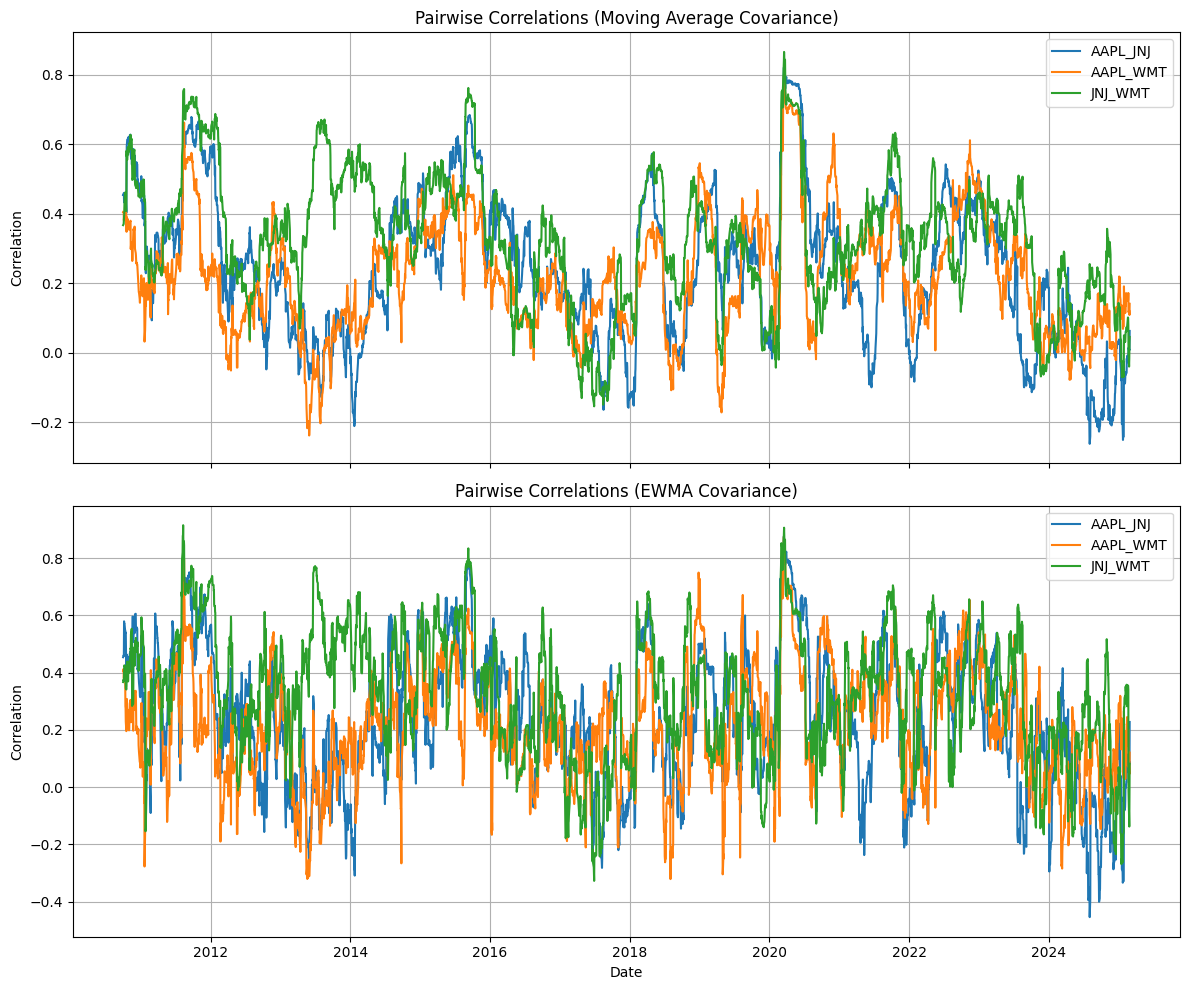

In [ ]:
import matplotlib.pyplot as plt

# -------------------------------
# 3. Converting Covariance Matrices to Correlations
# -------------------------------
def cov_to_corr(cov_matrix):
    """Convert a covariance matrix to a correlation matrix."""
    std_devs = np.sqrt(np.diag(cov_matrix))
    corr_matrix = cov_matrix / np.outer(std_devs, std_devs)
    return corr_matrix

# Prepare dictionaries to store time series of pairwise correlations:
# We have three stocks: positions 0 (AAPL), 1 (JNJ), 2 (WMT).
pairs = [("AAPL", "JNJ"), ("AAPL", "WMT"), ("JNJ", "WMT")]

# Function to extract pairwise correlations from a covariance dictionary
def extract_pairwise_correlations(cov_dict, pairs):
    dates = []
    correlations = {f"{p1}_{p2}": [] for p1, p2 in pairs}

    # Ensure dates are in sorted order
    for date in sorted(cov_dict.keys()):
        dates.append(date)
        corr_matrix = cov_to_corr(cov_dict[date])
        # Extract correlations for the specified pairs
        correlations["AAPL_JNJ"].append(corr_matrix[0, 1])
        correlations["AAPL_WMT"].append(corr_matrix[0, 2])
        correlations["JNJ_WMT"].append(corr_matrix[1, 2])
    # Create a DataFrame with dates as the index
    df = pd.DataFrame(correlations, index=dates)
    return df

# Create dataframes of pairwise correlations for each method
ma_corr_df = extract_pairwise_correlations(ma_cov, pairs)
ewma_corr_df = extract_pairwise_correlations(ewma_cov, pairs)

# -------------------------------
# 4. Visualization of Comovement
# -------------------------------
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plot pairwise correlations from the Moving Average method
for col in ma_corr_df.columns:
    axes[0].plot(ma_corr_df.index, ma_corr_df[col], label=col)
axes[0].set_title("Pairwise Correlations (Moving Average Covariance)")
axes[0].set_ylabel("Correlation")
axes[0].legend()
axes[0].grid(True)

# Plot pairwise correlations from the EWMA method
for col in ewma_corr_df.columns:
    axes[1].plot(ewma_corr_df.index, ewma_corr_df[col], label=col)
axes[1].set_title("Pairwise Correlations (EWMA Covariance)")
axes[1].set_ylabel("Correlation")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Moving Average (MA) Model Kupiec Test Results:
Violations: 209 out of 3624 observations
LR Statistic: 4.2874, p-value: 0.0384

EWMA Model Kupiec Test Results:
Violations: 217 out of 3624 observations
LR Statistic: 7.0220, p-value: 0.0081


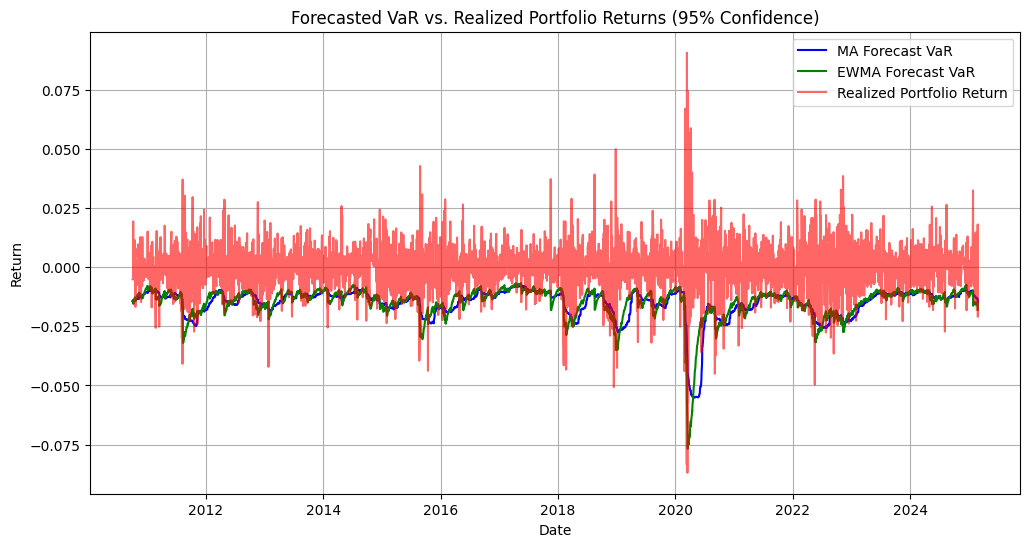

In [ ]:
from scipy.stats import norm, chi2

# ----------------------------
# Set Parameters and Portfolio Weights
# ----------------------------
alpha = 0.05  # 95% confidence level (5% tail)
# For a standard normal, VaR is computed as VaR = norm.ppf(alpha)*sigma.
# Since norm.ppf(0.05) is about -1.645, this VaR will be negative, meaning that returns
# below this negative threshold are “violations.”
z_alpha = norm.ppf(alpha)  # approximately -1.645
# For Expected Shortfall (ES) under normality:
ES_multiplier = norm.pdf(z_alpha) / alpha  # approximately 2.0627
# For clarity, we define ES (which is also a negative number) as:
# ES = -ES_multiplier * sigma

# Assume an equally weighted portfolio for our 3 stocks:
weights = np.array([1/3, 1/3, 1/3])

# ----------------------------
# Function to Forecast Risk Measures from a Covariance Dictionary
# ----------------------------
def forecast_risk_measures(cov_dict, returns, weights, alpha=0.05):
    """
    Given a dictionary of forecast covariance matrices (keyed by date),
    the realized returns DataFrame, and portfolio weights,
    compute daily forecast VaR and Expected Shortfall and match with realized portfolio returns.

    Returns a DataFrame indexed by forecast date with columns:
    - Forecast_VaR : the 95% VaR (negative number)
    - Forecast_ES  : the Expected Shortfall (negative number)
    - Realized_Return: the realized portfolio return on that day.
    """
    forecast_dates = []
    forecast_VaR = []
    forecast_ES = []
    realized_portfolio_returns = []

    # Loop over sorted forecast dates
    for date in sorted(cov_dict.keys()):
        # forecast covariance matrix (for a given day computed using historical returns)
        cov_mat = cov_dict[date]
        # Compute portfolio volatility (sigma_p)
        sigma_p = np.sqrt(np.dot(weights, np.dot(cov_mat, weights)))

        # Forecast VaR (using the normal assumption)
        # VaR = norm.ppf(alpha)*sigma_p (this is negative because norm.ppf(0.05) ≈ -1.645)
        VaR_forecast = norm.ppf(alpha) * sigma_p

        # Forecast ES (Expected Shortfall). Under normality:
        # ES = - (norm.pdf(norm.ppf(alpha)) / alpha) * sigma_p, which is a negative number.
        ES_forecast = - (norm.pdf(norm.ppf(alpha)) / alpha) * sigma_p

        # Get the realized portfolio return for the forecast date (if available)
        # Realized portfolio return: weighted sum of individual asset returns.
        if date in returns.index:
            realized_ret = np.dot(weights, returns.loc[date].values)
        else:
            continue  # skip dates not in the realized returns index

        forecast_dates.append(date)
        forecast_VaR.append(VaR_forecast)
        forecast_ES.append(ES_forecast)
        realized_portfolio_returns.append(realized_ret)

    df_forecast = pd.DataFrame({
        "Forecast_VaR": forecast_VaR,
        "Forecast_ES": forecast_ES,
        "Realized_Return": realized_portfolio_returns
    }, index=forecast_dates)

    return df_forecast

# ----------------------------
# Example: Using Pre-Computed Covariance Dictionaries
# Assume `ma_cov` and `ewma_cov` are dictionaries from your earlier analysis.
# Also assume that `returns` is your DataFrame of daily log returns for AAPL, JNJ, and WMT.
# (If you haven’t computed these yet, refer to the earlier code that calculates these models.)

# For Moving Average and EWMA models:
ma_forecast_df = forecast_risk_measures(ma_cov, returns, weights, alpha)
ewma_forecast_df = forecast_risk_measures(ewma_cov, returns, weights, alpha)

# ----------------------------
# Kupiec Test Implementation for Unconditional Coverage
# ----------------------------
def kupiec_test(realized_returns, VaR_forecasts, alpha=0.05):
    """
    Performs the Kupiec likelihood ratio test for unconditional coverage.

    Parameters:
        realized_returns : Series of realized portfolio returns.
        VaR_forecasts    : Series of forecast VaR thresholds (negative numbers).
        alpha            : The tail probability (e.g., 0.05 for 95% confidence).

    Returns:
        LR_uc: Kupiec test statistic,
        p_value: p-value for the test,
        violations: the number of violations,
        n: total number of observations.
    """
    n = len(realized_returns)
    # A violation occurs if the realized return is less than the forecast VaR.
    violations = np.sum(realized_returns < VaR_forecasts)
    pi = violations / n

    # Avoid issues with log(0) by enforcing a minimum value:
    if violations == 0 or violations == n:
        LR_uc = np.nan
        p_value = np.nan
    else:
        # Compute log of the likelihood terms for both the hypothesized and empirical probabilities
        log_term1 = (n - violations) * np.log(1 - alpha) + violations * np.log(alpha)
        log_term2 = (n - violations) * np.log(1 - pi) + violations * np.log(pi)

        # Kupiec likelihood ratio statistic in log scale
        LR_uc = -2 * (log_term1 - log_term2)
        p_value = 1 - chi2.cdf(LR_uc, df=1)

    return LR_uc, p_value, violations, n

# ----------------------------
# Evaluate Model Performance using the Kupiec Test
# ----------------------------
# For the MA model forecasts:
LR_uc_ma, p_value_ma, violations_ma, n_ma = kupiec_test(ma_forecast_df["Realized_Return"], ma_forecast_df["Forecast_VaR"], alpha)
print("Moving Average (MA) Model Kupiec Test Results:")
print(f"Violations: {violations_ma} out of {n_ma} observations")
print(f"LR Statistic: {LR_uc_ma:.4f}, p-value: {p_value_ma:.4f}")

# For the EWMA model forecasts:
LR_uc_ewma, p_value_ewma, violations_ewma, n_ewma = kupiec_test(ewma_forecast_df["Realized_Return"], ewma_forecast_df["Forecast_VaR"], alpha)
print("\nEWMA Model Kupiec Test Results:")
print(f"Violations: {violations_ewma} out of {n_ewma} observations")
print(f"LR Statistic: {LR_uc_ewma:.4f}, p-value: {p_value_ewma:.4f}")

# ----------------------------
# Visual Comparison: Forecasted VaR vs. Realized Portfolio Returns
# ----------------------------

fig, ax = plt.subplots(figsize=(12, 6))
# Plot forecast VaR for MA model
ax.plot(ma_forecast_df.index, ma_forecast_df["Forecast_VaR"], label="MA Forecast VaR", color="blue")
# Plot forecast VaR for EWMA model
ax.plot(ewma_forecast_df.index, ewma_forecast_df["Forecast_VaR"], label="EWMA Forecast VaR", color="green")
# Plot realized portfolio returns (using MA forecast dates as an example; they are similar in timing)
ax.plot(ma_forecast_df.index, ma_forecast_df["Realized_Return"],
        label="Realized Portfolio Return", color="red", alpha=0.6)

ax.set_title("Forecasted VaR vs. Realized Portfolio Returns (95% Confidence)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

def christoffersen_tests(violations, alpha=0.05):
    """
    Performs Christoffersen's (1998) tests for:
      1) Unconditional coverage (UC),
      2) Independence (IND), and
      3) Joint coverage + independence (CC).

    Parameters:
    -----------
    violations : array-like of 0s and 1s
        1 indicates a VaR violation (realized return < VaR threshold), 0 otherwise.
    alpha : float
        Nominal tail probability (e.g., 0.05 for 95% VaR).

    Returns:
    --------
    results : dict
        A dictionary containing the test statistics and p-values for:
        - "UC" : Unconditional coverage test
        - "IND": Independence test
        - "CC" : Joint (conditional coverage) test
    """
    # Convert violations to a NumPy array (in case it's not already)
    violations = np.array(violations, dtype=int)
    n = len(violations)

    # -------------------------------------------
    # 1) Unconditional Coverage Test (UC)
    # -------------------------------------------
    # Empirical violation rate:
    pi_hat = np.mean(violations)
    # Number of observed violations
    num_viol = np.sum(violations)

    # Log-likelihood under the null: i.i.d. Bernoulli with p = alpha
    # L0(UC) = (1 - alpha)^(n - num_viol) * alpha^(num_viol)
    # logL0(UC) =
    logL0_UC = (n - num_viol) * np.log(1 - alpha) + num_viol * np.log(alpha)

    # Log-likelihood under the alternative: i.i.d. Bernoulli with p = pi_hat
    # L1(UC) = (1 - pi_hat)^(n - num_viol) * pi_hat^(num_viol)
    # logL1(UC) =
    if 0 < pi_hat < 1:
        logL1_UC = (n - num_viol) * np.log(1 - pi_hat) + num_viol * np.log(pi_hat)
        # Likelihood ratio statistic
        LR_UC = -2 * (logL0_UC - logL1_UC)
        pval_UC = 1 - chi2.cdf(LR_UC, df=1)
    else:
        # Edge case: all violations or none
        LR_UC = np.nan
        pval_UC = np.nan

    # -------------------------------------------
    # 2) Independence Test (IND)
    # -------------------------------------------
    # Count transitions:
    # T_ij = number of times we see a transition from i to j in consecutive days
    # We'll define H_{-1} as None, and only count transitions from t=1..n-1 to t=2..n
    T_00 = T_01 = T_10 = T_11 = 0
    for t in range(1, n):
        i = violations[t-1]
        j = violations[t]
        if i == 0 and j == 0:
            T_00 += 1
        elif i == 0 and j == 1:
            T_01 += 1
        elif i == 1 and j == 0:
            T_10 += 1
        elif i == 1 and j == 1:
            T_11 += 1

    # MLE for the Markov chain transition probabilities
    # pi_01 = T_01 / (T_00 + T_01)
    # pi_11 = T_11 / (T_10 + T_11)
    denom_0 = T_00 + T_01
    denom_1 = T_10 + T_11

    if denom_0 > 0:
        pi_01 = T_01 / denom_0
    else:
        pi_01 = np.nan

    if denom_1 > 0:
        pi_11 = T_11 / denom_1
    else:
        pi_11 = np.nan

    # Markov chain log-likelihood
    # logL(MC) =
    # T_00*log(1-pi_01) + T_01*log(pi_01) + T_10*log(1-pi_11) + T_11*log(pi_11)
    def safe_logprob(x, count):
        # Helper to avoid log(0) issues
        return count * np.log(x) if x > 0 else (0 if count == 0 else -np.inf)

    logL_MC = 0.0
    logL_MC += safe_logprob(1 - pi_01, T_00)
    logL_MC += safe_logprob(pi_01, T_01)
    logL_MC += safe_logprob(1 - pi_11, T_10)
    logL_MC += safe_logprob(pi_11, T_11)

    # Under the simpler model: i.i.d. with parameter pi_hat
    # logL(i.i.d. with p=pi_hat) =
    # T_0*log(1-pi_hat) + T_1*log(pi_hat)
    # where T_0 = T_00 + T_01, T_1 = T_10 + T_11
    T_0 = denom_0
    T_1 = denom_1
    if 0 < pi_hat < 1:
        logL_iid = safe_logprob(1 - pi_hat, T_0) + safe_logprob(pi_hat, T_1)
        LR_IND = -2 * (logL_iid - logL_MC)
        pval_IND = 1 - chi2.cdf(LR_IND, df=1)
    else:
        LR_IND = np.nan
        pval_IND = np.nan

    # -------------------------------------------
    # 3) Joint Test (Conditional Coverage, CC)
    # -------------------------------------------
    # Compare the Markov chain model log-likelihood (logL_MC)
    # with the null model: i.i.d. with parameter alpha (logL0_UC).
    if 0 < alpha < 1:
        LR_CC = -2 * (logL0_UC - logL_MC)
        pval_CC = 1 - chi2.cdf(LR_CC, df=2)  # 2 degrees of freedom
    else:
        LR_CC = np.nan
        pval_CC = np.nan

    # Collect results
    results = {
        "UC": {"LR_stat": LR_UC,  "p_value": pval_UC},
        "IND": {"LR_stat": LR_IND, "p_value": pval_IND},
        "CC": {"LR_stat": LR_CC,  "p_value": pval_CC}
    }
    return results

# -------------------------------------------------------------------------
# EXAMPLE USAGE:
# Suppose we have a Series or array of violations (0/1) for each day.
# Let's say 'violations' is derived by checking if realized_return < forecasted_VaR.
# Then we call:
#
alpha = 0.05
test_results = christoffersen_tests(ma_forecast_df["Realized_Return"] < ma_forecast_df["Forecast_VaR"], alpha)
print("Unconditional Coverage Test (UC):", test_results["UC"])
print("Independence Test (IND):", test_results["IND"])
print("Conditional Coverage Test (CC):", test_results["CC"])
# -------------------------------------------------------------------------


Unconditional Coverage Test (UC): {'LR_stat': np.float64(4.287421530749725), 'p_value': np.float64(0.03839535268194649)}
Independence Test (IND): {'LR_stat': np.float64(5.027203126364157), 'p_value': np.float64(0.024952162011757206)}
Conditional Coverage Test (CC): {'LR_stat': np.float64(9.433426447429838), 'p_value': np.float64(0.008944528953555131)}


### Choosing optimal MA model

In [ ]:
# Set parameters
window = 252

# Compute covariance matrices
ma_cov = moving_average_covariance(demeaned_returns, window)

alpha = 0.05  # 95% confidence level (5% tail)
z_alpha = norm.ppf(alpha)  # approximately -1.645
ES_multiplier = norm.pdf(z_alpha) / alpha  # approximately 2.0627
# For clarity, we define ES (which is also a negative number) as:
# ES = -ES_multiplier * sigma

# Assume an equally weighted portfolio for our 3 stocks:
weights = np.array([1/3, 1/3, 1/3])

ma_forecast_df = forecast_risk_measures(ma_cov, demeaned_returns, weights, alpha)

# For the MA model forecasts:
LR_uc_ma, p_value_ma, violations_ma, n_ma = kupiec_test(ma_forecast_df["Realized_Return"], ma_forecast_df["Forecast_VaR"], alpha)
print("MA Model Kupiec Test Results:")
print(f"Violations: {violations_ma} out of {n_ma} observations")
print(f"LR Statistic: {LR_uc_ma:.4f}, p-value: {p_value_ma:.4f}")

MA Model Kupiec Test Results:
Violations: 188 out of 3435 observations
LR Statistic: 1.5722, p-value: 0.2099


In [ ]:
alpha = 0.05
test_results = christoffersen_tests(ma_forecast_df["Realized_Return"] < ma_forecast_df["Forecast_VaR"], alpha)
print("Unconditional Coverage Test (UC):", test_results["UC"])
print("Independence Test (IND):", test_results["IND"])
print("Conditional Coverage Test (CC):", test_results["CC"])

Unconditional Coverage Test (UC): {'LR_stat': np.float64(1.5722186791870172), 'p_value': np.float64(0.20988510006212313)}
Independence Test (IND): {'LR_stat': np.float64(9.890188538657185), 'p_value': np.float64(0.0016616234379726036)}
Conditional Coverage Test (CC): {'LR_stat': np.float64(11.574978082951247), 'p_value': np.float64(0.0030656702910656364)}


In [ ]:
# For demonstration, print the last computed covariance matrix from each model:
last_date_ma = list(ma_cov.keys())[-1]
print("Moving Average Covariance on", last_date_ma)
print(ma_cov[last_date_ma])
print("\n" + "="*60 + "\n")
last_date_ewma = list(ewma_cov.keys())[-1]
print("EWMA Covariance on", last_date_ewma)
print(ewma_cov[last_date_ewma])

Moving Average Covariance on 2025-02-27 00:00:00
[[ 2.26140650e-04 -6.09964995e-06  1.33072804e-05]
 [-6.09964995e-06  1.07327775e-04  1.50491373e-05]
 [ 1.33072804e-05  1.50491373e-05  1.53895691e-04]]


EWMA Covariance on 2025-02-27 00:00:00
[[2.51333685e-04 4.50307007e-05 4.09911481e-05]
 [4.50307007e-05 1.55433210e-04 2.18036509e-05]
 [4.09911481e-05 2.18036509e-05 4.59150148e-04]]


### Choosing optimal EWMA



Best lambda is pretty high, so the model does not discount the information too much and uses most of the info from the previous steps.

In [ ]:
# Set parameters
window = 22
lam = 0.998     # Decay factor for EWMA
ewma_cov = ewma_covariance(demeaned_returns, lam, window)
weights = np.array([1/3, 1/3, 1/3])
ewma_forecast_df = forecast_risk_measures(ewma_cov, demeaned_returns, weights, alpha)
LR_uc_ewma, p_value_ewma, violations_ewma, n_ewma = kupiec_test(ewma_forecast_df["Realized_Return"], ewma_forecast_df["Forecast_VaR"], alpha)
print("EWMA Model Kupiec Test Results:")
print(f"Violations: {violations_ewma} out of {n_ewma} observations")
print(f"LR Statistic: {LR_uc_ewma:.4f}, p-value: {p_value_ewma:.4f}")

EWMA Model Kupiec Test Results:
Violations: 181 out of 3626 observations
LR Statistic: 0.0005, p-value: 0.9818


In [ ]:
# Set parameters
window = 22
lam = 0.9991     # Decay factor for EWMA
ewma_cov = ewma_covariance(demeaned_returns, lam, window)
weights = np.array([1/3, 1/3, 1/3])
ewma_forecast_df = forecast_risk_measures(ewma_cov, demeaned_returns, weights, alpha)
LR_uc_ewma, p_value_ewma, violations_ewma, n_ewma = kupiec_test(ewma_forecast_df["Realized_Return"], ewma_forecast_df["Forecast_VaR"], alpha)
print("EWMA Model Kupiec Test Results:")
print(f"Violations: {violations_ewma} out of {n_ewma} observations")
print(f"LR Statistic: {LR_uc_ewma:.4f}, p-value: {p_value_ewma:.4f}")

EWMA Model Kupiec Test Results:
Violations: 186 out of 3626 observations
LR Statistic: 0.1272, p-value: 0.7213


In [ ]:
alpha = 0.05
test_results = christoffersen_tests(ewma_forecast_df["Realized_Return"] < ewma_forecast_df["Forecast_VaR"], alpha)
print("Unconditional Coverage Test (UC):", test_results["UC"])
print("Independence Test (IND):", test_results["IND"])
print("Conditional Coverage Test (CC):", test_results["CC"])

Unconditional Coverage Test (UC): {'LR_stat': np.float64(0.0005228151530900504), 'p_value': np.float64(0.9817578381985029)}
Independence Test (IND): {'LR_stat': np.float64(9.518716465383477), 'p_value': np.float64(0.0020338678572588975)}
Conditional Coverage Test (CC): {'LR_stat': np.float64(9.621651696270646), 'p_value': np.float64(0.008141133580699678)}


### Visual Comparison EWMA and MA

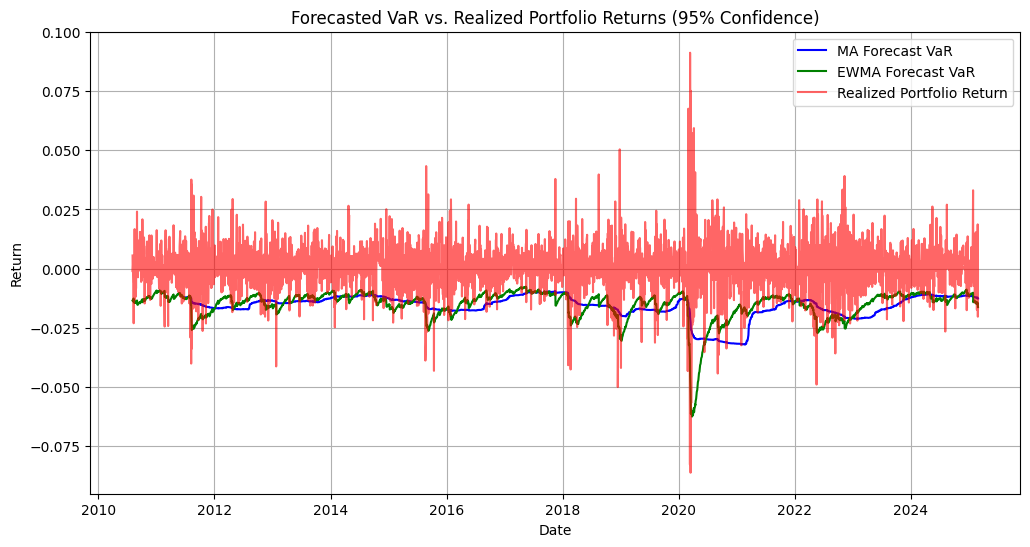

In [ ]:
# ----------------------------
# Visual Comparison: Forecasted VaR vs. Realized Portfolio Returns
# ----------------------------

fig, ax = plt.subplots(figsize=(12, 6))
# Plot forecast VaR for MA model
ax.plot(ma_forecast_df.index, ma_forecast_df["Forecast_VaR"], label="MA Forecast VaR", color="blue")
# Plot forecast VaR for EWMA model
ax.plot(ewma_forecast_df.index, ewma_forecast_df["Forecast_VaR"], label="EWMA Forecast VaR", color="green")
# Plot realized portfolio returns (using MA forecast dates as an example; they are similar in timing)
ax.plot(ewma_forecast_df.index, ewma_forecast_df["Realized_Return"],
        label="Realized Portfolio Return", color="red", alpha=0.6)

ax.set_title("Forecasted VaR vs. Realized Portfolio Returns (95% Confidence)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.show()


# Observable factor covariance

### Fama-French factors (bad results)

In [ ]:
# -------------------------------
# 1. Mount Google Drive and Load Factors
# -------------------------------
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm, chi2

# Download asset data for AAPL, JNJ, WMT
tickers = ["AAPL", "JNJ", "WMT"]
start_date = "2010-07-01"
end_date   = "2024-12-31"
asset_prices = yf.download(tickers, start=start_date, end=end_date)["Close"]

# Compute daily log returns for tickers
asset_returns = np.log(asset_prices).diff().dropna()

demeaned_returns = asset_returns.copy()
for ticker in returns.columns:
    # Compute the expanding mean and shift it so that at time t, it uses data from before t.
    expanding_mean = returns[ticker].expanding().mean().shift(1)
    # Subtract the expanding mean from the current return; fill the first value (NaN) with 0.
    demeaned_returns[ticker] = returns[ticker] - expanding_mean.fillna(0)

asset_returns = demeaned_returns.copy()

# Read Fama-French factors CSV from Google Drive.
factors = pd.read_csv('/content/drive/MyDrive/FE_projects/F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3)

# The snippet below aligns the factors with the asset returns.
# Here we assume that the number of rows in asset_returns is L.
L = len(asset_returns)
# Select the last L rows (adjust the slice as needed based on your file format)
factors = factors.iloc[-(L+2):-1,:].reset_index(drop=True)

# (Optional) Convert factor values from percentages to decimals.
for col in ["Mkt-RF", "SMB", "HML", "CMA"]:
    factors[col] = pd.to_numeric(factors[col], errors='coerce') / 100.0

# Create a DataFrame that contains the asset returns and these factors.
# We reset the index of asset_returns and then add the factor columns.
data = asset_returns.copy().reset_index(drop=True)
data["Mkt-RF"] = factors["Mkt-RF"]
data["SMB"]    = factors["SMB"]
data["HML"]    = factors["HML"]
data["CMA"]    = factors["CMA"]
# data["VIX"] = np.log(yf.download("VIX", start=start_date, end=end_date)["Close"]).reset_index(drop=True)

# Preserve the original Date index for later mapping (from asset_returns)
dates = asset_returns.index

Mounted at /content/drive


[*********************100%***********************]  3 of 3 completed


In [ ]:
data = asset_returns.copy().reset_index(drop=True)
data["Mkt-RF"] = factors["Mkt-RF"]
data["SMB"]    = factors["SMB"]
data["HML"]    = factors["HML"]
data["CMA"]    = factors["CMA"]

In [ ]:
# -------------------------------
# 2. Estimate the Multifactor Observable Factor Covariance
# -------------------------------
def observable_factor_covariance_multifactor(data, tickers, factor_cols, window=22):
    """
    Estimate a rolling time series of forecast covariance matrices using a multi-factor model.

    For each asset i, we assume:
       r_i,t = alpha_i + sum_k beta_{i,k} * f_{k,t} + epsilon_i,t,
    where f_{k,t} are the observable factor returns.

    The covariance matrix is constructed as:
       For i != j:  Sigma_ij = beta_i^T * Cov(factors) * beta_j,
       For i == j:  Sigma_ii = beta_i^T * Cov(factors) * beta_i + sigma^2_{epsilon,i}.

    Parameters:
      data       : DataFrame containing asset returns and factor columns.
      tickers     : List of asset return column names.
      factor_cols: List of factor column names.
      window     : Rolling window length for parameter estimation.

    Returns:
      cov_dict : Dictionary keyed by forecast date (using the original date index)
                 containing the estimated covariance matrix (np.array).
    """
    cov_dict = {}
    # Loop over dates starting at 'window'
    for t in range(window, len(data)):
        forecast_date = dates[t]  # use the original asset_returns dates
        window_data = data.iloc[t-window:t]

        # Prepare regressors: factor columns with constant added
        X = window_data[factor_cols]
        X = sm.add_constant(X)

        beta_estimates = {}
        resid_vars = {}
        for asset in tickers:
            y = window_data[asset]
            model = sm.OLS(y, X).fit()
            # Extract estimated betas for factors (ignore constant)
            beta_estimates[asset] = model.params[factor_cols].values
            resid_vars[asset] = np.var(model.resid, ddof=1)

        # Estimate factor covariance matrix from the window (using the factor columns only)
        factor_cov = window_data[factor_cols].cov().values

        n_tickers = len(tickers)
        Sigma = np.zeros((n_tickers, n_tickers))
        for i in range(n_tickers):
            for j in range(n_tickers):
                beta_i = beta_estimates[tickers[i]]
                beta_j = beta_estimates[tickers[j]]
                systematic = np.dot(np.dot(beta_i, factor_cov), beta_j)
                if i == j:
                    Sigma[i, i] = systematic + resid_vars[tickers[i]]
                else:
                    Sigma[i, j] = systematic
        cov_dict[forecast_date] = Sigma
    return cov_dict

In [ ]:
def forecast_risk_measures(cov_dict, returns, weights, alpha=0.05):
    """
    Given a dictionary of forecast covariance matrices keyed by date,
    compute the forecast portfolio standard deviation, VaR, and Expected Shortfall (ES)
    under the assumption of normally distributed returns.

    It then matches the forecasts with the realized portfolio return for that date.
    Returns a DataFrame with Forecast_VaR, Forecast_ES, and Realized_Return.
    """
    forecast_dates = []
    forecast_VaR = []
    forecast_ES = []
    realized_portfolio_returns = []

    for date in sorted(cov_dict.keys()):
        Sigma = cov_dict[date]
        portfolio_std = np.sqrt(np.dot(weights, np.dot(Sigma, weights)))

        # VaR forecast (normal quantile)
        VaR = norm.ppf(alpha) * portfolio_std
        # Expected Shortfall forecast under normality:
        ES  = - (norm.pdf(norm.ppf(alpha)) / alpha) * portfolio_std

        # Get realized portfolio return for the same date (if available)
        if date in asset_returns.index:
            realized_ret = np.dot(weights, asset_returns.loc[date].values)
        else:
            continue

        forecast_dates.append(date)
        forecast_VaR.append(VaR)
        forecast_ES.append(ES)
        realized_portfolio_returns.append(realized_ret)

    forecast_df = pd.DataFrame({
        "Forecast_VaR": forecast_VaR,
        "Forecast_ES": forecast_ES,
        "Realized_Return": realized_portfolio_returns
    }, index=forecast_dates)
    return forecast_df


# -------------------------------
# 4. Backtesting with the Kupiec Test (Log-Domain)
# -------------------------------
def kupiec_test_log(realized_returns, VaR_forecasts, alpha=0.05):
    """
    Performs the Kupiec likelihood ratio test for unconditional coverage in the log domain.

    Parameters:
      realized_returns: Series of realized portfolio returns.
      VaR_forecasts   : Series of forecast VaR values (negative numbers).
      alpha           : Tail probability (e.g., 0.05 for 95% confidence).

    Returns:
      LR_uc   : Kupiec test statistic.
      p_value : p-value for the test.
      violations: Number of VaR violations.
      n       : Total number of observations.
    """
    n = len(realized_returns)
    # A violation: observed return is less than the forecast VaR.
    violations = np.sum(realized_returns < VaR_forecasts)
    pi = violations / n  # empirical violation rate

    if violations == 0 or violations == n:
        LR_uc = np.nan
        p_value = np.nan
    else:
        log_term_null = (n - violations)*np.log(1-alpha) + violations*np.log(alpha)
        log_term_emp  = (n - violations)*np.log(1-pi)   + violations*np.log(pi)
        LR_uc = -2 * (log_term_null - log_term_emp)
        p_value = 1 - chi2.cdf(LR_uc, df=1)

    return LR_uc, p_value, violations, n



#### Window 66

In [ ]:
# Define the factors to use from Fama-French
factor_cols = ["Mkt-RF", "SMB", "HML", "CMA"] # , "VIX"

# Estimate covariance matrices using a 63-day rolling window
of_multi_cov = observable_factor_covariance_multifactor(data, tickers, factor_cols, window=66)

# -------------------------------
# 3. Forecast VaR and Expected Shortfall
# -------------------------------
# Set parameters for the risk forecast.
alpha_level = 0.05
weights = np.array([1/3, 1/3, 1/3])  # equally weighted portfolio

# Compute forecast risk measures using the observable factor covariance model with multiple factors
of_multi_forecast_df = forecast_risk_measures(of_multi_cov, asset_returns, weights, alpha=alpha_level)

# Evaluate the model forecasts using the Kupiec test
LR_uc_of_multi, p_val_of_multi, viol_of_multi, n_of_multi = kupiec_test_log(
    of_multi_forecast_df["Realized_Return"], of_multi_forecast_df["Forecast_VaR"], alpha=alpha_level)

print("Multifactor Observable Factor Covariance Model - Kupiec Test Results")
print(f"Violations: {viol_of_multi} out of {n_of_multi} observations")
print(f"LR Statistic: {LR_uc_of_multi:.4f}, p-value: {p_val_of_multi:.4f}")

Multifactor Observable Factor Covariance Model - Kupiec Test Results
Violations: 282 out of 3582 observations
LR Statistic: 53.3784, p-value: 0.0000


#### Window 22

In [ ]:
of_multi_cov = observable_factor_covariance_multifactor(data, tickers, factor_cols, window=22)
of_multi_forecast_df = forecast_risk_measures(of_multi_cov, asset_returns, weights, alpha=alpha_level)
LR_uc_of_multi, p_val_of_multi, viol_of_multi, n_of_multi = kupiec_test_log(
    of_multi_forecast_df["Realized_Return"], of_multi_forecast_df["Forecast_VaR"], alpha=alpha_level)

print("Multifactor Observable Factor Covariance Model - Kupiec Test Results")
print(f"Violations: {viol_of_multi} out of {n_of_multi} observations")
print(f"LR Statistic: {LR_uc_of_multi:.4f}, p-value: {p_val_of_multi:.4f}")

Multifactor Observable Factor Covariance Model - Kupiec Test Results
Violations: 0 out of 0 observations
LR Statistic: nan, p-value: nan


<ipython-input-175-dc3d7613a6f8>:64: RuntimeWarning: invalid value encountered in scalar divide
  pi = violations / n  # empirical violation rate


#### Window 252

In [ ]:
of_multi_forecast_df

,Forecast_VaR,Forecast_ES,Realized_Return
2011-07-01,-0.009895,-0.012409,0.013371
2011-07-05,-0.009935,-0.012459,0.006387
2011-07-06,-0.009889,-0.012402,0.003491
2011-07-07,-0.009773,-0.012256,0.011222
2011-07-08,-0.009754,-0.012232,-0.002451
...,...,...,...
2024-12-23,-0.010997,-0.013790,-0.004598
2024-12-24,-0.011028,-0.013830,0.013064
2024-12-26,-0.011059,-0.013869,0.000272
2024-12-27,-0.011057,-0.013866,-0.010306


In [ ]:
factor_cols = ["Mkt-RF", "SMB", "HML", "CMA"] # , "VIX"
of_multi_cov = observable_factor_covariance_multifactor(data, tickers, factor_cols, window=252)
of_multi_forecast_df = forecast_risk_measures(of_multi_cov, asset_returns, weights, alpha=alpha_level)
LR_uc_of_multi, p_val_of_multi, viol_of_multi, n_of_multi = kupiec_test_log(
    of_multi_forecast_df["Realized_Return"], of_multi_forecast_df["Forecast_VaR"], alpha=alpha_level)

print("Multifactor Observable Factor Covariance Model - Kupiec Test Results")
print(f"Violations: {viol_of_multi} out of {n_of_multi} observations")
print(f"LR Statistic: {LR_uc_of_multi:.4f}, p-value: {p_val_of_multi:.4f}")

Multifactor Observable Factor Covariance Model - Kupiec Test Results
Violations: 258 out of 3396 observations
LR Statistic: 41.8961, p-value: 0.0000


In [ ]:
# For demonstration, print the last computed covariance matrix from each model:
last_date_ma = list(of_multi_cov.keys())[-1]
print("Moving Average Covariance on", last_date_ma)
print(of_multi_cov[last_date_ma])

Moving Average Covariance on 2024-12-30 00:00:00
[[ 2.01767124e-04 -2.42224892e-06 -3.63766709e-07]
 [-2.42224892e-06  8.94992838e-05  7.55547047e-07]
 [-3.63766709e-07  7.55547047e-07  1.20902723e-04]]


On window 22

In [ ]:
alpha = 0.05
test_results = christoffersen_tests(of_multi_forecast_df["Realized_Return"] < of_multi_forecast_df["Forecast_VaR"], alpha)
print("Unconditional Coverage Test (UC):", test_results["UC"])
print("Independence Test (IND):", test_results["IND"])
print("Conditional Coverage Test (CC):", test_results["CC"])

Unconditional Coverage Test (UC): {'LR_stat': np.float64(53.378428557166444), 'p_value': np.float64(2.751132655021138e-13)}
Independence Test (IND): {'LR_stat': np.float64(-1.8995724016936038), 'p_value': np.float64(1.0)}
Conditional Coverage Test (CC): {'LR_stat': np.float64(56.56239517883796), 'p_value': np.float64(5.219158438762861e-13)}


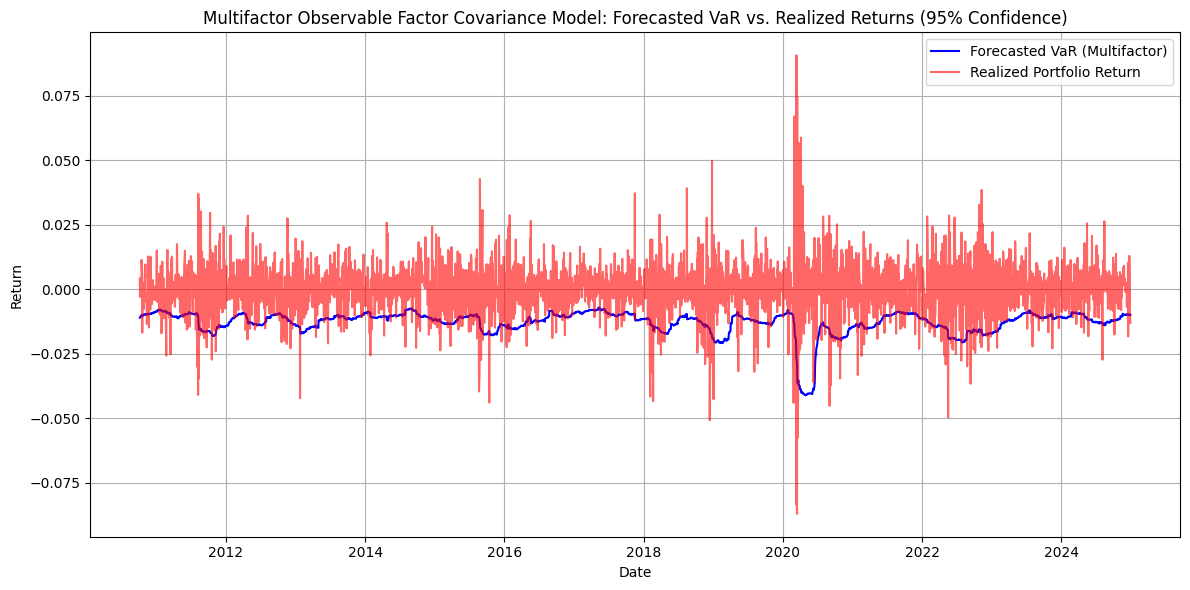

In [ ]:
# -------------------------------
# 5. Visual Comparison
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(of_multi_forecast_df.index, of_multi_forecast_df["Forecast_VaR"], label="Forecasted VaR (Multifactor)", color="blue")
ax.plot(of_multi_forecast_df.index, of_multi_forecast_df["Realized_Return"], label="Realized Portfolio Return", color="red", alpha=0.6)
ax.set_title("Multifactor Observable Factor Covariance Model: Forecasted VaR vs. Realized Returns (95% Confidence)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# For demonstration, print the last computed covariance matrix from each model:
last_date_ma = list(ma_cov.keys())[-1]
print("Moving Average Covariance on", last_date_ma)
print(ma_cov[last_date_ma])
print("\n" + "="*60 + "\n")
last_date_ewma = list(ewma_cov.keys())[-1]
print("EWMA Covariance on", last_date_ewma)
print(ewma_cov[last_date_ewma])

## Observable factors with PCA

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, chi2
import requests
from bs4 import BeautifulSoup

# =============================================================================
# 1. Download Data for a Broad Universe (Using S&P 500 as a Proxy for NYSE)
# =============================================================================
# Scrape the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
html = requests.get(url).text
soup = BeautifulSoup(html, 'lxml')
table = soup.find('table', {'id': 'constituents'})
sp500_df = pd.read_html(str(table))[0]
sp500_tickers = sp500_df['Symbol'].tolist()

# Download daily adjusted close prices for the S&P 500 (for a recent period)
# Adjust the start/end dates as needed. Here we use a 5-year period.
broad_prices = yf.download(sp500_tickers, start="2010-07-01", end="2024-12-31")["Close"]
# broad_returns = broad_returns.loc[broad_returns.index >= "2010-07-01"]

# drop columns from broad_prices is it has na
broad_prices = broad_prices.dropna(axis=1)
broad_returns = np.log(broad_prices).diff().dropna()

<ipython-input-75-6cf2eb56deb4>:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sp500_df = pd.read_html(str(table))[0]
[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-07-01 -> 2024-12-31)')


In [ ]:
for i in broad_returns.columns:
  print(i)

A
AAPL
ABT
ACGL
ACN
ADBE
ADI
ADM
ADP
ADSK
AEE
AEP
AES
AFL
AIG
AIZ
AJG
AKAM
ALB
ALGN
ALL
AMAT
AMD
AME
AMGN
AMP
AMT
AMZN
ANSS
AON
AOS
APA
APD
APH
ARE
ATO
AVB
AVGO
AVY
AWK
AXON
AXP
AZO
BA
BAC
BALL
BAX
BBY
BDX
BEN
BG
BIIB
BK
BKNG
BKR
BLDR
BLK
BMY
BR
BRO
BSX
BX
BXP
C
CAG
CAH
CAT
CB
CBOE
CBRE
CCI
CCL
CDNS
CF
CHD
CHRW
CHTR
CI
CINF
CL
CLX
CMCSA
CME
CMG
CMI
CMS
CNC
CNP
COF
COO
COP
COR
COST
CPB
CPRT
CPT
CRL
CRM
CSCO
CSGP
CSX
CTAS
CTRA
CTSH
CVS
CVX
D
DAL
DD
DE
DECK
DFS
DG
DGX
DHI
DHR
DIS
DLR
DLTR
DOC
DOV
DPZ
DRI
DTE
DUK
DVA
DVN
DXCM
EA
EBAY
ECL
ED
EFX
EG
EIX
EL
ELV
EMN
EMR
EOG
EQIX
EQR
EQT
ERIE
ES
ESS
ETN
ETR
EVRG
EW
EXC
EXPD
EXPE
EXR
F
FAST
FCX
FDS
FDX
FE
FFIV
FI
FICO
FIS
FITB
FRT
FSLR
FTNT
GD
GE
GEN
GILD
GIS
GL
GLW
GNRC
GOOG
GOOGL
GPC
GPN
GRMN
GS
GWW
HAL
HAS
HBAN
HD
HES
HIG
HOLX
HON
HPQ
HRL
HSIC
HST
HSY
HUBB
HUM
IBM
ICE
IDXX
IEX
IFF
INCY
INTC
INTU
IP
IPG
IRM
ISRG
IT
ITW
IVZ
J
JBHT
JBL
JCI
JKHY
JNJ
JNPR
JPM
K
KDP
KEY
KIM
KLAC
KMB
KMX
KO
KR
L
LDOS
LEN
LH
LHX
LII
LIN
LKQ
LLY
LMT
LNT
LOW
LRCX
LULU


Stationarity checks for all stocks used in PCA

In [ ]:
from statsmodels.tsa.stattools import adfuller

alpha = 0.05

# Dictionary to store final stationary series for each stock.
stationary_series = {}

# Iterate over each stock in the DataFrame.
for stock in broad_returns.columns:
    series = broad_returns[stock].dropna()

    # Run the Augmented Dickey-Fuller test
    result = adfuller(series)
    p_value = result[1]

    print(f"\nStock: {stock}")
    print(f"Initial ADF p-value: {p_value:.4f}")

    # Check if the series is stationary.
    if p_value < alpha:
        print(f"{stock} is stationary (p < {alpha}).")
        stationary_series[stock] = series
    else:
        print(f"{stock} is non-stationary (p >= {alpha}). Differencing the series...")
        # Difference the series once.
        series_diff = series.diff().dropna()
        # Run ADF on the differenced series.
        result_diff = adfuller(series_diff)
        p_value_diff = result_diff[1]
        print(f"After differencing, {stock} ADF p-value: {p_value_diff:.4f}")
        if p_value_diff < alpha:
            print(f"After differencing, {stock} is now stationary.")
        else:
            print(f"After differencing, {stock} is still non-stationary.")
        stationary_series[stock] = series_diff

# Convert the dictionary to a DataFrame for further analysis if desired.
stationary_df = pd.DataFrame(stationary_series)
print("\nStationary series (each column is a stock):")
print(stationary_df.head())


Stock: A
Initial ADF p-value: 0.0000
A is stationary (p < 0.05).

Stock: AAPL
Initial ADF p-value: 0.0000
AAPL is stationary (p < 0.05).

Stock: ABT
Initial ADF p-value: 0.0000
ABT is stationary (p < 0.05).

Stock: ACGL
Initial ADF p-value: 0.0000
ACGL is stationary (p < 0.05).

Stock: ACN
Initial ADF p-value: 0.0000
ACN is stationary (p < 0.05).

Stock: ADBE
Initial ADF p-value: 0.0000
ADBE is stationary (p < 0.05).

Stock: ADI
Initial ADF p-value: 0.0000
ADI is stationary (p < 0.05).

Stock: ADM
Initial ADF p-value: 0.0000
ADM is stationary (p < 0.05).

Stock: ADP
Initial ADF p-value: 0.0000
ADP is stationary (p < 0.05).

Stock: ADSK
Initial ADF p-value: 0.0000
ADSK is stationary (p < 0.05).

Stock: AEE
Initial ADF p-value: 0.0000
AEE is stationary (p < 0.05).

Stock: AEP
Initial ADF p-value: 0.0000
AEP is stationary (p < 0.05).

Stock: AES
Initial ADF p-value: 0.0000
AES is stationary (p < 0.05).

Stock: AFL
Initial ADF p-value: 0.0000
AFL is stationary (p < 0.05).

Stock: AIG
Init

Explained Variance Ratio for each component:
[3.78402466e-01 4.73085312e-02 3.22464099e-02 1.80862712e-02
 1.30907245e-02 1.15249639e-02 1.01675718e-02 9.46725952e-03
 8.56645914e-03 7.93542835e-03 6.84319232e-03 6.61742323e-03
 6.03763613e-03 5.20397227e-03 4.85889653e-03 4.59622675e-03
 4.38293574e-03 4.24967463e-03 4.03600862e-03 3.95841865e-03
 3.84741731e-03 3.66845638e-03 3.56551363e-03 3.45258657e-03
 3.36235923e-03 3.30422452e-03 3.20593811e-03 3.13757897e-03
 3.02897985e-03 2.98548287e-03 2.88804578e-03 2.85494373e-03
 2.76246465e-03 2.72554914e-03 2.66846230e-03 2.61202051e-03
 2.58498343e-03 2.52711584e-03 2.51512566e-03 2.48789295e-03
 2.44164717e-03 2.42457191e-03 2.38984803e-03 2.35445193e-03
 2.33726250e-03 2.33094596e-03 2.28654542e-03 2.27192533e-03
 2.24839310e-03 2.23769948e-03 2.20571182e-03 2.18215218e-03
 2.17717027e-03 2.14707399e-03 2.13593635e-03 2.09807745e-03
 2.08896134e-03 2.06275027e-03 2.05464412e-03 2.05181638e-03
 2.01394033e-03 1.98065464e-03 1.9743192

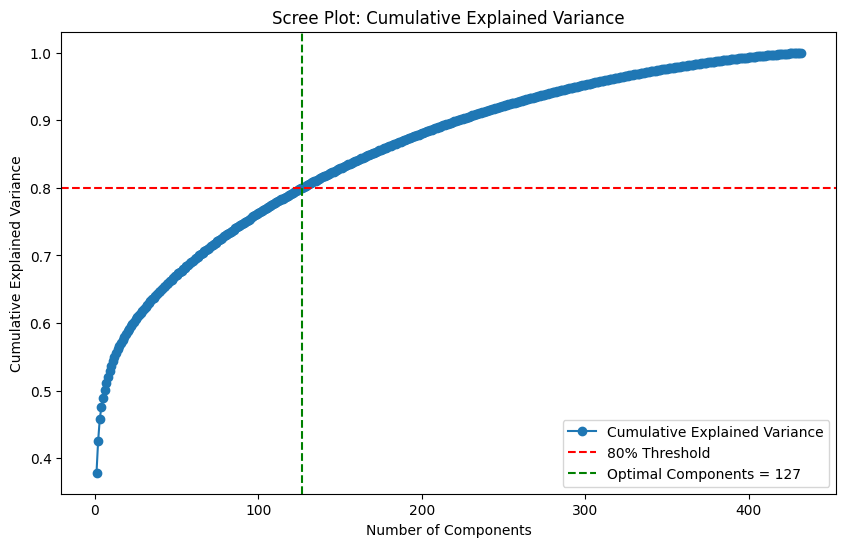


Loadings of the optimal PCA components (each column is a factor):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Ticker                                                                         
A       0.054885 -0.017868  0.066527 -0.029279  0.009198 -0.004562 -0.027499   
AAPL    0.045398 -0.019990  0.078985  0.014843  0.047165 -0.025643 -0.010182   
ABT     0.047878  0.035069  0.071651 -0.068192 -0.016928 -0.071278 -0.005719   
ACGL    0.051906  0.020707 -0.060096 -0.018757 -0.063629 -0.075335 -0.048990   
ACN     0.056923 -0.005509  0.052070 -0.007871 -0.001572 -0.030017 -0.023474   
...          ...       ...       ...       ...       ...       ...       ...   
XEL     0.041823  0.148964 -0.006762  0.030166  0.053542  0.016824 -0.063343   
XOM     0.049463 -0.022684 -0.098965 -0.049498  0.155006 -0.048721  0.044449   
YUM     0.048288  0.005907  0.012534  0.024971 -0.025678 -0.025247  0.062098   
ZBH     0.049565 -0.008504 -0.004636  0.009919 -0.010

In [ ]:
# -----------------------------------------------------------------------------
# 2. Run PCA on the Broad Universe Returns
# -----------------------------------------------------------------------------
# We run PCA on all available stocks. The PCA automatically centers the data.
scaled_returns = StandardScaler().fit_transform(broad_returns)
pca_full = PCA(n_components=scaled_returns.shape[1])
pca_full.fit(scaled_returns)

# Extract the variance explained by each component.
explained_variance = pca_full.explained_variance_ratio_
cumulative_explained = np.cumsum(explained_variance)

print("Explained Variance Ratio for each component:")
print(explained_variance)
print("\nCumulative Explained Variance:")
print(cumulative_explained)

# -----------------------------------------------------------------------------
# 3. Choose the Optimal Number of Components
# -----------------------------------------------------------------------------
# Use a threshold for cumulative explained variance (e.g., 80%).
threshold = 0.80
optimal_components = np.argmax(cumulative_explained >= threshold) + 1  # +1 because indices start at 0
print("\nOptimal number of PCA components (to explain at least 80% of variance):", optimal_components)

# Plot the scree plot (cumulative explained variance vs. number of components)
plt.figure(figsize=(10,6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained, marker="o", label="Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot: Cumulative Explained Variance")
plt.axhline(y=threshold, color='red', linestyle='--', label=f'{int(threshold*100)}% Threshold')
plt.axvline(x=optimal_components, color='green', linestyle='--', label=f'Optimal Components = {optimal_components}')
plt.legend()
plt.show()

# -----------------------------------------------------------------------------
# 4. Rerun PCA with the Optimal Number of Components and Analyze Loadings
# -----------------------------------------------------------------------------
pca_opt = PCA(n_components=optimal_components)
pca_opt.fit(scaled_returns)
# The principal components (eigenvectors) are stored in pca_opt.components_
# Each row corresponds to one principal component, so we take the transpose to have stocks as rows.
loadings = pca_opt.components_.T

# Create a DataFrame of loadings:
loadings_df = pd.DataFrame(loadings, index=broad_returns.columns,
                           columns=[f'PC{i+1}' for i in range(optimal_components)])
print("\nLoadings of the optimal PCA components (each column is a factor):")
print(loadings_df)

# -----------------------------------------------------------------------------
# 5. Interpretation: Identify Key Stocks for Each Factor
# -----------------------------------------------------------------------------
# For each principal component, we identify the stocks with the highest absolute loadings.
for i in range(optimal_components):
    comp = f'PC{i+1}'
    comp_loadings = loadings_df[comp]
    top_loadings = comp_loadings.abs().sort_values(ascending=False).head(10)
    print(f"\nTop 10 absolute loadings for {comp}:")
    print(top_loadings)

# -----------------------------------------------------------------------------
# 6. (Optional) Additional Analysis:
# You might correlate these PCA factors with common known factors or inspect
# the economic characteristics (e.g., size, industry) of stocks with high loadings.
# This further helps in interpreting what each PCA factor represents.
# -----------------------------------------------------------------------------


### 3 factors

Chose to have 3 components because of the marginal increase of the explained variance (could have taken more, because 80% of variance is explained by 127 first factors, and 49 factors have eigenvalues greater than 1, but it did not actually augment the performance of the factor model, so I decided to stick to 3).

In [ ]:
broad_returns.shape

(3648, 432)

In [ ]:
# =============================================================================
# 2. Perform PCA on Broad Universe Returns to Extract Factors
# =============================================================================
n_components = 3

# Run PCA to extract the first 3 principal components.
pca = PCA(n_components=n_components)
# It is common practice to center the data; PCA in scikit-learn automatically centers.
scaled_returns = StandardScaler().fit_transform(broad_returns)
pca_factors_array = pca.fit_transform(scaled_returns)

# Create a DataFrame for the PCA factors with the same date index.
pca_factors = pd.DataFrame(pca_factors_array, index=broad_returns.index, columns=[f'PC{i+1}' for i in range(n_components)])

# =============================================================================
# 3. Download Data for Your Target Portfolio and Merge with PCA Factors
# =============================================================================

target_returns = demeaned_returns.copy()
data = target_returns.join(pca_factors, how='inner')

In [ ]:
# =============================================================================
# 4. Observable Factor Covariance Model Using PCA Factors
# =============================================================================
def observable_factor_covariance_multifactor(data, assets, factor_cols, window=22):
    """
    Estimate a rolling time series of forecast covariance matrices using a multi-factor model.

    For each asset i, we assume:
         r_{i,t} = alpha_i + β_{i,1} f_{1,t} + β_{i,2} f_{2,t} + β_{i,3} f_{3,t} + ε_{i,t},
    where f_{k,t} are the factor returns (here, the PCA factors).

    The n-period factor covariance is computed as:
         Σ_t = β Σ_f,t β' + Ω_t,
    where Σ_f,t is the covariance of the factor returns over the window,
          β are the factor loadings estimated by OLS,
          and Ω_t is a diagonal matrix with the idiosyncratic variances.

    Parameters:
      data        : DataFrame that contains asset returns (for assets) and the factor columns.
      assets      : List of asset return column names.
      factor_cols : List of factor return column names.
      window      : Rolling window length.

    Returns:
      cov_dict : Dictionary keyed by forecast date with the estimated covariance matrix (np.array).
    """
    cov_dict = {}
    dates = data.index
    for t in range(window, len(data)):
        forecast_date = dates[t]
        window_data = data.iloc[t-window:t]
        X = window_data[factor_cols]
        X = sm.add_constant(X)  # add constant
        beta_estimates = {}
        resid_vars = {}

        for asset in assets:
            y = window_data[asset]
            model = sm.OLS(y, X).fit()
            # Extract estimated betas for the factors only (exclude constant)
            beta_estimates[asset] = model.params[factor_cols].values
            resid_vars[asset] = np.var(model.resid, ddof=1)

        # Compute covariance matrix for the factors over the window.
        factor_cov = window_data[factor_cols].cov().values

        n_assets = len(assets)
        Sigma = np.zeros((n_assets, n_assets))
        for i in range(n_assets):
            for j in range(n_assets):
                beta_i = beta_estimates[assets[i]]
                beta_j = beta_estimates[assets[j]]
                systematic = np.dot(np.dot(beta_i, factor_cov), beta_j)
                if i == j:
                    Sigma[i, i] = systematic + resid_vars[assets[i]]
                else:
                    Sigma[i, j] = systematic
        cov_dict[forecast_date] = Sigma
    return cov_dict

# =============================================================================
# 5. Forecast VaR and Expected Shortfall Using the PCA-Factor Covariance Forecasts
# =============================================================================
def forecast_risk_measures(cov_dict, returns, weights, alpha=0.05):
    """
    Using a dictionary of forecast covariance matrices, compute for each forecast date:
      - Portfolio forecast standard deviation.
      - VaR (at the specified tail probability assuming normality).
      - Expected Shortfall (under normality).
      - Match with the realized portfolio return.

    Returns:
       DataFrame with columns: Forecast_VaR, Forecast_ES, Realized_Return.
    """
    forecast_dates = []
    forecast_VaR = []
    forecast_ES = []
    realized_portfolio_returns = []

    for date in sorted(cov_dict.keys()):
        Sigma = cov_dict[date]
        portfolio_std = np.sqrt(np.dot(weights, np.dot(Sigma, weights)))

        # VaR forecast (e.g., norm.ppf(0.05) ≈ -1.645 for a 95% confidence level)
        VaR = norm.ppf(alpha) * portfolio_std
        # Expected Shortfall forecast under normality:
        ES = - (norm.pdf(norm.ppf(alpha)) / alpha) * portfolio_std

        # Get realized portfolio return for this forecast date.
        if date in target_returns.index:
            realized_ret = np.dot(weights, target_returns.loc[date].values)
        else:
            continue

        forecast_dates.append(date)
        forecast_VaR.append(VaR)
        forecast_ES.append(ES)
        realized_portfolio_returns.append(realized_ret)

    forecast_df = pd.DataFrame({
        "Forecast_VaR": forecast_VaR,
        "Forecast_ES": forecast_ES,
        "Realized_Return": realized_portfolio_returns
    }, index=forecast_dates)

    return forecast_df


# =============================================================================
# 6. (Optional) Backtesting Using the Kupiec Test in Log Domain
# =============================================================================
def kupiec_test_log(realized_returns, VaR_forecasts, alpha=0.05):
    """
    Performs the Kupiec likelihood ratio test (unconditional coverage) in the log domain.

    Parameters:
       realized_returns: Series of realized portfolio returns.
       VaR_forecasts   : Series of forecast VaR values (negative numbers).
       alpha           : Tail probability (0.05 for 95% confidence).

    Returns:
       (LR_uc, p_value, violations, n)
    """
    n = len(realized_returns)
    violations = np.sum(realized_returns < VaR_forecasts)
    pi = violations / n
    if violations == 0 or violations == n:
        LR_uc = np.nan
        p_value = np.nan
    else:
        log_term_null = (n - violations)*np.log(1 - alpha) + violations*np.log(alpha)
        log_term_emp  = (n - violations)*np.log(1 - pi)   + violations*np.log(pi)
        LR_uc = -2 * (log_term_null - log_term_emp)
        p_value = 1 - chi2.cdf(LR_uc, df=1)
    return LR_uc, p_value, violations, n



#### 3 factors

##### window 63

In [ ]:
# Set asset and factor columns.
assets = ["AAPL", "JNJ", "WMT"]
factor_cols = [f'PC{i+1}' for i in range(n_components)]

cov_dict_pca = observable_factor_covariance_multifactor(data, assets, factor_cols, window=66)


# Assume an equally weighted portfolio.
weights = np.array([1/3, 1/3, 1/3])

# Generate risk forecasts using the PCA factor model.
pca_forecast_df = forecast_risk_measures(cov_dict_pca, target_returns, weights, alpha=0.05)

# Evaluate the PCA factor model forecasts
LR_uc_pca, p_val_pca, viol_pca, n_pca = kupiec_test_log(pca_forecast_df["Realized_Return"],
                                                        pca_forecast_df["Forecast_VaR"],
                                                        alpha=0.05)

print("PCA-Factor Model (using first 3 PCA components) - Kupiec Test Results:")
print(f"Violations: {viol_pca} out of {n_pca} observations")
print(f"LR Statistic: {LR_uc_pca:.4f}, p-value: {p_val_pca:.4f}")


PCA-Factor Model (using first 3 PCA components) - Kupiec Test Results:
Violations: 210 out of 3582 observations
LR Statistic: 5.3300, p-value: 0.0210


In [ ]:
alpha = 0.05
test_results = christoffersen_tests(pca_forecast_df["Realized_Return"] < pca_forecast_df["Forecast_VaR"], alpha)
print("Unconditional Coverage Test (UC):", test_results["UC"])
print("Independence Test (IND):", test_results["IND"])
print("Conditional Coverage Test (CC):", test_results["CC"])

Unconditional Coverage Test (UC): {'LR_stat': np.float64(5.329993406322501), 'p_value': np.float64(0.02096146446975744)}
Independence Test (IND): {'LR_stat': np.float64(-2.8556111653601874), 'p_value': np.float64(1.0)}
Conditional Coverage Test (CC): {'LR_stat': np.float64(8.147520344768509), 'p_value': np.float64(0.01701329515936001)}


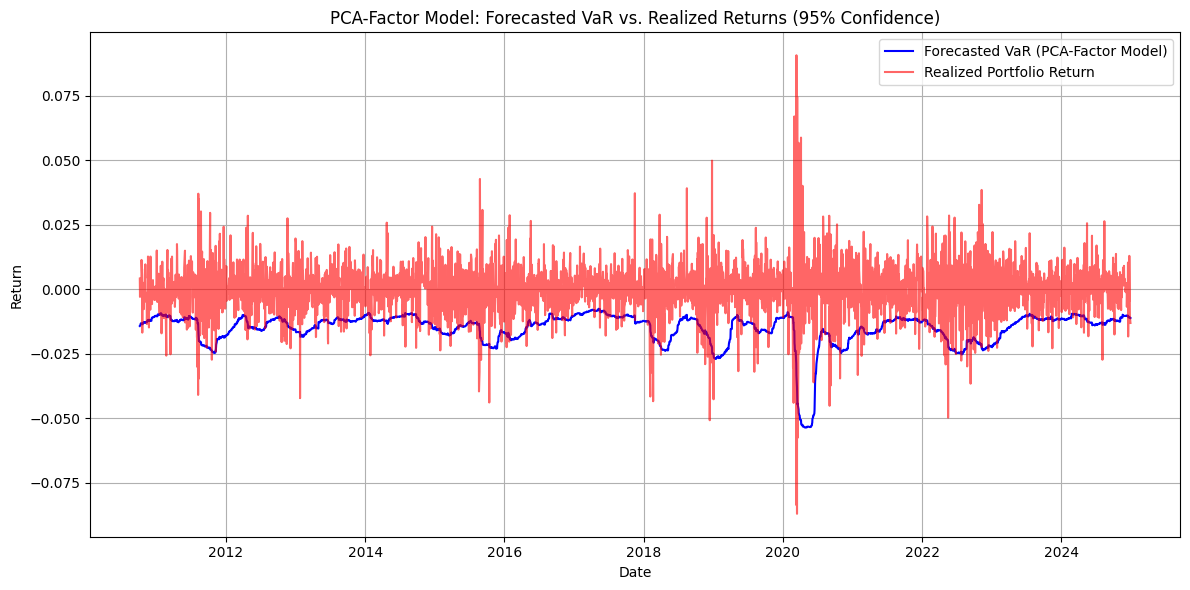

In [ ]:
# =============================================================================
# 7. (Optional) Plot Forecasted VaR vs. Realized Returns
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pca_forecast_df.index, pca_forecast_df["Forecast_VaR"],
        label="Forecasted VaR (PCA-Factor Model)", color="blue")
ax.plot(pca_forecast_df.index, pca_forecast_df["Realized_Return"],
        label="Realized Portfolio Return", color="red", alpha=0.6)
ax.set_title("PCA-Factor Model: Forecasted VaR vs. Realized Returns (95% Confidence)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

##### window 22

In [ ]:
cov_dict_pca = observable_factor_covariance_multifactor(data, assets, factor_cols, window=22)


# Assume an equally weighted portfolio.
weights = np.array([1/3, 1/3, 1/3])

# Generate risk forecasts using the PCA factor model.
pca_forecast_df = forecast_risk_measures(cov_dict_pca, target_returns, weights, alpha=0.05)

# Evaluate the PCA factor model forecasts
LR_uc_pca, p_val_pca, viol_pca, n_pca = kupiec_test_log(pca_forecast_df["Realized_Return"],
                                                        pca_forecast_df["Forecast_VaR"],
                                                        alpha=0.05)

print("PCA-Factor Model (using first 3 PCA components) - Kupiec Test Results:")
print(f"Violations: {viol_pca} out of {n_pca} observations")
print(f"LR Statistic: {LR_uc_pca:.4f}, p-value: {p_val_pca:.4f}")


test_results = christoffersen_tests(pca_forecast_df["Realized_Return"] < pca_forecast_df["Forecast_VaR"], alpha)
print("\nUnconditional Coverage Test (UC):", test_results["UC"])
print("Independence Test (IND):", test_results["IND"])
print("Conditional Coverage Test (CC):", test_results["CC"])

PCA-Factor Model (using first 3 PCA components) - Kupiec Test Results:
Violations: 229 out of 3626 observations
LR Statistic: 12.2381, p-value: 0.0005

Unconditional Coverage Test (UC): {'LR_stat': np.float64(12.2381388526926), 'p_value': np.float64(0.0004682250978601532)}
Independence Test (IND): {'LR_stat': np.float64(-3.8564892306446836), 'p_value': np.float64(1.0)}
Conditional Coverage Test (CC): {'LR_stat': np.float64(13.90597639756902), 'p_value': np.float64(0.0009557748370188079)}


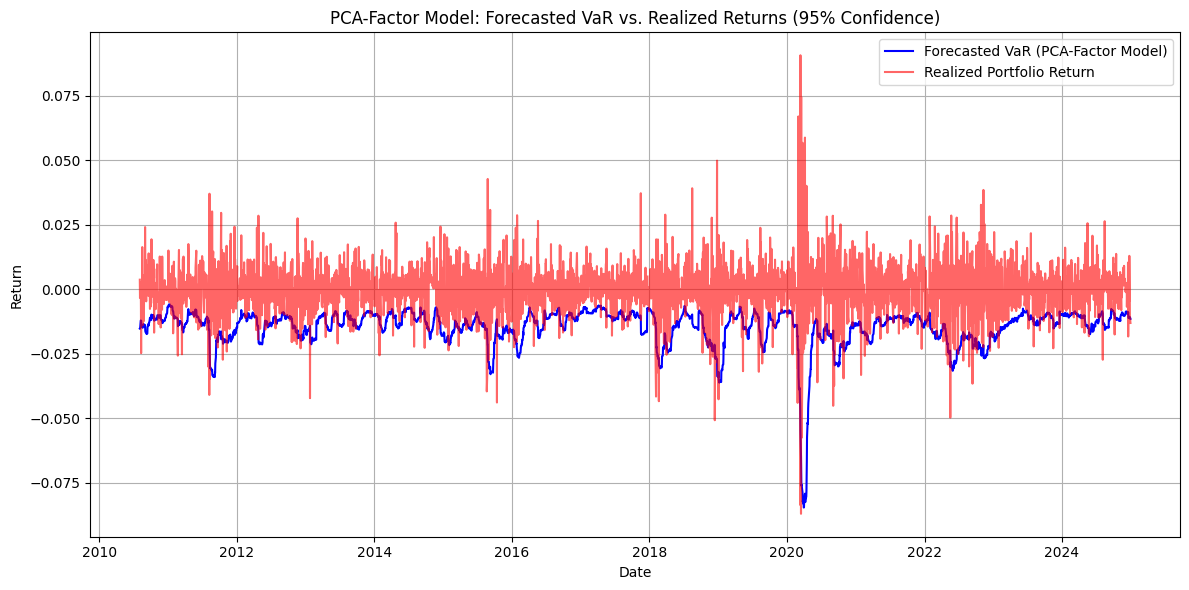

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pca_forecast_df.index, pca_forecast_df["Forecast_VaR"],
        label="Forecasted VaR (PCA-Factor Model)", color="blue")
ax.plot(pca_forecast_df.index, pca_forecast_df["Realized_Return"],
        label="Realized Portfolio Return", color="red", alpha=0.6)
ax.set_title("PCA-Factor Model: Forecasted VaR vs. Realized Returns (95% Confidence)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

##### window 252

PCA-Factor Model (using first 3 PCA components) - Kupiec Test Results:
Violations: 187 out of 3396 observations
LR Statistic: 1.7781, p-value: 0.1824

Unconditional Coverage Test (UC): {'LR_stat': np.float64(1.778128882201372), 'p_value': np.float64(0.1823792568773137)}
Independence Test (IND): {'LR_stat': np.float64(4.327606459679146), 'p_value': np.float64(0.03749894200483028)}
Conditional Coverage Test (CC): {'LR_stat': np.float64(11.904225203034002), 'p_value': np.float64(0.002600341226727587)}


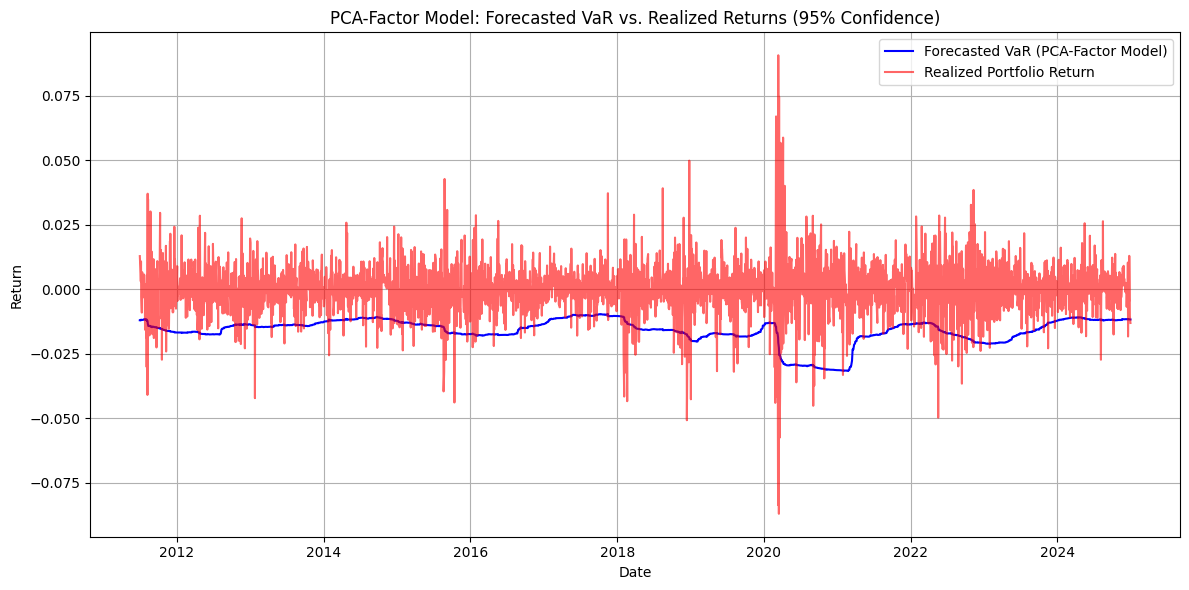

In [ ]:
cov_dict_pca = observable_factor_covariance_multifactor(data, assets, factor_cols, window=252)


# Assume an equally weighted portfolio.
weights = np.array([1/3, 1/3, 1/3])

# Generate risk forecasts using the PCA factor model.
pca_forecast_df = forecast_risk_measures(cov_dict_pca, target_returns, weights, alpha=0.05)

# Evaluate the PCA factor model forecasts
LR_uc_pca, p_val_pca, viol_pca, n_pca = kupiec_test_log(pca_forecast_df["Realized_Return"],
                                                        pca_forecast_df["Forecast_VaR"],
                                                        alpha=0.05)

print("PCA-Factor Model (using first 3 PCA components) - Kupiec Test Results:")
print(f"Violations: {viol_pca} out of {n_pca} observations")
print(f"LR Statistic: {LR_uc_pca:.4f}, p-value: {p_val_pca:.4f}")


test_results = christoffersen_tests(pca_forecast_df["Realized_Return"] < pca_forecast_df["Forecast_VaR"], alpha)
print("\nUnconditional Coverage Test (UC):", test_results["UC"])
print("Independence Test (IND):", test_results["IND"])
print("Conditional Coverage Test (CC):", test_results["CC"])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pca_forecast_df.index, pca_forecast_df["Forecast_VaR"],
        label="Forecasted VaR (PCA-Factor Model)", color="blue")
ax.plot(pca_forecast_df.index, pca_forecast_df["Realized_Return"],
        label="Realized Portfolio Return", color="red", alpha=0.6)
ax.set_title("PCA-Factor Model: Forecasted VaR vs. Realized Returns (95% Confidence)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

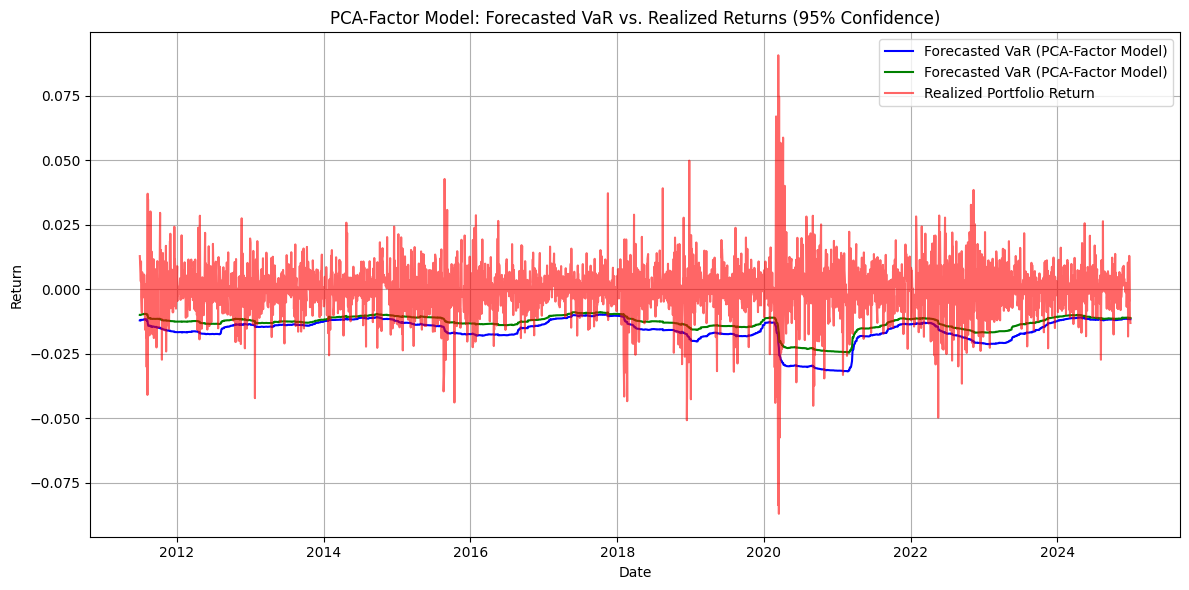

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pca_forecast_df.index, pca_forecast_df["Forecast_VaR"],
        label="Forecasted VaR (PCA-Factor Model)", color="blue")
ax.plot(of_multi_forecast_df.index, of_multi_forecast_df["Forecast_VaR"],
        label="Forecasted VaR (PCA-Factor Model)", color="green")
ax.plot(pca_forecast_df.index, pca_forecast_df["Realized_Return"],
        label="Realized Portfolio Return", color="red", alpha=0.6)
ax.set_title("PCA-Factor Model: Forecasted VaR vs. Realized Returns (95% Confidence)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# For demonstration, print the last computed covariance matrix from each model:
last_date_ma = list(cov_dict_pca.keys())[-1]
print("Moving Average Covariance on", last_date_ma)
print(cov_dict_pca[last_date_ma])

Moving Average Covariance on 2024-12-30 00:00:00
[[ 2.01723686e-04 -1.14467481e-05  7.92548430e-06]
 [-1.14467481e-05  8.94813962e-05  1.88179416e-05]
 [ 7.92548430e-06  1.88179416e-05  1.20872299e-04]]


#### 4 factors

In [ ]:
n_components = 5
pca = PCA(n_components=n_components)
pca_factors_array = pca.fit_transform(scaled_returns)
pca_factors = pd.DataFrame(pca_factors_array, index=broad_returns.index, columns=[f'PC{i+1}' for i in range(n_components)])

target_returns = demeaned_returns.copy()
data = target_returns.join(pca_factors, how='inner')


##### window 63

PCA-Factor Model (using first 3 PCA components) - Kupiec Test Results:
Violations: 212 out of 3582 observations
LR Statistic: 6.0233, p-value: 0.0141

Unconditional Coverage Test (UC): {'LR_stat': np.float64(6.023308080314791), 'p_value': np.float64(0.014118159115230178)}
Independence Test (IND): {'LR_stat': np.float64(-2.1684950861308607), 'p_value': np.float64(1.0)}
Conditional Coverage Test (CC): {'LR_stat': np.float64(9.508993610081234), 'p_value': np.float64(0.008612877559620591)}


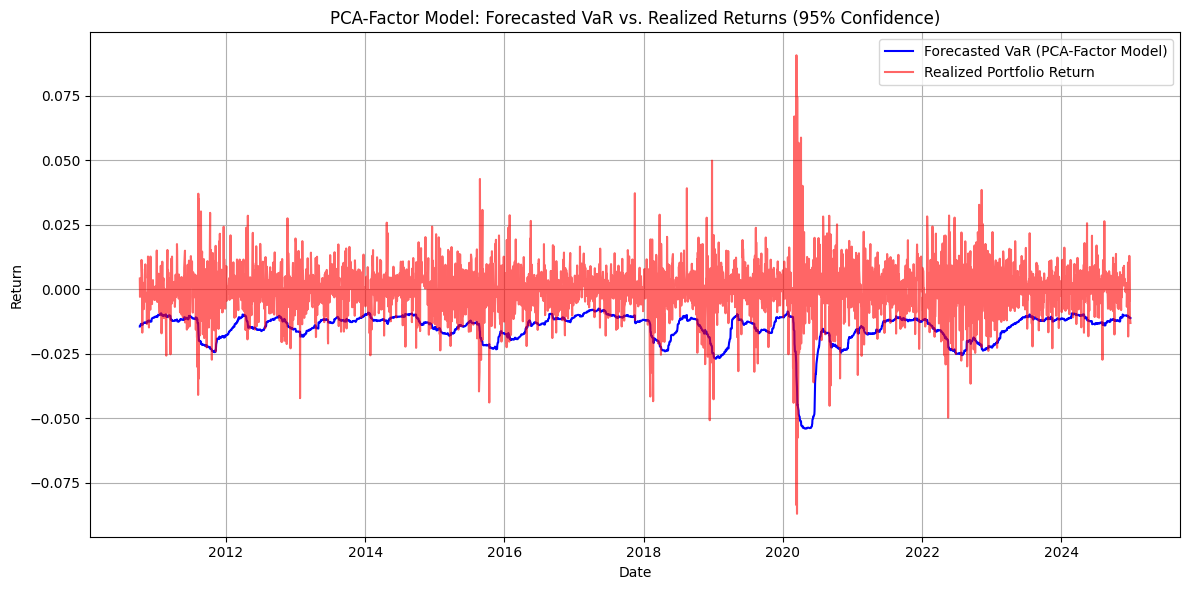

In [ ]:
assets = ["AAPL", "JNJ", "WMT"]
factor_cols = [f'PC{i+1}' for i in range(n_components)]
cov_dict_pca = observable_factor_covariance_multifactor(data, assets, factor_cols, window=66)


# Assume an equally weighted portfolio.
weights = np.array([1/3, 1/3, 1/3])

# Generate risk forecasts using the PCA factor model.
pca_forecast_df = forecast_risk_measures(cov_dict_pca, target_returns, weights, alpha=0.05)

# Evaluate the PCA factor model forecasts
LR_uc_pca, p_val_pca, viol_pca, n_pca = kupiec_test_log(pca_forecast_df["Realized_Return"],
                                                        pca_forecast_df["Forecast_VaR"],
                                                        alpha=0.05)

print("PCA-Factor Model (using first 3 PCA components) - Kupiec Test Results:")
print(f"Violations: {viol_pca} out of {n_pca} observations")
print(f"LR Statistic: {LR_uc_pca:.4f}, p-value: {p_val_pca:.4f}")

test_results = christoffersen_tests(pca_forecast_df["Realized_Return"] < pca_forecast_df["Forecast_VaR"], alpha)
print("\nUnconditional Coverage Test (UC):", test_results["UC"])
print("Independence Test (IND):", test_results["IND"])
print("Conditional Coverage Test (CC):", test_results["CC"])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pca_forecast_df.index, pca_forecast_df["Forecast_VaR"],
        label="Forecasted VaR (PCA-Factor Model)", color="blue")
ax.plot(pca_forecast_df.index, pca_forecast_df["Realized_Return"],
        label="Realized Portfolio Return", color="red", alpha=0.6)
ax.set_title("PCA-Factor Model: Forecasted VaR vs. Realized Returns (95% Confidence)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

##### window 22

PCA-Factor Model (using first 3 PCA components) - Kupiec Test Results:
Violations: 237 out of 3626 observations
LR Statistic: 16.4935, p-value: 0.0000

Unconditional Coverage Test (UC): {'LR_stat': np.float64(16.493479259152764), 'p_value': np.float64(4.881767906872447e-05)}
Independence Test (IND): {'LR_stat': np.float64(-4.852093576643938), 'p_value': np.float64(1.0)}
Conditional Coverage Test (CC): {'LR_stat': np.float64(17.097036182868123), 'p_value': np.float64(0.0001938321283216915)}


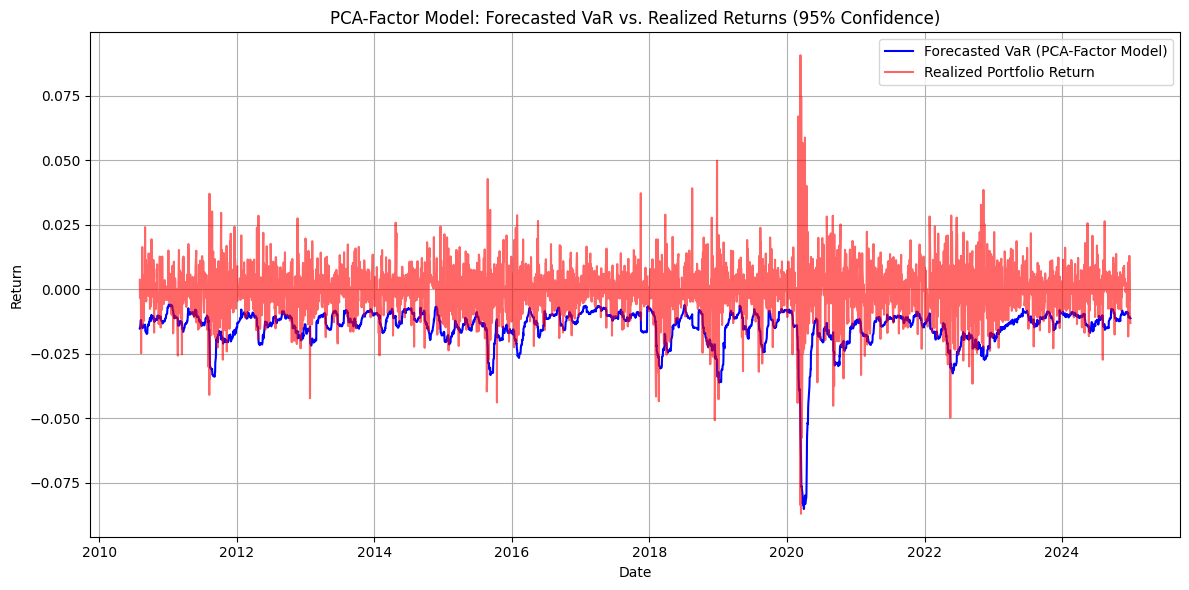

In [ ]:
cov_dict_pca = observable_factor_covariance_multifactor(data, assets, factor_cols, window=22)


# Assume an equally weighted portfolio.
weights = np.array([1/3, 1/3, 1/3])

# Generate risk forecasts using the PCA factor model.
pca_forecast_df = forecast_risk_measures(cov_dict_pca, target_returns, weights, alpha=0.05)

# Evaluate the PCA factor model forecasts
LR_uc_pca, p_val_pca, viol_pca, n_pca = kupiec_test_log(pca_forecast_df["Realized_Return"],
                                                        pca_forecast_df["Forecast_VaR"],
                                                        alpha=0.05)

print("PCA-Factor Model (using first 3 PCA components) - Kupiec Test Results:")
print(f"Violations: {viol_pca} out of {n_pca} observations")
print(f"LR Statistic: {LR_uc_pca:.4f}, p-value: {p_val_pca:.4f}")

test_results = christoffersen_tests(pca_forecast_df["Realized_Return"] < pca_forecast_df["Forecast_VaR"], alpha)
print("\nUnconditional Coverage Test (UC):", test_results["UC"])
print("Independence Test (IND):", test_results["IND"])
print("Conditional Coverage Test (CC):", test_results["CC"])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pca_forecast_df.index, pca_forecast_df["Forecast_VaR"],
        label="Forecasted VaR (PCA-Factor Model)", color="blue")
ax.plot(pca_forecast_df.index, pca_forecast_df["Realized_Return"],
        label="Realized Portfolio Return", color="red", alpha=0.6)
ax.set_title("PCA-Factor Model: Forecasted VaR vs. Realized Returns (95% Confidence)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

##### window 252

PCA-Factor Model (using first 3 PCA components) - Kupiec Test Results:
Violations: 187 out of 3396 observations
LR Statistic: 1.7781, p-value: 0.1824

Unconditional Coverage Test (UC): {'LR_stat': np.float64(1.778128882201372), 'p_value': np.float64(0.1823792568773137)}
Independence Test (IND): {'LR_stat': np.float64(4.327606459679146), 'p_value': np.float64(0.03749894200483028)}
Conditional Coverage Test (CC): {'LR_stat': np.float64(11.904225203034002), 'p_value': np.float64(0.002600341226727587)}


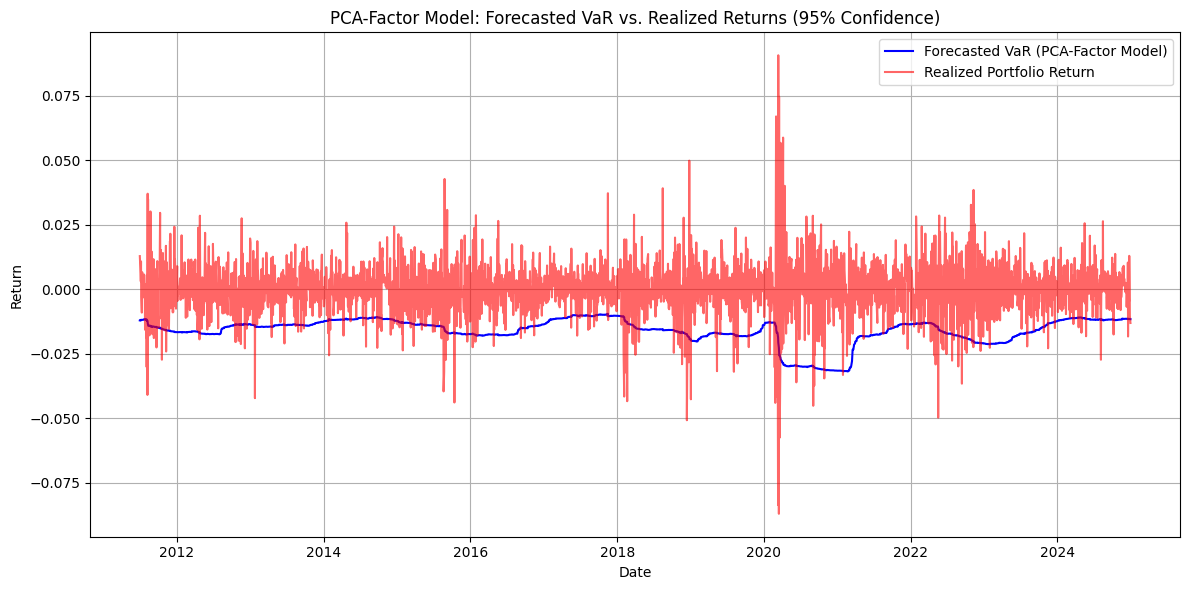

In [ ]:
cov_dict_pca = observable_factor_covariance_multifactor(data, assets, factor_cols, window=252)


# Assume an equally weighted portfolio.
weights = np.array([1/3, 1/3, 1/3])

# Generate risk forecasts using the PCA factor model.
pca_forecast_df = forecast_risk_measures(cov_dict_pca, target_returns, weights, alpha=0.05)

# Evaluate the PCA factor model forecasts
LR_uc_pca, p_val_pca, viol_pca, n_pca = kupiec_test_log(pca_forecast_df["Realized_Return"],
                                                        pca_forecast_df["Forecast_VaR"],
                                                        alpha=0.05)

print("PCA-Factor Model (using first 3 PCA components) - Kupiec Test Results:")
print(f"Violations: {viol_pca} out of {n_pca} observations")
print(f"LR Statistic: {LR_uc_pca:.4f}, p-value: {p_val_pca:.4f}")

test_results = christoffersen_tests(pca_forecast_df["Realized_Return"] < pca_forecast_df["Forecast_VaR"], alpha)
print("\nUnconditional Coverage Test (UC):", test_results["UC"])
print("Independence Test (IND):", test_results["IND"])
print("Conditional Coverage Test (CC):", test_results["CC"])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pca_forecast_df.index, pca_forecast_df["Forecast_VaR"],
        label="Forecasted VaR (PCA-Factor Model)", color="blue")
ax.plot(pca_forecast_df.index, pca_forecast_df["Realized_Return"],
        label="Realized Portfolio Return", color="red", alpha=0.6)
ax.set_title("PCA-Factor Model: Forecasted VaR vs. Realized Returns (95% Confidence)")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

#### Explanations of the variables

In [ ]:
loadings = pca.components_.T

# Create a DataFrame of loadings:
loadings_df = pd.DataFrame(loadings, index=broad_returns.columns,
                           columns=factor_cols)
print("\nLoadings of the optimal PCA components (each column is a factor):")
print(loadings_df)

for i in range(len(factor_cols)):
    comp = f'PC{i+1}'
    comp_loadings = loadings_df[comp]
    top_loadings = comp_loadings.abs().sort_values(ascending=False).head(10)
    print(f"\nTop 10 absolute loadings for {comp}:")
    print(top_loadings)


Loadings of the optimal PCA components (each column is a factor):
             PC1       PC2       PC3       PC4       PC5
Ticker                                                  
A       0.054885 -0.017868  0.066527 -0.029279  0.009204
AAPL    0.045398 -0.019990  0.078985  0.014843  0.047160
ABT     0.047878  0.035069  0.071651 -0.068192 -0.016936
ACGL    0.051906  0.020707 -0.060096 -0.018757 -0.063639
ACN     0.056923 -0.005509  0.052070 -0.007871 -0.001574
...          ...       ...       ...       ...       ...
XEL     0.041823  0.148964 -0.006762  0.030166  0.053546
XOM     0.049463 -0.022684 -0.098965 -0.049498  0.155008
YUM     0.048288  0.005907  0.012534  0.024971 -0.025688
ZBH     0.049565 -0.008504 -0.004636  0.009919 -0.010921
ZBRA    0.046637 -0.039783  0.046693  0.013344  0.029461

[432 rows x 5 columns]

Top 10 absolute loadings for PC1:
Ticker
AMP     0.065292
HON     0.064014
BLK     0.063516
PFG     0.063305
AME     0.063275
PRU     0.063230
ITW     0.063140
TROW   

# GARCH

In [ ]:
# do not print output
%%capture
!pip install arch
!pip install yfinance
!pip install matplotlib
!pip install scipy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2
from arch import arch_model
from scipy.optimize import minimize

In [ ]:
# # Target portfolio of three stocks: AAPL, JNJ, and WMT
# target_tickers = ["AAPL", "JNJ", "WMT"]
# target_prices = yf.download(target_tickers, start="2010-07-01", end="2025-01-01")["Close"]

# # Compute daily log returns for the target portfolio.
# target_returns = np.log(target_prices).diff().dropna()
# target_returns = target_returns - target_returns.mean()target_returns
target_returns = demeaned_returns.copy()

# Define the scaling factor
scale_factor = 1000.0

# Scale the returns for numerical stability
scaled_returns = target_returns * scale_factor

## Working Code

30723.306495071567
26934.641502171773
28190.18960485266
Vector GARCH (CCC) Full-Sample Forecast Risk Measures:
            Forecast_VaR  Forecast_ES  Realized_Return
2010-07-07     -0.018668    -0.023410         0.023192
2010-07-08     -0.018821    -0.023603        -0.003424
2010-07-09     -0.019083    -0.023931        -0.008727
2010-07-12     -0.018897    -0.023697        -0.006256
2010-07-13     -0.018886    -0.023684        -0.007813

Kupiec Test for the Vector GARCH Forecast:
Violations: 139 out of 3646 observations
LR Statistic: 11.7511, p-value: 0.0006


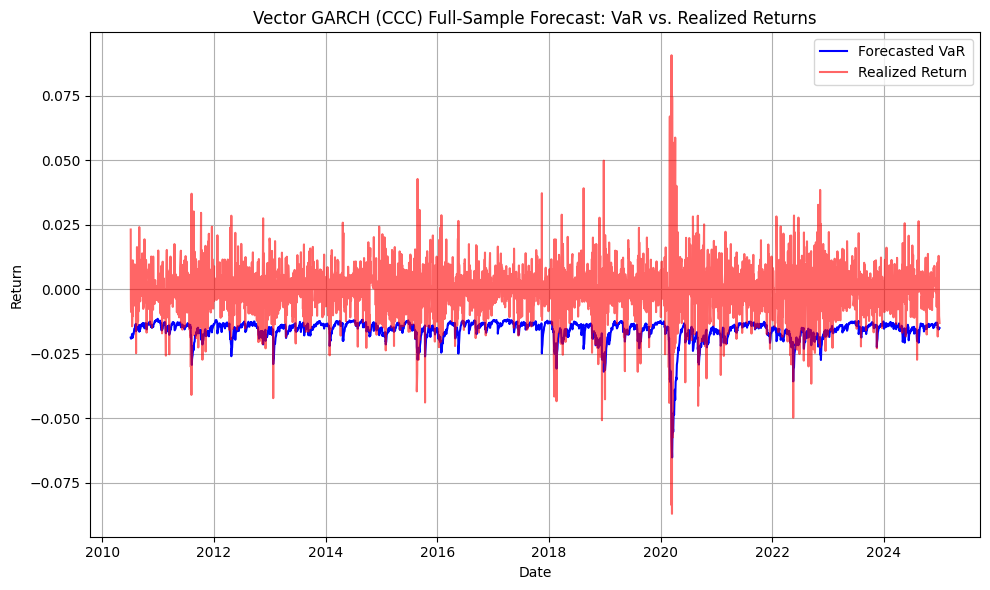

In [ ]:
# -------------------------------
# 2. Vector GARCH Forecast (CCC Model) Without a Rolling Window
#    Generate forecasts over the full (out-of-sample) period.
# -------------------------------
def vector_garch_forecast_cov_full_sample(scaled_returns, assets, scale=scale_factor, start_index=22):
    """
    Estimates a CCC vector GARCH model on the entire sample (no re-estimation on rolling windows)
    and produces a series of one-step-ahead forecast covariance matrices.

    For each asset, a univariate GARCH(1,1) is estimated over the entire sample. Then, using
    the arch_model's forecast method with a specified 'start' index, a one-step forecast is
    produced for every date from start_index onward. A full-sample correlation matrix is computed,
    and for each forecast date the covariance matrix is constructed in original units as:

         Cov_ij(t) = [sigma_forecast_i(t)/scale] * [sigma_forecast_j(t)/scale] * corr_ij,

    where sigma_forecast_i(t) is the one-step-ahead forecast standard deviation (in scaled units)
    for asset i on date t.

    Parameters:
      scaled_returns : DataFrame of scaled asset returns.
      assets         : List of asset tickers.
      scale          : The scaling factor applied to returns.
      start_index    : Integer index (or date position) from which forecasts begin.

    Returns:
      cov_dict : Dictionary keyed by forecast date with the forecast covariance matrix
                 (in original, unscaled, units) for each date.
      forecast_variances : DataFrame of one-step-ahead forecast variances (scaled units) for each asset.
    """
    # Initialize a DataFrame to hold forecast variances for each asset.
    forecast_variances = pd.DataFrame(index=scaled_returns.index[start_index:], columns=assets)

    # Estimate a univariate GARCH model for each asset once and obtain forecasts over the full sample:
    for asset in assets:
        series = scaled_returns[asset]
        # Use rescale=False because our series is already scaled.
        am = arch_model(series, mean="Constant", vol="Garch", p=1, q=1,
                        dist="normal", rescale=False)
        res = am.fit(disp="off", options={'maxiter': 50, 'ftol': 1e-5})
        print(res.bic)
        # Generate one-step-ahead forecasts for each date from start_index onward.
        fc = res.forecast(horizon=1, start=start_index)
        # fc.variance is a DataFrame with forecast variances indexed by dates.
        # We assume we want the one-step forecast (column 0).
        forecast_variances[asset] = fc.variance.iloc[:, 0]

    # Compute the full-sample correlation matrix (correlation is independent of scaling).
    full_corr = scaled_returns[assets].corr().values

    # Build a dictionary of forecast covariance matrices: one per forecast date.
    cov_dict = {}
    for date in forecast_variances.index:
        # For each asset, get its forecast variance for date (in scaled units),
        # compute the corresponding forecast standard deviation and then scale back to original units.
        sigma_scaled = np.sqrt(forecast_variances.loc[date].values)
        sigma_orig   = sigma_scaled / scale

        # Construct the forecast covariance matrix:
        cov_matrix_orig = np.outer(sigma_orig, sigma_orig) * full_corr
        cov_dict[date] = cov_matrix_orig

    return cov_dict, forecast_variances

# Choose the list of assets and a start index for forecasting (e.g., 22 observations in).
assets = tickers
start_index = 2  # You can adjust this to define the start of your forecast period

# Generate the forecast covariance matrix time series using the full-sample estimation.
vgarch_cov_dict, forecast_variances = vector_garch_forecast_cov_full_sample(scaled_returns, assets,
                                                                            scale=scale_factor,
                                                                            start_index=start_index)

# -------------------------------
# 3. Forecast VaR and Expected Shortfall (ES) Using the Full-Sample Forecasts
# -------------------------------
def forecast_risk_measures(cov_dict, returns, weights, alpha=0.05):
    """
    For each forecast date in cov_dict, compute the portfolio risk measures:
      - Portfolio forecast standard deviation (from the forecast covariance matrix),
      - Value-at-Risk (VaR) and Expected Shortfall (ES) using the normal assumption,
      - And match these forecasts with the realized portfolio return for that date.

    Parameters:
      cov_dict : Dictionary of forecast covariance matrices in original units (keyed by date).
      returns  : DataFrame of unscaled asset returns.
      weights  : Portfolio weights.
      alpha    : Tail probability (e.g., 0.05 for 95% VaR).

    Returns:
      forecast_df : DataFrame indexed by forecast dates with columns
                    Forecast_VaR, Forecast_ES, and Realized_Return.
    """
    forecast_dates = []
    forecast_VaR = []
    forecast_ES = []
    realized_portfolio_returns = []

    for date in sorted(cov_dict.keys()):
        # Ensure that the forecast date is available in returns:
        if date not in returns.index:
            continue

        Sigma = cov_dict[date]
        portfolio_std = np.sqrt(np.dot(weights, np.dot(Sigma, weights)))
        VaR = norm.ppf(alpha) * portfolio_std
        ES  = - (norm.pdf(norm.ppf(alpha)) / alpha) * portfolio_std

        realized_ret = np.dot(weights, returns.loc[date].values)

        forecast_dates.append(date)
        forecast_VaR.append(VaR)
        forecast_ES.append(ES)
        realized_portfolio_returns.append(realized_ret)

    forecast_df = pd.DataFrame({
        "Forecast_VaR": forecast_VaR,
        "Forecast_ES": forecast_ES,
        "Realized_Return": realized_portfolio_returns
    }, index=forecast_dates)

    return forecast_df

# Define equally weighted portfolio weights.
weights = np.array([1/len(assets)] * len(assets))

# Compute the risk measures for each forecast date.
vgarch_forecast_df = forecast_risk_measures(vgarch_cov_dict, returns, weights, alpha=0.05)

print("Vector GARCH (CCC) Full-Sample Forecast Risk Measures:")
print(vgarch_forecast_df.head())


# -------------------------------
# 4. (Optional) Backtesting: Kupiec Test in Log Domain
# -------------------------------
def kupiec_test_log(realized_returns, VaR_forecasts, alpha=0.05):
    """
    Performs the Kupiec likelihood ratio test (unconditional coverage) using logarithms.

    Parameters:
      realized_returns : Series/array of realized portfolio returns.
      VaR_forecasts    : Series/array of forecast VaR values.
      alpha            : Nominal tail probability (0.05 for 95% confidence).

    Returns:
      (LR_uc, p_value, violations, n)
    """
    n = len(realized_returns)
    violations = np.sum(realized_returns < VaR_forecasts)
    pi = violations / n
    if violations == 0 or violations == n:
        LR_uc = np.nan
        p_value = np.nan
    else:
        log_term_null = (n - violations) * np.log(1 - alpha) + violations * np.log(alpha)
        log_term_emp  = (n - violations) * np.log(1 - pi)   + violations * np.log(pi)
        LR_uc = -2 * (log_term_null - log_term_emp)
        p_value = 1 - chi2.cdf(LR_uc, df=1)
    return LR_uc, p_value, violations, n

# Apply the Kupiec test on the series of forecast VaRs versus realized portfolio returns:
LR_uc_vg, p_val_vg, viol_vg, n_vg = kupiec_test_log(
    vgarch_forecast_df["Realized_Return"],
    vgarch_forecast_df["Forecast_VaR"],
    alpha=0.05)

print("\nKupiec Test for the Vector GARCH Forecast:")
print(f"Violations: {viol_vg} out of {n_vg} observations")
print(f"LR Statistic: {LR_uc_vg:.4f}, p-value: {p_val_vg:.4f}")


# -------------------------------
# 5. (Optional) Plot Forecasted VaR and Realized Portfolio Returns
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(vgarch_forecast_df.index, vgarch_forecast_df["Forecast_VaR"],
        label="Forecasted VaR", color="blue")
ax.plot(vgarch_forecast_df.index, vgarch_forecast_df["Realized_Return"],
        label="Realized Return", color="red", alpha=0.6)
ax.set_title("Vector GARCH (CCC) Full-Sample Forecast: VaR vs. Realized Returns")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

### Trying GARCH(2,2) model with forecast window of 22 (To be corrected)

Vector GARCH (CCC) Full-Sample Forecast Risk Measures:
            Forecast_VaR  Forecast_ES  Realized_Return
2010-07-08     -0.015053    -0.018877         0.004600
2010-07-09     -0.016227    -0.020349        -0.001560
2010-07-12     -0.014719    -0.018458        -0.000833
2010-07-13     -0.015900    -0.019940        -0.003434
2010-07-14     -0.014988    -0.018795         0.000007

Kupiec Test for the Vector GARCH Forecast:
Violations: 125 out of 3645 observations
LR Statistic: 21.1749, p-value: 0.0000


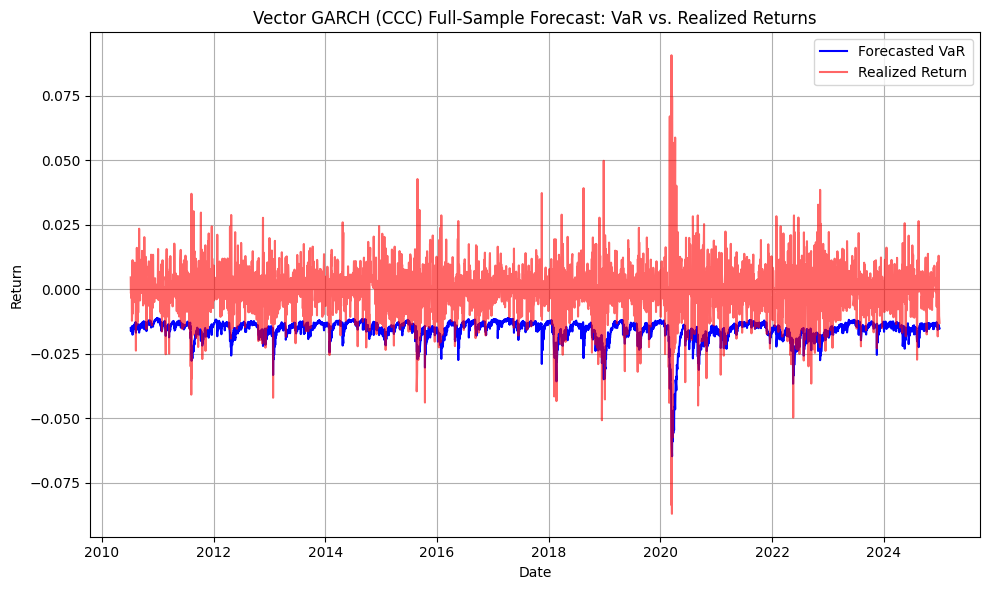

In [ ]:
# -------------------------------
# 2. Vector GARCH Forecast (CCC Model) Without a Rolling Window
#    Generate forecasts over the full (out-of-sample) period.
# -------------------------------
def vector_garch22_forecast_cov_full_sample(scaled_returns, assets, scale=scale_factor, start_index=22):
    """
    Estimates a CCC vector GARCH model on the entire sample (no re-estimation on rolling windows)
    and produces a series of one-step-ahead forecast covariance matrices.

    For each asset, a univariate GARCH(1,1) is estimated over the entire sample. Then, using
    the arch_model's forecast method with a specified 'start' index, a one-step forecast is
    produced for every date from start_index onward. A full-sample correlation matrix is computed,
    and for each forecast date the covariance matrix is constructed in original units as:

         Cov_ij(t) = [sigma_forecast_i(t)/scale] * [sigma_forecast_j(t)/scale] * corr_ij,

    where sigma_forecast_i(t) is the one-step-ahead forecast standard deviation (in scaled units)
    for asset i on date t.

    Parameters:
      scaled_returns : DataFrame of scaled asset returns.
      assets         : List of asset tickers.
      scale          : The scaling factor applied to returns.
      start_index    : Integer index (or date position) from which forecasts begin.

    Returns:
      cov_dict : Dictionary keyed by forecast date with the forecast covariance matrix
                 (in original, unscaled, units) for each date.
      forecast_variances : DataFrame of one-step-ahead forecast variances (scaled units) for each asset.
    """
    # Initialize a DataFrame to hold forecast variances for each asset.
    forecast_variances = pd.DataFrame(index=scaled_returns.index[start_index:], columns=assets)

    # Estimate a univariate GARCH model for each asset once and obtain forecasts over the full sample:
    for asset in assets:
        series = scaled_returns[asset]
        # Use rescale=False because our series is already scaled.
        am = arch_model(series, mean="Constant", vol="Garch", p=5, q=5,
                        dist="normal", rescale=False)
        res = am.fit(disp="off", options={'maxiter': 50, 'ftol': 1e-5})
        print(res.hqic)
        # Generate one-step-ahead forecasts for each date from start_index onward.
        fc = res.forecast(horizon=1, start=start_index)
        # fc.variance is a DataFrame with forecast variances indexed by dates.
        # We assume we want the one-step forecast (column 0).
        forecast_variances[asset] = fc.variance.iloc[:, 0]

    # Compute the full-sample correlation matrix (correlation is independent of scaling).
    full_corr = scaled_returns[assets].corr().values

    # Build a dictionary of forecast covariance matrices: one per forecast date.
    cov_dict = {}
    for date in forecast_variances.index:
        # For each asset, get its forecast variance for date (in scaled units),
        # compute the corresponding forecast standard deviation and then scale back to original units.
        sigma_scaled = np.sqrt(forecast_variances.loc[date].values)
        sigma_orig   = sigma_scaled / scale

        # Construct the forecast covariance matrix:
        cov_matrix_orig = np.outer(sigma_orig, sigma_orig) * full_corr
        cov_dict[date] = cov_matrix_orig

    return cov_dict, forecast_variances

# Choose the list of assets and a start index for forecasting (e.g., 22 observations in).
assets = tickers
start_index = 3  # You can adjust this to define the start of your forecast period

# Generate the forecast covariance matrix time series using the full-sample estimation.
vgarch_cov_dict, forecast_variances = vector_garch22_forecast_cov_full_sample(scaled_returns, assets,
                                                                            scale=scale_factor,
                                                                            start_index=start_index)


# Define equally weighted portfolio weights.
weights = np.array([1/len(assets)] * len(assets))

# Compute the risk measures for each forecast date.
vgarch_forecast_df = forecast_risk_measures(vgarch_cov_dict, returns, weights, alpha=0.05)

print("Vector GARCH (CCC) Full-Sample Forecast Risk Measures:")
print(vgarch_forecast_df.head())


# Apply the Kupiec test on the series of forecast VaRs versus realized portfolio returns:
LR_uc_vg, p_val_vg, viol_vg, n_vg = kupiec_test_log(
    vgarch_forecast_df["Realized_Return"],
    vgarch_forecast_df["Forecast_VaR"],
    alpha=0.05)

print("\nKupiec Test for the Vector GARCH Forecast:")
print(f"Violations: {viol_vg} out of {n_vg} observations")
print(f"LR Statistic: {LR_uc_vg:.4f}, p-value: {p_val_vg:.4f}")


# -------------------------------
# 5. (Optional) Plot Forecasted VaR and Realized Portfolio Returns
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(vgarch_forecast_df.index, vgarch_forecast_df["Forecast_VaR"],
        label="Forecasted VaR", color="blue")
ax.plot(vgarch_forecast_df.index, vgarch_forecast_df["Realized_Return"],
        label="Realized Return", color="red", alpha=0.6)
ax.set_title("Vector GARCH (CCC) Full-Sample Forecast: VaR vs. Realized Returns")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# -------------------------------------------------------
# 2. Function to Estimate the Optimal Lags for GARCH(p,q)
# -------------------------------------------------------
def estimate_optimal_garch_lags(scaled_returns, assets, p_values, q_values, criterion="bic"):
    """
    Estimate a univariate GARCH(p,q) model for each asset over the full sample for each
    combination of p and q. Compute the chosen information criterion (BIC or HQC) for each
    model and then average the criterion values across the assets.

    Parameters:
      scaled_returns : DataFrame of scaled asset returns.
      assets         : List of asset tickers (columns in scaled_returns).
      p_values       : List of candidate values for p (ARCH lags).
      q_values       : List of candidate values for q (GARCH lags).
      criterion      : 'bic' or 'hqc' to select which information criterion to use.

    Returns:
      results_df     : A DataFrame containing p, q and the average criterion value.
    """
    results = []

    for p in p_values:
        for q in q_values:
            criterion_vals = []
            for asset in assets:
                series = scaled_returns[asset]
                # Set up a univariate GARCH model with the candidate lag orders.
                try:
                    am = arch_model(series, mean="Constant", vol="Garch", p=p, q=q,
                                    dist="normal", rescale=False)
                    res = am.fit(disp="off", options={'maxiter': 50, 'ftol': 1e-5})

                    if criterion.lower() == "bic":
                        criterion_vals.append(res.bic)
                    elif criterion.lower() == "hqc":
                        criterion_vals.append(res.hqic)
                    else:
                        raise ValueError("Criterion must be either 'bic' or 'hqc'.")
                except Exception as e:
                    # If estimation fails, record a NaN.
                    criterion_vals.append(np.nan)

            # Average the criterion values across all assets (ignoring NaNs)
            avg_crit = np.nanmean(criterion_vals)
            results.append({"p": p, "q": q, criterion.upper(): avg_crit})

    results_df = pd.DataFrame(results)
    return results_df


# -------------------------------------------------------
# 3. Set Candidate Lag Values and Generate the Table
# -------------------------------------------------------
# Here we define candidate orders. You can adjust these lists as needed.
p_candidates = [1, 2, 3, 4, 5, 6]
q_candidates = [1, 2, 3, 4, 5, 6]

# Choose the information criterion: use either "bic" or "hqc"
criterion_choice = "bic"  # or "hqc"

# Estimate and build the table of (p,q) combinations and their average criterion value.
optimal_lag_table = estimate_optimal_garch_lags(scaled_returns, tickers, p_candidates, q_candidates,
                                                criterion=criterion_choice)

print("Average", criterion_choice.upper(), "for Candidate GARCH(p,q) Models:")
print(optimal_lag_table.sort_values(by=criterion_choice.upper()))

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Average BIC for Candidate GARCH(p,q) Models:
    p  q           BIC
0   1  1  28607.129416
1   1  2  28607.348162
2   1  3  28608.852778
7   2  2  28613.993157
6   2  1  28615.331628
3   1  4  28615.484898
8   2  3  28615.695653
9   2  4  28622.016046
13  3  2  28622.195367
12  3  1  28623.533838
4   1  5  28624.266280
14  3  3  28625.257193
5   1  6  28625.885905
10  2  5  28630.225777
19  4  2  28630.387106
15  3  4  28630.541138
18  4  1  28631.732681
11  2  6  28631.863246
20  4  3  28632.099082
21  4  4  28634.930251
16  3  5  28637.142720
25  5  2  28638.018266
17  3  6  28639.056124
24  5  1  28639.126247
26  5  3  28640.981422
22  4  5  28641.591604
27  5  4  28642.804133
30  6  1  28643.245258
23  4  6  28644.087911
31  6  2  28645.441892
32  6  3  28647.173971
28  5  5  28647.590413
33  6  4  28650.435468
29  5  6  28653.138309
34  6  5  28655.791931
35  6  6  28661.339501


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Optimal GARCH is p=q=1?

## GARCH Extensions & Additional Modelling

we first estimate a fully fledged GARCH(1,1) model, not assuming any restrictions on the correlation between assets. Not assuming constant conditional correlation

Full Vector GARCH (BEKK) Forecast Risk Measures (Using Entire Dataset):
            Forecast_VaR  Forecast_ES  Realized_Return
2010-07-06     -0.015695    -0.019682         0.010577
2010-07-07     -0.017854    -0.022390         0.023192
2010-07-08     -0.018058    -0.022645        -0.003424
2010-07-09     -0.017255    -0.021638        -0.008727
2010-07-12     -0.017861    -0.022399        -0.006256

Kupiec Test for the Full Vector GARCH Forecast:
Violations: 190 out of 3647 observations
LR Statistic: 0.3334, p-value: 0.5636


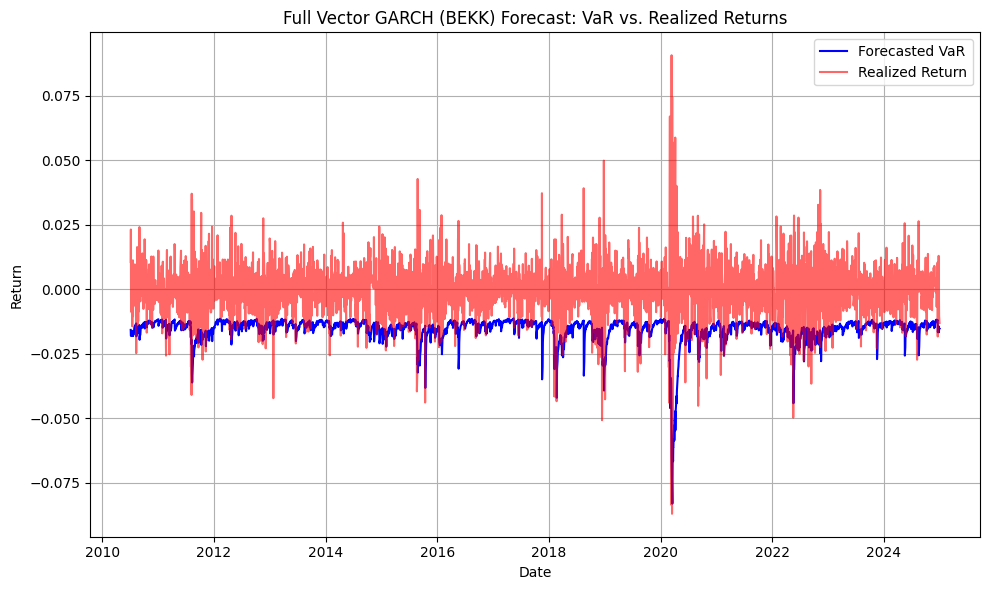

In [ ]:
# =============================================================================
# 2. Full Vector GARCH (BEKK) Estimation and Recursive One-Step-Ahead Forecasting
# =============================================================================
def bekk_neg_loglik(params, data):
    """
    Negative log-likelihood for a BEKK(1,1) model:
         H_t = C C' + A (r_{t-1} r_{t-1}') A' + B H_{t-1} B'

    Parameters:
      params : Flattened parameter vector (elements of lower-triangular C, then A, then B)
      data   : Array of shape (T, k) of returns (in scaled units)

    Returns:
      Negative log-likelihood (scalar)
    """
    k = data.shape[1]
    T = data.shape[0]
    nC = k * (k + 1) // 2
    nA = k * k
    nB = k * k

    # Rebuild lower triangular C
    C = np.zeros((k, k))
    idx = 0
    for i in range(k):
        for j in range(i + 1):
            C[i, j] = params[idx]
            idx += 1
    # Extract A and B matrices
    A = params[idx: idx + nA].reshape((k, k))
    idx += nA
    B = params[idx: idx + nB].reshape((k, k))

    # Initialize H as sample covariance of data
    H = np.cov(data.T)
    neg_ll = 0.0
    for t in range(1, T):
        r_tm1 = data[t-1][:, None]  # column vector
        H = C @ C.T + A @ (r_tm1 @ r_tm1.T) @ A.T + B @ H @ B.T
        r_t = data[t]
        H_pd = H + 1e-6 * np.eye(k)  # ensure positive definiteness
        sign, logdet = np.linalg.slogdet(H_pd)
        if sign <= 0:
            return 1e10
        invH = np.linalg.inv(H_pd)
        neg_ll += 0.5 * (logdet + r_t @ invH @ r_t)
    return neg_ll

def bekk_fit(data):
    """
    Estimate BEKK(1,1) parameters on the full data (in scaled units).

    Parameters:
      data : Array of shape (T, k)

    Returns:
      est_params, C_est, A_est, B_est
    """
    k = data.shape[1]
    nC = k * (k + 1) // 2
    nA = k * k
    nB = k * k

    # Initial guess: use Cholesky of sample covariance for C, small identities for A and B.
    S = np.cov(data.T)
    try:
        L = np.linalg.cholesky(S)
    except np.linalg.LinAlgError:
        L = np.linalg.cholesky(S + 1e-6 * np.eye(k))
    init_C = []
    for i in range(k):
        for j in range(i + 1):
            init_C.append(L[i, j])
    init_C = np.array(init_C)
    init_A = 0.1 * np.eye(k).flatten()
    init_B = 0.8 * np.eye(k).flatten()
    init_params = np.concatenate([init_C, init_A, init_B])

    # No bounds are applied in this example.
    bounds = [(None, None)] * (nC + nA + nB)

    res = minimize(bekk_neg_loglik, init_params, args=(data,), method='L-BFGS-B',
                   bounds=bounds, options={'maxiter': 50, 'ftol': 1e-5})
    est_params = res.x
    idx = 0
    C_est = np.zeros((k, k))
    for i in range(k):
        for j in range(i + 1):
            C_est[i, j] = est_params[idx]
            idx += 1
    A_est = est_params[idx: idx+nA].reshape((k, k))
    idx += nA
    B_est = est_params[idx: idx+nB].reshape((k, k))
    return est_params, C_est, A_est, B_est

def full_sample_vector_garch_forecast_cov(scaled_returns, assets, scale=scale_factor):
    """
    Estimates a full vector GARCH model (via BEKK(1,1)) on the entire dataset and uses the
    estimated (frozen) parameters to generate a recursive series of one-step-ahead
    forecast covariance matrices.

    For t = 1,..., T-1:
         H_t = C C' + A (r_{t-1} r_{t-1}') A' + B H_{t-1} B'

    Forecast H_t is considered as the one-step-ahead forecast for date t (with the return
    at date t later used as the realized observation).

    Parameters:
      scaled_returns : DataFrame of scaled asset returns.
      assets         : List of asset tickers.
      scale          : Scaling factor applied to returns.

    Returns:
      cov_dict : Dictionary keyed by forecast date (starting at the second observation)
                 with the forecast covariance matrix (in original units).
    """
    data = scaled_returns[assets].values  # shape (T, k)
    T, k = data.shape

    # Estimate BEKK parameters using the entire dataset.
    _, C_est, A_est, B_est = bekk_fit(data)

    # Initialize H_current using the full-sample covariance (scaled units)
    H_current = np.cov(data.T)

    cov_dict = {}
    # Generate forecasts starting from the second observation.
    forecast_dates = scaled_returns.index[1:]
    for i, date in enumerate(forecast_dates, start=1):
        # r_{i-1} is used to forecast H_i.
        r_prev = data[i-1].reshape((k, 1))
        H_current = C_est @ C_est.T + A_est @ (r_prev @ r_prev.T) @ A_est.T + B_est @ H_current @ B_est.T
        # Convert forecast covariance to original units (variance scales with scale^2).
        H_orig = H_current / (scale**2)
        cov_dict[date] = H_orig
    return cov_dict

# =============================================================================
# 3. Forecast VaR and Expected Shortfall (ES)
# =============================================================================
def forecast_risk_measures(cov_dict, returns, weights, alpha=0.05):
    """
    For each forecast date (with forecast covariance matrix) compute:
      - The portfolio forecast standard deviation,
      - Value-at-Risk (VaR) and Expected Shortfall (ES) (under the normality assumption),
      - And match these with the realized portfolio return.

    Parameters:
      cov_dict : Dictionary of forecast covariance matrices (in original units) keyed by date.
      returns  : DataFrame of unscaled asset returns.
      weights  : Portfolio weights.
      alpha    : Tail probability (e.g., 0.05 for 95% VaR).

    Returns:
      forecast_df : DataFrame indexed by forecast dates with columns:
                    Forecast_VaR, Forecast_ES, Realized_Return.
    """
    forecast_dates = []
    forecast_VaR = []
    forecast_ES = []
    realized_portfolio_returns = []

    for date in sorted(cov_dict.keys()):
        if date not in returns.index:
            continue
        Sigma = cov_dict[date]
        portfolio_std = np.sqrt(np.dot(weights, np.dot(Sigma, weights)))
        VaR = norm.ppf(alpha) * portfolio_std
        ES = - (norm.pdf(norm.ppf(alpha)) / alpha) * portfolio_std
        realized_ret = np.dot(weights, returns.loc[date].values)
        forecast_dates.append(date)
        forecast_VaR.append(VaR)
        forecast_ES.append(ES)
        realized_portfolio_returns.append(realized_ret)

    forecast_df = pd.DataFrame({
        "Forecast_VaR": forecast_VaR,
        "Forecast_ES": forecast_ES,
        "Realized_Return": realized_portfolio_returns
    }, index=forecast_dates)
    return forecast_df

# =============================================================================
# 4. (Optional) Kupiec Test for Backtesting VaR Forecasts
# =============================================================================
def kupiec_test_log(realized_returns, VaR_forecasts, alpha=0.05):
    """
    Performs the Kupiec likelihood ratio test for unconditional coverage.

    Parameters:
      realized_returns : Array/Series of realized portfolio returns.
      VaR_forecasts    : Array/Series of forecast VaR values.
      alpha            : Nominal tail probability (e.g., 0.05 for 95% VaR).

    Returns:
      (LR_uc, p_value, violations, n)
    """
    n = len(realized_returns)
    violations = np.sum(realized_returns < VaR_forecasts)
    pi = violations / n
    if violations == 0 or violations == n:
        return np.nan, np.nan, violations, n
    log_term_null = (n - violations)*np.log(1 - alpha) + violations*np.log(alpha)
    log_term_emp  = (n - violations)*np.log(1 - pi)   + violations*np.log(pi)
    LR_uc = -2*(log_term_null - log_term_emp)
    p_value = 1 - chi2.cdf(LR_uc, df=1)
    return LR_uc, p_value, violations, n

# =============================================================================
# 5. Generate Forecasts and Evaluate the Model
# =============================================================================
# Use the entire dataset for estimation and then generate one-step-ahead forecasts.
assets = tickers
vgarch_cov_dict = full_sample_vector_garch_forecast_cov(scaled_returns, assets, scale=scale_factor)

# Define equally weighted portfolio weights.
weights = np.array([1/len(assets)] * len(assets))

# Compute portfolio risk measures (VaR, ES) for each forecast date.
vgarch_forecast_df = forecast_risk_measures(vgarch_cov_dict, returns, weights, alpha=0.05)

print("Full Vector GARCH (BEKK) Forecast Risk Measures (Using Entire Dataset):")
print(vgarch_forecast_df.head())

# Apply the Kupiec test:
LR_uc_vg, p_val_vg, viol_vg, n_vg = kupiec_test_log(vgarch_forecast_df["Realized_Return"],
                                                      vgarch_forecast_df["Forecast_VaR"],
                                                      alpha=0.05)
print("\nKupiec Test for the Full Vector GARCH Forecast:")
print(f"Violations: {viol_vg} out of {n_vg} observations")
print(f"LR Statistic: {LR_uc_vg:.4f}, p-value: {p_val_vg:.4f}")

# =============================================================================
# 6. (Optional) Plot Forecasted VaR vs. Realized Portfolio Returns
# =============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(vgarch_forecast_df.index, vgarch_forecast_df["Forecast_VaR"], label="Forecasted VaR", color="blue")
ax.plot(vgarch_forecast_df.index, vgarch_forecast_df["Realized_Return"], label="Realized Return", color="red", alpha=0.6)
ax.set_title("Full Vector GARCH (BEKK) Forecast: VaR vs. Realized Returns")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test_results = christoffersen_tests(vgarch_forecast_df["Realized_Return"] < vgarch_forecast_df["Forecast_VaR"], alpha)
print("\nUnconditional Coverage Test (UC):", test_results["UC"])
print("Independence Test (IND):", test_results["IND"])
print("Conditional Coverage Test (CC):", test_results["CC"])


Unconditional Coverage Test (UC): {'LR_stat': np.float64(0.3334426266249011), 'p_value': np.float64(0.5636389420101535)}
Independence Test (IND): {'LR_stat': np.float64(2.563572832616728), 'p_value': np.float64(0.10935120227762174)}
Conditional Coverage Test (CC): {'LR_stat': np.float64(3.0040229610156075), 'p_value': np.float64(0.2226817892764006)}


In [ ]:
# For demonstration, print the last computed covariance matrix from each model:
last_date_ma = list(vgarch_cov_dict.keys())[-1]
print("Moving Average Covariance on", last_date_ma)
print(vgarch_cov_dict[last_date_ma])

Moving Average Covariance on 2024-12-30 00:00:00
[[2.81513231e-04 2.89479827e-05 6.18273237e-05]
 [2.89479827e-05 7.55725246e-05 3.65034737e-05]
 [6.18273237e-05 3.65034737e-05 1.55414307e-04]]


Full Vector GARCH (BEKK) Forecast Risk Measures (Using Entire Dataset):
            Forecast_VaR  Forecast_ES  Realized_Return
2010-07-06     -0.015713    -0.019705         0.005581
2010-07-07     -0.015399    -0.019311         0.023484
2010-07-08     -0.019450    -0.024391         0.004600
2010-07-09     -0.017514    -0.021963        -0.001560
2010-07-12     -0.016562    -0.020770        -0.000833

Kupiec Test for the Full Vector GARCH Forecast:
Violations: 187 out of 3647 observations
LR Statistic: 0.1238, p-value: 0.7249


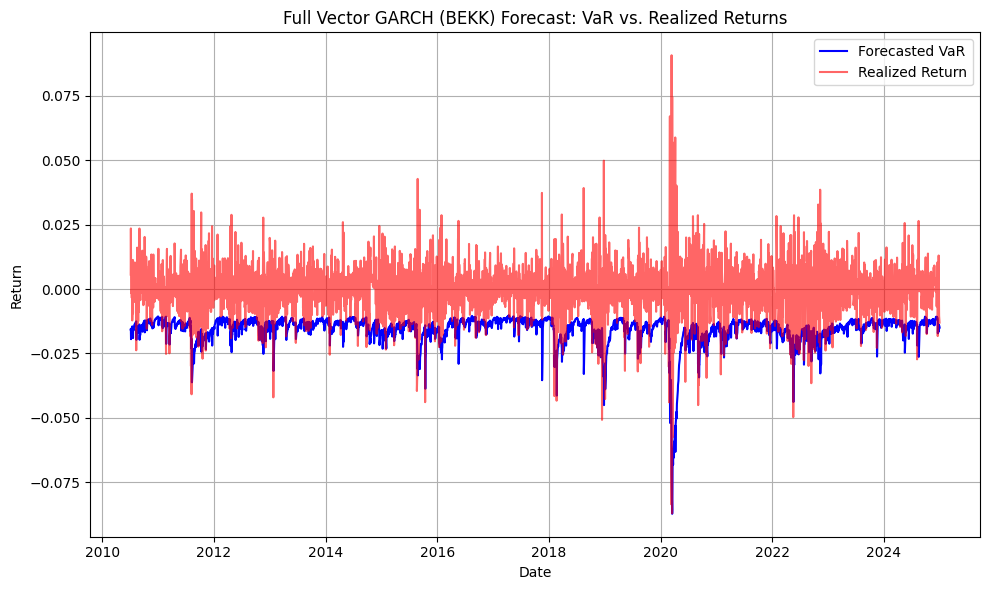

In [ ]:
# =============================================================================
# 2. Full Vector GARCH (BEKK) Estimation and Recursive One-Step-Ahead Forecasting
# =============================================================================
def bekk_neg_loglik(params, data):
    """
    Negative log-likelihood for a BEKK(1,1) model:
         H_t = C C' + A (r_{t-1} r_{t-1}') A' + B H_{t-1} B'

    Parameters:
      params : Flattened parameter vector (elements of lower-triangular C, then A, then B)
      data   : Array of shape (T, k) of returns (in scaled units)

    Returns:
      Negative log-likelihood (scalar)
    """
    k = data.shape[1]
    T = data.shape[0]
    nC = k * (k + 1) // 2
    nA = k * k
    nB = k * k

    # Rebuild lower triangular C
    C = np.zeros((k, k))
    idx = 0
    for i in range(k):
        for j in range(i + 1):
            C[i, j] = params[idx]
            idx += 1
    # Extract A and B matrices
    A = params[idx: idx + nA].reshape((k, k))
    idx += nA
    B = params[idx: idx + nB].reshape((k, k))

    # Initialize H as sample covariance of data
    H = np.cov(data.T)
    neg_ll = 0.0
    for t in range(1, T):
        r_tm1 = data[t-1][:, None]  # column vector
        H = C @ C.T + A @ (r_tm1 @ r_tm1.T) @ A.T + B @ H @ B.T
        r_t = data[t]
        H_pd = H + 1e-6 * np.eye(k)  # ensure positive definiteness
        sign, logdet = np.linalg.slogdet(H_pd)
        if sign <= 0:
            return 1e10
        invH = np.linalg.inv(H_pd)
        neg_ll += 0.5 * (logdet + r_t @ invH @ r_t)
    return neg_ll

def bekk_fit(data):
    """
    Estimate BEKK(1,1) parameters on the full data (in scaled units).

    Parameters:
      data : Array of shape (T, k)

    Returns:
      est_params, C_est, A_est, B_est
    """
    k = data.shape[1]
    nC = k * (k + 1) // 2
    nA = k * k
    nB = k * k

    # Initial guess: use Cholesky of sample covariance for C, small identities for A and B.
    S = np.cov(data.T)
    try:
        L = np.linalg.cholesky(S)
    except np.linalg.LinAlgError:
        L = np.linalg.cholesky(S + 1e-6 * np.eye(k))
    init_C = []
    for i in range(k):
        for j in range(i + 1):
            init_C.append(L[i, j])
    init_C = np.array(init_C)
    init_A = 0.1 * np.eye(k).flatten()
    init_B = 0.8 * np.eye(k).flatten()
    init_params = np.concatenate([init_C, init_A, init_B])

    # No bounds are applied in this example.
    bounds = [(None, None)] * (nC + nA + nB)

    res = minimize(bekk_neg_loglik, init_params, args=(data,), method='L-BFGS-B',
                   bounds=bounds, options={'maxiter': 50, 'ftol': 1e-5})
    est_params = res.x
    idx = 0
    C_est = np.zeros((k, k))
    for i in range(k):
        for j in range(i + 1):
            C_est[i, j] = est_params[idx]
            idx += 1
    A_est = est_params[idx: idx+nA].reshape((k, k))
    idx += nA
    B_est = est_params[idx: idx+nB].reshape((k, k))
    return est_params, C_est, A_est, B_est

def full_sample_vector_garch_forecast_cov(scaled_returns, assets, scale=scale_factor):
    """
    Estimates a full vector GARCH model (via BEKK(1,1)) on the entire dataset and uses the
    estimated (frozen) parameters to generate a recursive series of one-step-ahead
    forecast covariance matrices.

    For t = 1,..., T-1:
         H_t = C C' + A (r_{t-1} r_{t-1}') A' + B H_{t-1} B'

    Forecast H_t is considered as the one-step-ahead forecast for date t (with the return
    at date t later used as the realized observation).

    Parameters:
      scaled_returns : DataFrame of scaled asset returns.
      assets         : List of asset tickers.
      scale          : Scaling factor applied to returns.

    Returns:
      cov_dict : Dictionary keyed by forecast date (starting at the second observation)
                 with the forecast covariance matrix (in original units).
    """
    data = scaled_returns[assets].values  # shape (T, k)
    T, k = data.shape

    # Estimate BEKK parameters using the entire dataset.
    _, C_est, A_est, B_est = bekk_fit(data)

    # Initialize H_current using the full-sample covariance (scaled units)
    H_current = np.cov(data.T)

    cov_dict = {}
    # Generate forecasts starting from the second observation.
    forecast_dates = scaled_returns.index[1:]
    for i, date in enumerate(forecast_dates, start=1):
        # r_{i-1} is used to forecast H_i.
        r_prev = data[i-1].reshape((k, 1))
        H_current = C_est @ C_est.T + A_est @ (r_prev @ r_prev.T) @ A_est.T + B_est @ H_current @ B_est.T
        # Convert forecast covariance to original units (variance scales with scale^2).
        H_orig = H_current / (scale**2)
        cov_dict[date] = H_orig
    return cov_dict

# =============================================================================
# 3. Forecast VaR and Expected Shortfall (ES)
# =============================================================================
def forecast_risk_measures(cov_dict, returns, weights, alpha=0.05):
    """
    For each forecast date (with forecast covariance matrix) compute:
      - The portfolio forecast standard deviation,
      - Value-at-Risk (VaR) and Expected Shortfall (ES) (under the normality assumption),
      - And match these with the realized portfolio return.

    Parameters:
      cov_dict : Dictionary of forecast covariance matrices (in original units) keyed by date.
      returns  : DataFrame of unscaled asset returns.
      weights  : Portfolio weights.
      alpha    : Tail probability (e.g., 0.05 for 95% VaR).

    Returns:
      forecast_df : DataFrame indexed by forecast dates with columns:
                    Forecast_VaR, Forecast_ES, Realized_Return.
    """
    forecast_dates = []
    forecast_VaR = []
    forecast_ES = []
    realized_portfolio_returns = []

    for date in sorted(cov_dict.keys()):
        if date not in returns.index:
            continue
        Sigma = cov_dict[date]
        portfolio_std = np.sqrt(np.dot(weights, np.dot(Sigma, weights)))
        VaR = norm.ppf(alpha) * portfolio_std
        ES = - (norm.pdf(norm.ppf(alpha)) / alpha) * portfolio_std
        realized_ret = np.dot(weights, returns.loc[date].values)
        forecast_dates.append(date)
        forecast_VaR.append(VaR)
        forecast_ES.append(ES)
        realized_portfolio_returns.append(realized_ret)

    forecast_df = pd.DataFrame({
        "Forecast_VaR": forecast_VaR,
        "Forecast_ES": forecast_ES,
        "Realized_Return": realized_portfolio_returns
    }, index=forecast_dates)
    return forecast_df

# =============================================================================
# 4. (Optional) Kupiec Test for Backtesting VaR Forecasts
# =============================================================================
def kupiec_test_log(realized_returns, VaR_forecasts, alpha=0.05):
    """
    Performs the Kupiec likelihood ratio test for unconditional coverage.

    Parameters:
      realized_returns : Array/Series of realized portfolio returns.
      VaR_forecasts    : Array/Series of forecast VaR values.
      alpha            : Nominal tail probability (e.g., 0.05 for 95% VaR).

    Returns:
      (LR_uc, p_value, violations, n)
    """
    n = len(realized_returns)
    violations = np.sum(realized_returns < VaR_forecasts)
    pi = violations / n
    if violations == 0 or violations == n:
        return np.nan, np.nan, violations, n
    log_term_null = (n - violations)*np.log(1 - alpha) + violations*np.log(alpha)
    log_term_emp  = (n - violations)*np.log(1 - pi)   + violations*np.log(pi)
    LR_uc = -2*(log_term_null - log_term_emp)
    p_value = 1 - chi2.cdf(LR_uc, df=1)
    return LR_uc, p_value, violations, n

# =============================================================================
# 5. Generate Forecasts and Evaluate the Model
# =============================================================================
# Use the entire dataset for estimation and then generate one-step-ahead forecasts.
assets = tickers
vgarch_cov_dict = full_sample_vector_garch_forecast_cov(scaled_returns, assets, scale=scale_factor)

# Define equally weighted portfolio weights.
weights = np.array([1/len(assets)] * len(assets))

# Compute portfolio risk measures (VaR, ES) for each forecast date.
vgarch_forecast_df = forecast_risk_measures(vgarch_cov_dict, returns, weights, alpha=0.05)

print("Full Vector GARCH (BEKK) Forecast Risk Measures (Using Entire Dataset):")
print(vgarch_forecast_df.head())

# Apply the Kupiec test:
LR_uc_vg, p_val_vg, viol_vg, n_vg = kupiec_test_log(vgarch_forecast_df["Realized_Return"],
                                                      vgarch_forecast_df["Forecast_VaR"],
                                                      alpha=0.05)
print("\nKupiec Test for the Full Vector GARCH Forecast:")
print(f"Violations: {viol_vg} out of {n_vg} observations")
print(f"LR Statistic: {LR_uc_vg:.4f}, p-value: {p_val_vg:.4f}")

# =============================================================================
# 6. (Optional) Plot Forecasted VaR vs. Realized Portfolio Returns
# =============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(vgarch_forecast_df.index, vgarch_forecast_df["Forecast_VaR"], label="Forecasted VaR", color="blue")
ax.plot(vgarch_forecast_df.index, vgarch_forecast_df["Realized_Return"], label="Realized Return", color="red", alpha=0.6)
ax.set_title("Full Vector GARCH (BEKK) Forecast: VaR vs. Realized Returns")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

### Results are good. We also test GARCH(5,5) / BEKK(5,5) specification as a test to compare results

<ipython-input-119-87c96c4cedb8>:68: RuntimeWarning: overflow encountered in add
  sum_B += B_list[j-1] @ H @ B_list[j-1].T
<ipython-input-119-87c96c4cedb8>:68: RuntimeWarning: invalid value encountered in matmul
  sum_B += B_list[j-1] @ H @ B_list[j-1].T
/usr/local/lib/python3.11/dist-packages/numpy/linalg/_linalg.py:2311: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
<ipython-input-119-87c96c4cedb8>:181: RuntimeWarning: overflow encountered in add
  sum_B += B_list[j-1] @ H_tj @ B_list[j-1].T
<ipython-input-119-87c96c4cedb8>:181: RuntimeWarning: invalid value encountered in matmul
  sum_B += B_list[j-1] @ H_tj @ B_list[j-1].T


Full Vector GARCH (BEKK(5,5)) Forecast Risk Measures (Entire Dataset Estimation):
            Forecast_VaR  Forecast_ES  Realized_Return
2010-07-12     -0.034022    -0.042665        -0.000833
2010-07-13     -0.041519    -0.052067        -0.003434
2010-07-14     -0.051505    -0.064590         0.000007
2010-07-15     -0.064513    -0.080901        -0.003908
2010-07-16     -0.081557    -0.102276        -0.012185

Kupiec Test for Full Vector GARCH (BEKK(5,5)) Forecast:
Violations: 0 out of 3643 observations
LR Statistic: nan, p-value: nan


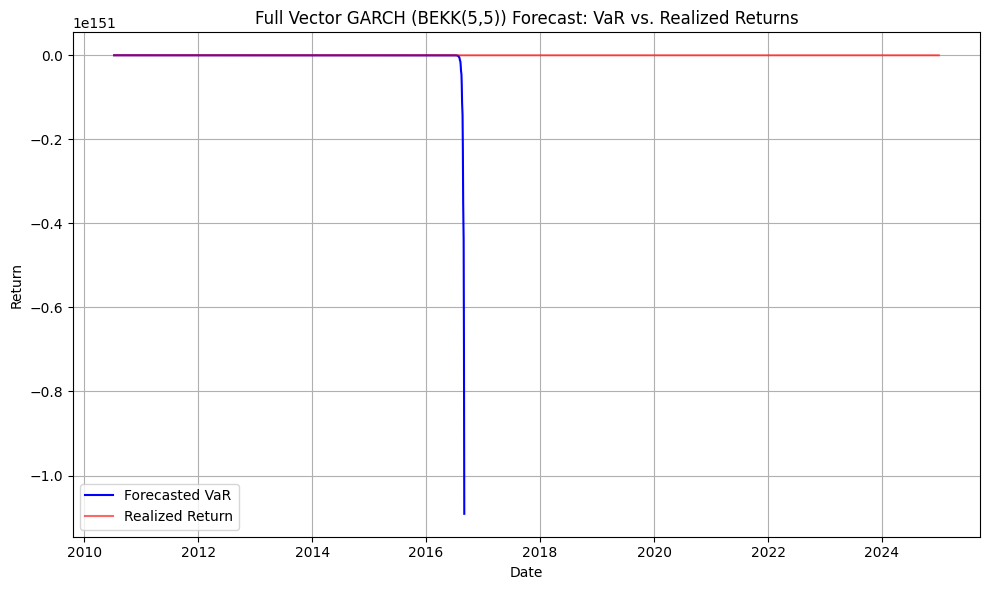

In [ ]:
# =============================================================================
# 2. Full Vector GARCH (BEKK(5,5)) Estimation and Recursive One-Step-Ahead Forecasting
# =============================================================================
max_lag = 5  # For BEKK(5,5)

def bekk_neg_loglik(params, data):
    """
    Negative log-likelihood for a BEKK(5,5) model:
         H_t = C C' + sum_{i=1}^{5} A_i (r_{t-i} r_{t-i}') A_i' + sum_{j=1}^{5} B_j H_{t-j} B_j'

    Parameters:
      params : Flattened parameter vector containing:
               - Elements of lower-triangular C (size = k(k+1)/2)
               - Then 5 matrices A_i (each k x k, total 5*k^2)
               - Then 5 matrices B_j (each k x k, total 5*k^2)
      data   : Array of shape (T, k) of returns (scaled)

    Returns:
      Negative log-likelihood (scalar)
    """
    k = data.shape[1]
    T = data.shape[0]
    nC = k * (k + 1) // 2
    nA = 5 * k * k
    nB = 5 * k * k

    # Rebuild C (lower triangular)
    C = np.zeros((k, k))
    idx = 0
    for i in range(k):
        for j in range(i + 1):
            C[i, j] = params[idx]
            idx += 1
    # Extract 5 A_i matrices and stack them into a list
    A_list = []
    for i in range(5):
        A_i = params[idx: idx + k*k].reshape((k, k))
        A_list.append(A_i)
        idx += k*k
    # Extract 5 B_j matrices into a list
    B_list = []
    for j in range(5):
        B_j = params[idx: idx + k*k].reshape((k, k))
        B_list.append(B_j)
        idx += k*k

    # Initialize H_t: use sample covariance of the data (scaled)
    H = np.cov(data.T)
    neg_ll = 0.0
    # Start the loop from t = max_lag (since we need the first max_lag observations as lags)
    for t in range(max_lag, T):
        # Sum the A_i contribution over the last 5 lags:
        sum_A = np.zeros((k, k))
        for i in range(1, max_lag+1):
            r_tm_i = data[t-i][:, None]  # return at t-i (column vector)
            sum_A += A_list[i-1] @ (r_tm_i @ r_tm_i.T) @ A_list[i-1].T
        # Sum the B_j contribution over the past 5 forecasted H's:
        sum_B = np.zeros((k, k))
        # For t <= max_lag, we would need initial values. Here we use H from the initialization for missing lags.
        for j in range(1, max_lag+1):
            if t - j >= 0:
                # For t-j, we can use the recursively computed H stored in H_rec; here we re-use H from previous iteration,
                # but for simplicity we assume H from t - j = sample covariance when t - j < max_lag.
                # In our loop t starts at max_lag so t - j >= 0 always.
                # For a more exact recursion, one would store all past H values.
                # Here we assume H_{t-j} is H_current from the recursion. For simplicity, we use the last computed H.
                # (Note: This is a simplification and may be refined by storing past forecast matrices.)
                sum_B += B_list[j-1] @ H @ B_list[j-1].T
            else:
                sum_B += B_list[j-1] @ np.cov(data.T) @ B_list[j-1].T
        H = C @ C.T + sum_A + sum_B
        # Likelihood calculation
        r_t = data[t]
        H_pd = H + 1e-6 * np.eye(k)
        sign, logdet = np.linalg.slogdet(H_pd)
        if sign <= 0:
            return 1e10
        invH = np.linalg.inv(H_pd)
        neg_ll += 0.5 * (logdet + r_t @ invH @ r_t)
    return neg_ll

def bekk_fit(data):
    """
    Estimate BEKK(5,5) parameters on the full dataset (scaled units).

    Parameters:
      data : Array of shape (T, k)

    Returns:
      est_params, C_est, A_list, B_list
    """
    k = data.shape[1]
    nC = k * (k + 1) // 2
    nA = 5 * k * k
    nB = 5 * k * k

    # Initial guess for C: use Cholesky of sample covariance.
    S = np.cov(data.T)
    try:
        L = np.linalg.cholesky(S)
    except np.linalg.LinAlgError:
        L = np.linalg.cholesky(S + 1e-6 * np.eye(k))
    init_C = []
    for i in range(k):
        for j in range(i + 1):
            init_C.append(L[i, j])
    init_C = np.array(init_C)
    # For each A_i, use 0.1 * I; for each B_j, use 0.8 * I.
    init_A = 0.1 * np.eye(k).flatten()
    init_B = 0.8 * np.eye(k).flatten()
    # Repeat these for 5 times:
    init_A_all = np.tile(init_A, 5)
    init_B_all = np.tile(init_B, 5)
    init_params = np.concatenate([init_C, init_A_all, init_B_all])

    bounds = [(None, None)] * (nC + nA + nB)
    res = minimize(bekk_neg_loglik, init_params, args=(data,), method='L-BFGS-B',
                   bounds=bounds, options={'maxiter': 50, 'ftol': 1e-5})
    est_params = res.x
    idx = 0
    C_est = np.zeros((k, k))
    for i in range(k):
        for j in range(i + 1):
            C_est[i, j] = est_params[idx]
            idx += 1
    A_list = []
    for i in range(5):
        A_i = est_params[idx: idx + k*k].reshape((k, k))
        A_list.append(A_i)
        idx += k*k
    B_list = []
    for j in range(5):
        B_j = est_params[idx: idx + k*k].reshape((k, k))
        B_list.append(B_j)
        idx += k*k
    return est_params, C_est, A_list, B_list

def full_sample_vector_garch_forecast_cov(scaled_returns, assets, scale=scale_factor):
    """
    Estimates a full vector GARCH model (via BEKK(5,5)) on the entire dataset and then
    recursively generates one-step-ahead forecast covariance matrices using the fixed parameters.

    For t = max_lag,..., T-1:
         H_t = C C' + sum_{i=1}^{5} A_i (r_{t-i} r_{t-i}') A_i' + sum_{j=1}^{5} B_j H_{t-j} B_j'

    Forecasted H_t (in scaled units) is then converted to original units.

    Parameters:
      scaled_returns : DataFrame of scaled asset returns.
      assets         : List of asset tickers.
      scale          : Scaling factor applied to returns.

    Returns:
      cov_dict : Dictionary keyed by forecast date (starting at index max_lag) with forecast
                 covariance matrices in original units.
    """
    data = scaled_returns[assets].values  # shape (T, k)
    T, k = data.shape

    # Estimate BEKK(5,5) parameters on the entire dataset.
    _, C_est, A_list, B_list = bekk_fit(data)

    # Initialize forecast storage.
    cov_dict = {}
    # For initialization, store the first max_lag forecasted H's using the sample covariance.
    # For simplicity, we set H_t = sample covariance for t=0,...,max_lag-1.
    H_history = [np.cov(data.T)] * max_lag  # list of length max_lag

    # Now, starting from t = max_lag, recursively compute H_t.
    forecast_dates = scaled_returns.index[max_lag:]
    for t in range(max_lag, T):
        # Compute sum_A = sum_{i=1}^{5} A_i (r_{t-i} r_{t-i}') A_i'
        sum_A = np.zeros((k, k))
        for i in range(1, max_lag+1):
            r_tm = data[t-i][:, None]
            sum_A += A_list[i-1] @ (r_tm @ r_tm.T) @ A_list[i-1].T
        # Compute sum_B = sum_{j=1}^{5} B_j H_{t-j} B_j'
        sum_B = np.zeros((k, k))
        for j in range(1, max_lag+1):
            H_tj = H_history[-j]  # last j-th forecast stored
            sum_B += B_list[j-1] @ H_tj @ B_list[j-1].T
        H_current = C_est @ C_est.T + sum_A + sum_B
        # Append current H to history and pop the oldest
        H_history.append(H_current)
        if len(H_history) > max_lag:
            H_history.pop(0)
        # Convert forecasted covariance to original units.
        H_orig = H_current / (scale**2)
        cov_dict[scaled_returns.index[t]] = H_orig
    return cov_dict

# =============================================================================
# 5. Generate Forecasts and Evaluate the Model
# =============================================================================
assets = tickers
vgarch_cov_dict = full_sample_vector_garch_forecast_cov(scaled_returns, assets, scale=scale_factor)

# Equally weighted portfolio
weights = np.array([1/len(assets)] * len(assets))

vgarch_forecast_df = forecast_risk_measures(vgarch_cov_dict, returns, weights, alpha=0.05)

print("Full Vector GARCH (BEKK(5,5)) Forecast Risk Measures (Entire Dataset Estimation):")
print(vgarch_forecast_df.head())

LR_uc_vg, p_val_vg, viol_vg, n_vg = kupiec_test_log(vgarch_forecast_df["Realized_Return"],
                                                      vgarch_forecast_df["Forecast_VaR"],
                                                      alpha=0.05)
print("\nKupiec Test for Full Vector GARCH (BEKK(5,5)) Forecast:")
print(f"Violations: {viol_vg} out of {n_vg} observations")
print(f"LR Statistic: {LR_uc_vg:.4f}, p-value: {p_val_vg:.4f}")

# =============================================================================
# 6. (Optional) Plot Forecasted VaR vs. Realized Portfolio Returns
# =============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(vgarch_forecast_df.index, vgarch_forecast_df["Forecast_VaR"],
        label="Forecasted VaR", color="blue")
ax.plot(vgarch_forecast_df.index, vgarch_forecast_df["Realized_Return"],
        label="Realized Return", color="red", alpha=0.6)
ax.set_title("Full Vector GARCH (BEKK(5,5)) Forecast: VaR vs. Realized Returns")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

### Not currently work nor what we want

We try modelling a simpler BEKK and Diagonal GARCH, iin this case restimating using a rolling window of 22, which is probably not what we want lol

Streaming output truncated to the last 5000 lines.
<ipython-input-6-a664552ac5d2>:94: RuntimeWarning: overflow encountered in matmul
  H = C @ C.T + A @ (r_tm1 @ r_tm1.T) @ A.T + B @ H @ B.T
/usr/local/lib/python3.11/dist-packages/numpy/linalg/_linalg.py:2311: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
<ipython-input-6-a664552ac5d2>:181: RuntimeWarning: overflow encountered in matmul
  H = C @ C.T + A @ (r_tm1 @ r_tm1.T) @ A.T + B @ H @ B.T
<ipython-input-6-a664552ac5d2>:181: RuntimeWarning: invalid value encountered in matmul
  H = C @ C.T + A @ (r_tm1 @ r_tm1.T) @ A.T + B @ H @ B.T
<ipython-input-6-a664552ac5d2>:94: RuntimeWarning: overflow encountered in matmul
  H = C @ C.T + A @ (r_tm1 @ r_tm1.T) @ A.T + B @ H @ B.T
/usr/local/lib/python3.11/dist-packages/numpy/linalg/_linalg.py:2311: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
<ipython-i

Vector GARCH (Full/CCC) Model - Kupiec Test Results:
Violations: 238 out of 3750 observations, LR Statistic: 13.2414, p-value: 0.0003

Diagonal Vector GARCH (CCC) Model - Kupiec Test Results:
Violations: 238 out of 3750 observations, LR Statistic: 13.2414, p-value: 0.0003

BEKK Model - Kupiec Test Results:
Violations: 107 out of 3750 observations, LR Statistic: 42.7622, p-value: 0.0000



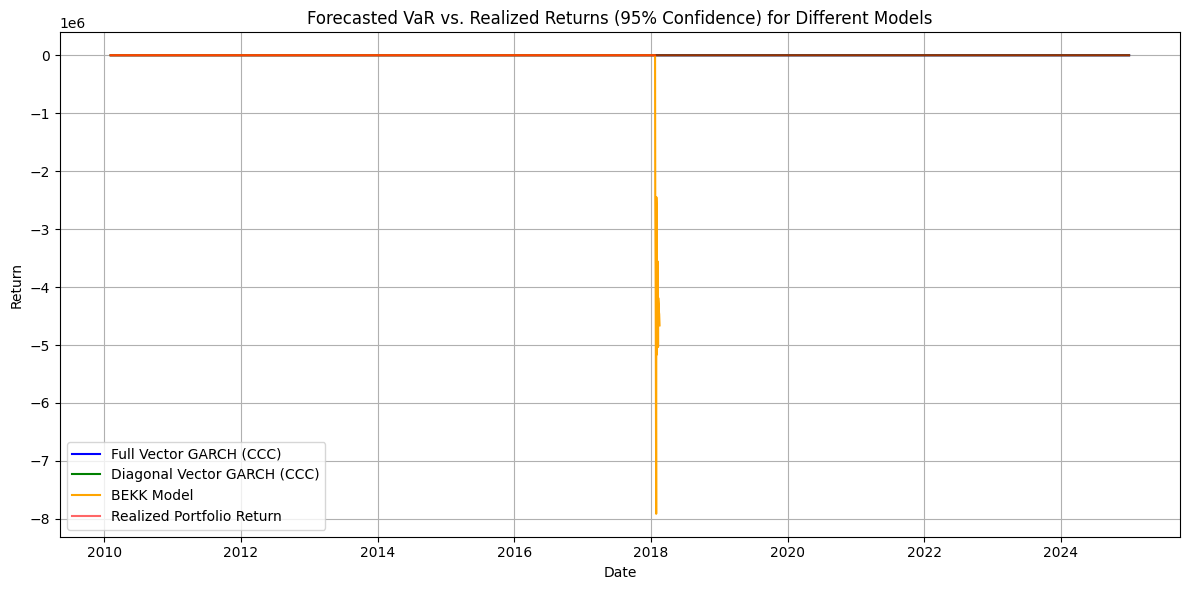

In [ ]:
# # -------------------------------
# # 2. Diagonal Vector GARCH Forecast (CCC-GARCH)
# # -------------------------------
# def vector_garch_forecast_cov(scaled_returns, assets, window=22, scale=scale_factor):
#     """
#     Computes forecast covariance matrices using a rolling window CCC-GARCH approach
#     on scaled returns, then scales the outputs back to original units.
#     (This is effectively the diagonal vector GARCH version.)
#     """
#     cov_dict = {}
#     dates = scaled_returns.index
#     n_assets = len(assets)

#     for t in range(window, len(scaled_returns)):
#         forecast_date = dates[t]
#         forecast_variances_scaled = []

#         # For each asset, fit a univariate GARCH(1,1) model on the scaled series.
#         for asset in assets:
#             series = scaled_returns[asset].iloc[t-window:t]
#             # Already scaled so set rescale=False.
#             am = arch_model(series, mean="Constant", vol="Garch", p=1, q=1,
#                             dist="normal", rescale=False)
#             res = am.fit(disp="off", options={'maxiter': 50, 'ftol': 1e-5})
#             # One-step-ahead variance forecast (scaled units)
#             var_forecast_scaled = res.forecast(horizon=1).variance.iloc[-1, 0]
#             forecast_variances_scaled.append(var_forecast_scaled)

#         # Convert forecast variances into standard deviations (scaled units)
#         sigma_scaled = np.sqrt(np.array(forecast_variances_scaled))
#         # Convert to original units (note: std scales linearly)
#         sigma_orig = sigma_scaled / scale

#         # Estimate the sample correlation matrix over the rolling window
#         window_corr = scaled_returns.iloc[t-window:t][assets].corr().values

#         # Construct covariance forecast in original units: Cov[i,j]=sigma_i*sigma_j*cor(i,j)
#         cov_matrix_orig = np.outer(sigma_orig, sigma_orig) * window_corr
#         cov_dict[forecast_date] = cov_matrix_orig

#     return cov_dict

# # Wrapper function for clarity: diagonal vector GARCH forecast (same as above)
# def diagonal_vector_garch_forecast_cov(scaled_returns, assets, window=22, scale=scale_factor):
#     return vector_garch_forecast_cov(scaled_returns, assets, window, scale)

# # -----------------------------------------------------------------------------
# # 3. BEKK Model Implementation (Without External Package)
# # -----------------------------------------------------------------------------
# # The BEKK(1,1) model is specified as:
# #     H_t = C C' + A * (r_{t-1} r_{t-1}') * A' + B * H_{t-1} * B'
# # where C is lower triangular.
# #
# # We first define functions to compute the BEKK negative log-likelihood,
# # then a fitting routine to estimate the parameters, and finally a function
# # to compute the one-step-ahead forecast covariance matrix.

# def bekk_neg_loglik(params, data):
#     """
#     Negative log-likelihood function for BEKK(1,1) given a window of returns.

#     Parameters:
#       params : flattened vector containing the elements of C (lower triangular),
#                A (full), and B (full).
#       data   : np.array of shape (T, k) with returns (each row is an observation).

#     Returns:
#       Negative log-likelihood.
#     """
#     k = data.shape[1]
#     T = data.shape[0]
#     nC = k * (k + 1) // 2
#     nA = k * k
#     nB = k * k

#     # Extract and rebuild C as a lower triangular matrix:
#     C = np.zeros((k, k))
#     idx = 0
#     for i in range(k):
#         for j in range(i + 1):
#             C[i, j] = params[idx]
#             idx += 1
#     # A and B matrices:
#     A = params[idx: idx+nA].reshape((k, k))
#     idx += nA
#     B = params[idx: idx+nB].reshape((k, k))

#     # Initialize H as the sample covariance matrix
#     H = np.cov(data.T)
#     neg_loglik = 0.0
#     for t in range(1, T):
#         r_tm1 = data[t-1][:, None]  # column vector
#         # Recursive BEKK update:
#         H = C @ C.T + A @ (r_tm1 @ r_tm1.T) @ A.T + B @ H @ B.T
#         # Observed return at time t:
#         r_t = data[t]
#         # To ensure H is positive definite, add a small term to the diagonal:
#         H_pd = H + 1e-6 * np.eye(k)
#         try:
#             sign, logdet = np.linalg.slogdet(H_pd)
#             if sign <= 0:
#                 return 1e10
#             invH = np.linalg.inv(H_pd)
#         except np.linalg.LinAlgError:
#             return 1e10
#         # Increment negative log-likelihood:
#         neg_loglik += 0.5 * (logdet + r_t @ invH @ r_t)
#     return neg_loglik

# def bekk_fit(data, init_params=None):
#     """
#     Estimates BEKK(1,1) parameters from the provided data window, using an optional
#     initial guess for faster convergence (warm start).

#     Parameters:
#       data : np.array of shape (T, k) with returns.
#       init_params : Optional initial guess for the parameters.

#     Returns:
#       est_params : The estimated parameter vector.
#       C_est, A_est, B_est : The estimated parameter matrices.
#     """
#     k = data.shape[1]
#     nC = k * (k + 1) // 2
#     nA = k * k
#     nB = k * k

#     # If no warm start is provided, generate an initial guess:
#     if init_params is None:
#         S = np.cov(data.T)
#         try:
#             L = np.linalg.cholesky(S)
#         except np.linalg.LinAlgError:
#             L = np.linalg.cholesky(S + 1e-6 * np.eye(k))
#         init_C = []
#         for i in range(k):
#             for j in range(i + 1):
#                 init_C.append(L[i, j])
#         init_C = np.array(init_C)
#         # For A and B, start with small multiples of the identity.
#         init_A = 0.1 * np.eye(k).flatten()
#         init_B = 0.8 * np.eye(k).flatten()
#         init_params = np.concatenate([init_C, init_A, init_B])

#     # Set bounds if desired (here all parameters are unbounded)
#     bounds = [(None, None)] * (nC + nA + nB)

#     res = minimize(bekk_neg_loglik, init_params, args=(data,), method='L-BFGS-B', bounds=bounds,
#                    options={'maxiter': 50, 'ftol': 1e-5})
#     est_params = res.x
#     # Unpack the estimated parameters:
#     idx = 0
#     C_est = np.zeros((k, k))
#     for i in range(k):
#         for j in range(i + 1):
#             C_est[i, j] = est_params[idx]
#             idx += 1
#     A_est = est_params[idx: idx+nA].reshape((k, k))
#     idx += nA
#     B_est = est_params[idx: idx+nB].reshape((k, k))
#     return est_params, C_est, A_est, B_est

# def forecast_cov_bekk(data, C, A, B):
#     """
#     Given data (a window of returns) and estimated BEKK parameters, compute
#     the one-step-ahead forecast covariance matrix.

#     Parameters:
#       data : np.array of shape (T, k)
#       C, A, B : Estimated BEKK parameter matrices.

#     Returns:
#       H_forecast : Forecast covariance matrix.
#     """
#     k = data.shape[1]
#     T = data.shape[0]
#     # Initialize H using the sample covariance
#     H = np.cov(data.T)
#     for t in range(1, T):
#         r_tm1 = data[t-1][:, None]
#         H = C @ C.T + A @ (r_tm1 @ r_tm1.T) @ A.T + B @ H @ B.T
#     # One-step-ahead forecast using the last observation:
#     r_last = data[-1][:, None]
#     H_forecast = C @ C.T + A @ (r_last @ r_last.T) @ A.T + B @ H @ B.T
#     return H_forecast

# def bekk_forecast_cov(scaled_returns, assets, window=22, scale=scale_factor):
#     """
#     Computes forecast covariance matrices using a rolling window BEKK(1,1) model
#     on scaled returns, then scales the outputs back to original units.

#     Uses warm-starting across windows.

#     Parameters:
#       scaled_returns : DataFrame of scaled asset returns.
#       assets         : List of asset tickers.
#       window         : Rolling window length.
#       scale          : The scaling factor used for the returns.

#     Returns:
#       cov_dict : Dictionary keyed by forecast date with forecast covariance matrices
#                  in the original (unscaled) units.
#     """
#     cov_dict = {}
#     dates = scaled_returns.index
#     warm_start = None  # This will hold the previous window's estimated parameters

#     for t in range(window, len(scaled_returns)):
#         forecast_date = dates[t]
#         # Use the rolling window for the multivariate data.
#         data_window = scaled_returns[assets].iloc[t-window:t].values  # shape: (window, k)

#         # Estimate BEKK parameters on the rolling window using the warm start (if available)
#         est_params, C_est, A_est, B_est = bekk_fit(data_window, init_params=warm_start)
#         # Update warm_start for the next window:
#         warm_start = est_params.copy()

#         # Forecast one-step-ahead covariance (in scaled units)
#         cov_forecast_scaled = forecast_cov_bekk(data_window, C_est, A_est, B_est)
#         # Rescale: variances/covariances scale with the square of the scaling factor.
#         cov_forecast_orig = cov_forecast_scaled / (scale**2)
#         cov_dict[forecast_date] = cov_forecast_orig

#     return cov_dict

# # -----------------------------------------------------------------------------
# # 4. Risk Forecast Evaluation Function (VaR & ES)
# # -----------------------------------------------------------------------------
# def forecast_risk_measures(cov_dict, returns, weights, alpha=0.05):
#     """
#     For each forecast date in cov_dict, compute:
#       - The portfolio forecast standard deviation.
#       - VaR and Expected Shortfall (under the normal assumption).
#       - Match these forecasts with the realized portfolio return.

#     Returns a DataFrame with Forecast_VaR, Forecast_ES, and Realized_Return.
#     """
#     forecast_dates = []
#     forecast_VaR = []
#     forecast_ES = []
#     realized_portfolio_returns = []

#     for date in sorted(cov_dict.keys()):
#         Sigma = cov_dict[date]
#         portfolio_std = np.sqrt(np.dot(weights, np.dot(Sigma, weights)))

#         # Forecast VaR using the normal quantile (e.g., norm.ppf(0.05) ≈ -1.645)
#         VaR = norm.ppf(alpha) * portfolio_std
#         # Forecast Expected Shortfall under normality:
#         ES = - (norm.pdf(norm.ppf(alpha)) / alpha) * portfolio_std

#         # Use the forecast date to fetch the realized return if available.
#         if date in returns.index:
#             realized_ret = np.dot(weights, returns.loc[date].values)
#         else:
#             continue

#         forecast_dates.append(date)
#         forecast_VaR.append(VaR)
#         forecast_ES.append(ES)
#         realized_portfolio_returns.append(realized_ret)

#     forecast_df = pd.DataFrame({
#         "Forecast_VaR": forecast_VaR,
#         "Forecast_ES": forecast_ES,
#         "Realized_Return": realized_portfolio_returns
#     }, index=forecast_dates)

#     return forecast_df

# # -----------------------------------------------------------------------------
# # 5. Kupiec Test Function (for backtesting VaR forecasts)
# # -----------------------------------------------------------------------------
# def kupiec_test_log(realized_returns, VaR_forecasts, alpha=0.05):
#     """
#     Performs the Kupiec likelihood ratio test (unconditional coverage) using logarithms.

#     Parameters:
#       realized_returns : Series/array of realized portfolio returns.
#       VaR_forecasts    : Series/array of forecast VaR values (negative numbers).
#       alpha            : Nominal tail probability (e.g., 0.05 for 95% confidence).

#     Returns:
#       (LR_uc, p_value, violations, n)
#     """
#     n = len(realized_returns)
#     violations = np.sum(realized_returns < VaR_forecasts)
#     pi = violations / n
#     if violations == 0 or violations == n:
#         LR_uc = np.nan
#         p_value = np.nan
#     else:
#         log_term_null = (n - violations) * np.log(1 - alpha) + violations * np.log(alpha)
#         log_term_emp  = (n - violations) * np.log(1 - pi) + violations * np.log(pi)
#         LR_uc = -2 * (log_term_null - log_term_emp)
#         p_value = 1 - chi2.cdf(LR_uc, df=1)
#     return LR_uc, p_value, violations, n

# # -----------------------------------------------------------------------------
# # 6. Compute Covariance Forecasts for All Models
# # -----------------------------------------------------------------------------
# assets = tickers
# window = 22  # e.g., one trading month

# # Diagonal Vector GARCH (CCC) forecast
# diag_vgarch_cov = diagonal_vector_garch_forecast_cov(scaled_returns, assets, window=window, scale=scale_factor)

# # BEKK forecast covariance matrices using our custom BEKK estimation
# bekk_cov = bekk_forecast_cov(scaled_returns, assets, window=window, scale=scale_factor)

# # (Optional) Full vector GARCH (CCC) forecast (same as your original function)
# vgarch_cov = vector_garch_forecast_cov(scaled_returns, assets, window=window, scale=scale_factor)

# # -----------------------------------------------------------------------------
# # 7. Compute Risk Measures (VaR, ES) for Each Model
# # -----------------------------------------------------------------------------
# # Define equally weighted portfolio
# weights = np.array([1/3, 1/3, 1/3])

# vgarch_forecast_df = forecast_risk_measures(vgarch_cov, returns, weights, alpha=0.05)
# diag_vgarch_forecast_df = forecast_risk_measures(diag_vgarch_cov, returns, weights, alpha=0.05)
# bekk_forecast_df = forecast_risk_measures(bekk_cov, returns, weights, alpha=0.05)

# # -----------------------------------------------------------------------------
# # 8. Backtesting: Kupiec Test for Each Model
# # -----------------------------------------------------------------------------
# LR_uc_vg, p_val_vg, viol_vg, n_vg = kupiec_test_log(vgarch_forecast_df["Realized_Return"],
#                                                       vgarch_forecast_df["Forecast_VaR"],
#                                                       alpha=0.05)
# LR_uc_diag, p_val_diag, viol_diag, n_diag = kupiec_test_log(diag_vgarch_forecast_df["Realized_Return"],
#                                                             diag_vgarch_forecast_df["Forecast_VaR"],
#                                                             alpha=0.05)
# LR_uc_bekk, p_val_bekk, viol_bekk, n_bekk = kupiec_test_log(bekk_forecast_df["Realized_Return"],
#                                                             bekk_forecast_df["Forecast_VaR"],
#                                                             alpha=0.05)

# print("Vector GARCH (Full/CCC) Model - Kupiec Test Results:")
# print(f"Violations: {viol_vg} out of {n_vg} observations, LR Statistic: {LR_uc_vg:.4f}, p-value: {p_val_vg:.4f}\n")

# print("Diagonal Vector GARCH (CCC) Model - Kupiec Test Results:")
# print(f"Violations: {viol_diag} out of {n_diag} observations, LR Statistic: {LR_uc_diag:.4f}, p-value: {p_val_diag:.4f}\n")

# print("BEKK Model - Kupiec Test Results:")
# print(f"Violations: {viol_bekk} out of {n_bekk} observations, LR Statistic: {LR_uc_bekk:.4f}, p-value: {p_val_bekk:.4f}\n")

# # -----------------------------------------------------------------------------
# # 9. Plot Forecasted VaR vs. Realized Returns for Comparison
# # -----------------------------------------------------------------------------
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(vgarch_forecast_df.index, vgarch_forecast_df["Forecast_VaR"],
#         label="Full Vector GARCH (CCC)", color="blue")
# ax.plot(diag_vgarch_forecast_df.index, diag_vgarch_forecast_df["Forecast_VaR"],
#         label="Diagonal Vector GARCH (CCC)", color="green")
# ax.plot(bekk_forecast_df.index, bekk_forecast_df["Forecast_VaR"],
#         label="BEKK Model", color="orange")
# ax.plot(vgarch_forecast_df.index, vgarch_forecast_df["Realized_Return"],
#         label="Realized Portfolio Return", color="red", alpha=0.6)
# ax.set_title("Forecasted VaR vs. Realized Returns (95% Confidence) for Different Models")
# ax.set_xlabel("Date")
# ax.set_ylabel("Return")
# ax.legend()
# ax.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# We additionally run Christoffersen's tests

def christoffersen_tests(violations, alpha=0.05):
    """
    Performs Christoffersen's (1998) tests for:
      1) Unconditional coverage (UC),
      2) Independence (IND), and
      3) Joint coverage + independence (CC).

    Parameters:
    -----------
    violations : array-like of 0s and 1s
        1 indicates a VaR violation (realized return < VaR threshold), 0 otherwise.
    alpha : float
        Nominal tail probability (e.g., 0.05 for 95% VaR).

    Returns:
    --------
    results : dict
        A dictionary containing the test statistics and p-values for:
        - "UC" : Unconditional coverage test
        - "IND": Independence test
        - "CC" : Joint (conditional coverage) test
    """
    # Convert violations to a NumPy array
    violations = np.array(violations, dtype=int)
    n = len(violations)

    # -------------------------------------------
    # 1) Unconditional Coverage Test (UC)
    # -------------------------------------------
    pi_hat = np.mean(violations)  # Empirical violation rate
    num_viol = np.sum(violations) # Total number of violations
    logL0_UC = (n - num_viol) * np.log(1 - alpha) + num_viol * np.log(alpha)

    if 0 < pi_hat < 1:
        logL1_UC = (n - num_viol) * np.log(1 - pi_hat) + num_viol * np.log(pi_hat)
        LR_UC = -2 * (logL0_UC - logL1_UC)
        pval_UC = 1 - chi2.cdf(LR_UC, df=1)
    else:
        LR_UC = np.nan
        pval_UC = np.nan

    # -------------------------------------------
    # 2) Independence Test (IND)
    # -------------------------------------------
    T_00 = T_01 = T_10 = T_11 = 0
    for t in range(1, n):
        i = violations[t-1]
        j = violations[t]
        if i == 0 and j == 0:
            T_00 += 1
        elif i == 0 and j == 1:
            T_01 += 1
        elif i == 1 and j == 0:
            T_10 += 1
        elif i == 1 and j == 1:
            T_11 += 1

    denom_0 = T_00 + T_01  # transitions from 0
    denom_1 = T_10 + T_11  # transitions from 1

    pi_01 = T_01 / denom_0 if denom_0 > 0 else np.nan
    pi_11 = T_11 / denom_1 if denom_1 > 0 else np.nan

    def safe_logprob(x, count):
        return count * np.log(x) if x > 0 else (0 if count == 0 else -np.inf)

    logL_MC = 0.0
    logL_MC += safe_logprob(1 - pi_01, T_00)
    logL_MC += safe_logprob(pi_01, T_01)
    logL_MC += safe_logprob(1 - pi_11, T_10)
    logL_MC += safe_logprob(pi_11, T_11)

    T_0 = denom_0
    T_1 = denom_1
    if 0 < pi_hat < 1:
        logL_iid = safe_logprob(1 - pi_hat, T_0) + safe_logprob(pi_hat, T_1)
        LR_IND = -2 * (logL_iid - logL_MC)
        pval_IND = 1 - chi2.cdf(LR_IND, df=1)
    else:
        LR_IND = np.nan
        pval_IND = np.nan

    # -------------------------------------------
    # 3) Joint Test (Conditional Coverage, CC)
    # -------------------------------------------
    if 0 < alpha < 1:
        LR_CC = -2 * (logL0_UC - logL_MC)
        pval_CC = 1 - chi2.cdf(LR_CC, df=2)
    else:
        LR_CC = np.nan
        pval_CC = np.nan

    results = {
        "UC": {"LR_stat": LR_UC,  "p_value": pval_UC},
        "IND": {"LR_stat": LR_IND, "p_value": pval_IND},
        "CC": {"LR_stat": LR_CC,  "p_value": pval_CC}
    }
    return results

# ----------------------------------------------------
# Helper function to extract binary violations from forecasts
# ----------------------------------------------------
def get_violations(forecast_df):
    """
    Given a forecast DataFrame with columns "Forecast_VaR" and "Realized_Return",
    returns a binary Series where 1 indicates a violation (realized < VaR) and 0 otherwise.
    """
    violations = (forecast_df["Realized_Return"] < forecast_df["Forecast_VaR"]).astype(int)
    return violations

# ----------------------------------------------------
# Run Christoffersen tests for each model
# (Assuming that vgarch_forecast_df, diag_vgarch_forecast_df,
# and bekk_forecast_df have been computed previously.)
# ----------------------------------------------------
alpha = 0.05

# Extract violation series from each forecast DataFrame
vgarch_violations      = get_violations(vgarch_forecast_df)
diag_vgarch_violations = get_violations(diag_vgarch_forecast_df)
bekk_violations        = get_violations(bekk_forecast_df)

# Compute Christoffersen tests for each model
vgarch_chris      = christoffersen_tests(vgarch_violations, alpha=alpha)
diag_vgarch_chris = christoffersen_tests(diag_vgarch_violations, alpha=alpha)
bekk_chris        = christoffersen_tests(bekk_violations, alpha=alpha)

# ----------------------------------------------------
# Compare and print test results
# ----------------------------------------------------
print("Christoffersen Test Results:\n")

print("Vector GARCH (Full/CCC) Model:")
print("  UC Test: LR statistic = {:.4f}, p-value = {:.4f}".format(vgarch_chris["UC"]["LR_stat"], vgarch_chris["UC"]["p_value"]))
print("  IND Test: LR statistic = {:.4f}, p-value = {:.4f}".format(vgarch_chris["IND"]["LR_stat"], vgarch_chris["IND"]["p_value"]))
print("  CC Test: LR statistic = {:.4f}, p-value = {:.4f}\n".format(vgarch_chris["CC"]["LR_stat"], vgarch_chris["CC"]["p_value"]))

print("Diagonal Vector GARCH (CCC) Model:")
print("  UC Test: LR statistic = {:.4f}, p-value = {:.4f}".format(diag_vgarch_chris["UC"]["LR_stat"], diag_vgarch_chris["UC"]["p_value"]))
print("  IND Test: LR statistic = {:.4f}, p-value = {:.4f}".format(diag_vgarch_chris["IND"]["LR_stat"], diag_vgarch_chris["IND"]["p_value"]))
print("  CC Test: LR statistic = {:.4f}, p-value = {:.4f}\n".format(diag_vgarch_chris["CC"]["LR_stat"], diag_vgarch_chris["CC"]["p_value"]))

print("BEKK Model:")
print("  UC Test: LR statistic = {:.4f}, p-value = {:.4f}".format(bekk_chris["UC"]["LR_stat"], bekk_chris["UC"]["p_value"]))
print("  IND Test: LR statistic = {:.4f}, p-value = {:.4f}".format(bekk_chris["IND"]["LR_stat"], bekk_chris["IND"]["p_value"]))
print("  CC Test: LR statistic = {:.4f}, p-value = {:.4f}".format(bekk_chris["CC"]["LR_stat"], bekk_chris["CC"]["p_value"]))

Christoffersen Test Results:

Vector GARCH (Full/CCC) Model:
  UC Test: LR statistic = 13.2414, p-value = 0.0003
  IND Test: LR statistic = -4.6346, p-value = 1.0000
  CC Test: LR statistic = 14.1213, p-value = 0.0009

Diagonal Vector GARCH (CCC) Model:
  UC Test: LR statistic = 13.2414, p-value = 0.0003
  IND Test: LR statistic = -4.6346, p-value = 1.0000
  CC Test: LR statistic = 14.1213, p-value = 0.0009

BEKK Model:
  UC Test: LR statistic = 42.7622, p-value = 0.0000
  IND Test: LR statistic = 4.0286, p-value = 0.0447
  CC Test: LR statistic = 46.8487, p-value = 0.0000


# Realized Covariance Models

In [ ]:
import requests
import pandas as pd
from time import sleep

API_KEY = 'RI1BI5KEERZN5A98'
tickers = ["AAPL", "JNJ", "WMT"]
data_dict = {}

# Loop through each ticker symbol
for ticker in tickers:
    print(f"Requesting data for {ticker}...")
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "TIME_SERIES_INTRADAY",
        "symbol": ticker,
        "interval": "1min",
        "apikey": API_KEY,
        "outputsize": "full"  # Use "compact" for a smaller dataset, if needed.
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        json_data = response.json()
        if "Time Series (1min)" in json_data:
            ts_data = json_data["Time Series (1min)"]
            df = pd.DataFrame.from_dict(ts_data, orient="index")
            # Convert the index to datetime objects
            df.index = pd.to_datetime(df.index)
            # Sort index in ascending order
            df.sort_index(inplace=True)
            data_dict[ticker] = df
            print(f"Data for {ticker} received.\n")
        else:
            print(f"Error retrieving data for {ticker}: {json_data.get('Note', 'Unknown error')}\n")
    else:
        print(f"HTTP error while retrieving data for {ticker}: {response.status_code}\n")

    # Respect the API rate limits by delaying the next request.
    sleep(12)  # Alpha Vantage allows up to 5 calls per minute on the free tier.

# Example: Display the first few rows of data for AAPL
if "AAPL" in data_dict:
    print("AAPL Data:")
    print(data_dict["AAPL"].head())


Requesting data for AAPL...
Data for AAPL received.

Requesting data for JNJ...
Data for JNJ received.

Requesting data for WMT...
Data for WMT received.

AAPL Data:
                      1. open   2. high    3. low  4. close 5. volume
2025-03-17 04:00:00  212.8600  213.3600  212.0000  213.1100      6131
2025-03-17 04:01:00  213.0900  213.0900  212.3200  212.3300      3914
2025-03-17 04:02:00  212.5100  212.7200  212.3500  212.7200      1126
2025-03-17 04:03:00  212.7200  212.9000  212.5500  212.9000      1117
2025-03-17 04:04:00  212.9100  212.9300  212.6000  212.6200       945


In [ ]:
import requests
import pandas as pd
from time import sleep
from io import StringIO

API_KEY = 'RI1BI5KEERZN5A98'
tickers = ["AAPL", "JNJ", "WMT"]
data_dict = {}

# We want December 2024
month_str = "2024-12"

for ticker in tickers:
    print(f"Requesting 1 min data for {ticker} on 2024‑12‑30…")
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "TIME_SERIES_INTRADAY",
        "symbol": ticker,
        "interval": "1min",
        "month": month_str,           # specify the month
        "outputsize": "full",         # full month of data
        "datatype": "csv",            # get CSV for easy parsing
        "apikey": API_KEY
    }
    resp = requests.get(url, params=params)
    text = resp.text

    # check for a JSON error payload
    if text.lstrip().startswith("{"):
        print(f"Error response for {ticker}: {text}\n")
    else:
        # read CSV; first column is "timestamp"
        df = pd.read_csv(StringIO(text), parse_dates=["timestamp"])
        # filter to the specific date
        df = df[df["timestamp"].dt.date == pd.to_datetime("2024-12-30").date()]
        # set index & sort
        df.set_index("timestamp", inplace=True)
        df.sort_index(inplace=True)
        data_dict[ticker] = df
        print(f" → Retrieved {len(df)} rows for {ticker}\n")

    # respect rate limit: 5 calls/min for this endpoint
    sleep(12)

# Example: show the first few rows for AAPL
if "AAPL" in data_dict:
    print(data_dict["AAPL"].head())


Requesting 1 min data for AAPL on 2024‑12‑30…
 → Retrieved 959 rows for AAPL

Requesting 1 min data for JNJ on 2024‑12‑30…
 → Retrieved 702 rows for JNJ

Requesting 1 min data for WMT on 2024‑12‑30…
 → Retrieved 791 rows for WMT

                         open      high       low     close  volume
timestamp                                                          
2024-12-30 04:00:00  254.4406  254.9400  254.4406  254.6903     745
2024-12-30 04:01:00  254.6903  254.8302  254.6603  254.6603     175
2024-12-30 04:02:00  254.6603  254.7103  254.5505  254.5505     604
2024-12-30 04:03:00  254.5505  254.6703  254.5305  254.6503     270
2024-12-30 04:04:00  254.6503  254.6503  254.4905  254.5305     265


In [ ]:
print(data_dict["AAPL"].head())

                         open      high       low     close  volume
timestamp                                                          
2024-12-30 04:00:00  254.4406  254.9400  254.4406  254.6903     745
2024-12-30 04:01:00  254.6903  254.8302  254.6603  254.6603     175
2024-12-30 04:02:00  254.6603  254.7103  254.5505  254.5505     604
2024-12-30 04:03:00  254.5505  254.6703  254.5305  254.6503     270
2024-12-30 04:04:00  254.6503  254.6503  254.4905  254.5305     265


In [ ]:
# 1. Merge the close prices for each ticker into one DataFrame.
#    We assume each data_dict[ticker] is a DataFrame with a datetime index.
close_dfs = []
for ticker in tickers:
    # Extract the '4. close' column and rename it to the ticker symbol
    df = data_dict[ticker]['close'].copy()
    df.rename(ticker, inplace=True)
    close_dfs.append(df)

# Merge all close price DataFrames on their index (timestamps)
merged_close = pd.concat(close_dfs, axis=1)

# transform variables in merged_close into float
merged_close = merged_close.astype(float)

# Display the first few rows of the merged close prices
print("Merged Close Prices:")
print(merged_close.head())

Merged Close Prices:
                         AAPL       JNJ      WMT
timestamp                                       
2024-12-30 04:00:00  254.6903  144.2956  91.2606
2024-12-30 04:01:00  254.6603  144.0376  91.0112
2024-12-30 04:02:00  254.5505  144.2559  91.2406
2024-12-30 04:03:00  254.6503  144.0376  91.1808
2024-12-30 04:04:00  254.5305  144.0376  90.9614


In [ ]:
merged_close.shape[0]/60

15.983333333333333

In [ ]:
# 2. Calculate the log returns for each ticker.
log_returns = np.log(merged_close).diff().dropna()

# Display the first few rows of the log returns
print("\nLog Returns:")
print(log_returns.head())

# 3. Compute the Daily Realized Covariance Matrix
#    Group the data by date (assuming the datetime index has both date and time)
daily_cov = {}  # Dictionary to store realized covariance matrices keyed by date

# Group by the date component of the timestamp
for date, group in log_returns.groupby(log_returns.index.date):
    # Initialize the covariance matrix for the day
    rc = np.zeros((len(tickers), len(tickers)))
    # Sum the outer products of the return vector for each interval
    for _, row in group.iterrows():
        r_vec = row.values.reshape(-1, 1)  # Convert row into a column vector
        rc += r_vec @ r_vec.T            # Outer product and add to the matrix
    daily_cov[date] = rc

# Optional: Convert one of the realized covariance matrices to a DataFrame for easier viewing
sample_date = list(daily_cov.keys())[0]
rc_df = pd.DataFrame(daily_cov[sample_date], index=tickers, columns=tickers)

print(f"\nRealized Covariance Matrix for {sample_date}:")
print(rc_df)


Log Returns:
                         AAPL       JNJ       WMT
timestamp                                        
2024-12-30 04:01:00 -0.000118 -0.001790 -0.002737
2024-12-30 04:02:00 -0.000431  0.001514  0.002517
2024-12-30 04:03:00  0.000392 -0.001514 -0.000656
2024-12-30 04:04:00 -0.000471  0.000000 -0.002409
2024-12-30 04:05:00 -0.000510  0.000482  0.000767

Realized Covariance Matrix for 2024-12-30:
          AAPL       JNJ       WMT
AAPL  0.000194  0.000036  0.000044
JNJ   0.000036  0.000161  0.000027
WMT   0.000044  0.000027  0.000243


## the kernel estimator

In [ ]:
# Define the kernel function.
def bartlett_weight(h, H):
    """Bartlett kernel weight."""
    return 1 - (h / (H + 1)) if h <= H else 0

# Define a function to compute the realized kernel covariance for one day.
def realized_kernel_covariance(returns_day, H):
    """
    Compute the kernel estimator of the realized covariance matrix.

    Parameters:
    returns_day : DataFrame
        A DataFrame of log returns for one day with rows as time intervals
        and columns as assets.
    H : int
        The maximum lag (bandwidth) for the kernel estimator.

    Returns:
    kernel_cov : ndarray
        The estimated realized covariance matrix.
    """
    T = returns_day.shape[0]  # number of intraday intervals for this day
    d = returns_day.shape[1]  # number of assets (3 in our case)

    # Compute Gamma(0) = sum_j r_j * r_j'
    Gamma0 = np.zeros((d, d))
    for j in range(T):
        r_vec = returns_day.iloc[j].values.reshape(d, 1)
        Gamma0 += r_vec @ r_vec.T

    kernel_cov = Gamma0.copy()

    # Compute Gamma(h) for h=1,...,H
    for h in range(1, H+1):
        Gamma_h = np.zeros((d, d))
        for j in range(h, T):
            r_vec_j   = returns_day.iloc[j].values.reshape(d, 1)
            r_vec_jh = returns_day.iloc[j - h].values.reshape(d, 1)
            Gamma_h += r_vec_j @ r_vec_jh.T
        # Bartlett kernel weight for lag h
        weight = bartlett_weight(h, H)
        # Add the symmetric contribution of the lag h
        kernel_cov += weight * (Gamma_h + Gamma_h.T)

    return kernel_cov

# Set the kernel bandwidth H (this can be chosen based on your data frequency and noise level)
H = 5  # for example, use a lag of 5 minutes

# 3. Estimate the kernel-based realized covariance for each day.
daily_kernel_cov = {}  # dictionary to store the covariance matrices by date

# Group log_returns by date; assuming the index is a datetime.
for date, group in log_returns.groupby(log_returns.index.date):
    rc_kernel = realized_kernel_covariance(group, H)
    daily_kernel_cov[date] = rc_kernel

# Optional: Display the realized kernel covariance for a sample date.
sample_date = list(daily_kernel_cov.keys())[0]
kernel_cov_df = pd.DataFrame(daily_kernel_cov[sample_date],
                             index=tickers,
                             columns=tickers)
print(f"\nKernel Estimated Realized Covariance Matrix for {sample_date}:")
print(kernel_cov_df)



Kernel Estimated Realized Covariance Matrix for 2025-03-17:
          AAPL       JNJ       WMT
AAPL  0.000241 -0.000012  0.000095
JNJ  -0.000012  0.000150  0.000034
WMT   0.000095  0.000034  0.000251


In [ ]:
H = 10  # for example, use a lag of 10 minutes

# 3. Estimate the kernel-based realized covariance for each day.
daily_kernel_cov = {}  # dictionary to store the covariance matrices by date

# Group log_returns by date; assuming the index is a datetime.
for date, group in log_returns.groupby(log_returns.index.date):
    rc_kernel = realized_kernel_covariance(group, H)
    daily_kernel_cov[date] = rc_kernel

# Optional: Display the realized kernel covariance for a sample date.
sample_date = list(daily_kernel_cov.keys())[0]
kernel_cov_df = pd.DataFrame(daily_kernel_cov[sample_date],
                             index=tickers,
                             columns=tickers)
print(f"\nKernel Estimated Realized Covariance Matrix for {sample_date}:")
print(kernel_cov_df)


Kernel Estimated Realized Covariance Matrix for 2024-12-30:
          AAPL       JNJ       WMT
AAPL  0.000137  0.000047  0.000046
JNJ   0.000047  0.000120  0.000033
WMT   0.000046  0.000033  0.000096


In [ ]:
H = 5  # lag of 30 minutes

# 3. Estimate the kernel-based realized covariance for each day.
daily_kernel_cov = {}  # dictionary to store the covariance matrices by date

# Group log_returns by date; assuming the index is a datetime.
for date, group in log_returns.groupby(log_returns.index.date):
    rc_kernel = realized_kernel_covariance(group, H)
    daily_kernel_cov[date] = rc_kernel

# Optional: Display the realized kernel covariance for a sample date.
sample_date = list(daily_kernel_cov.keys())[0]
kernel_cov_df = pd.DataFrame(daily_kernel_cov[sample_date],
                             index=tickers,
                             columns=tickers)
print(f"\nKernel Estimated Realized Covariance Matrix for {sample_date}:")
print(kernel_cov_df)


Kernel Estimated Realized Covariance Matrix for 2024-12-30:
          AAPL       JNJ       WMT
AAPL  0.000134  0.000024  0.000036
JNJ   0.000024  0.000112  0.000030
WMT   0.000036  0.000030  0.000120


In [ ]:
Hs = range(1, 11)  # Example grid of H values
performance_metric = {}  # Dictionary to store performance for each H

for H_candidate in Hs:
    daily_metrics = []
    for date, group in log_returns.groupby(log_returns.index.date):
        rc_kernel = realized_kernel_covariance(group, H_candidate)
        # Compare rc_kernel to some benchmark, or calculate forecast error, etc.
        # Here, we simply store a placeholder metric (e.g., the trace as a dummy measure)
        daily_metrics.append(np.trace(rc_kernel))
    performance_metric[H_candidate] = np.mean(daily_metrics)

optimal_H = min(performance_metric, key=performance_metric.get)
print("Optimal H chosen:", optimal_H)


Optimal H chosen: 10
